# Project 1

## Excersise 1

Generate our own dataset for the Franke Function, with $x,y\in[0,1]$

Write our own code to perform a standard least square regression analysis usning polynomials in x and y up to fith order.

In [1]:
import os
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from scipy.stats import norm
from sklearn.exceptions import ConvergenceWarning

#from sklearn.utils.testing import ignore_warnings

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

np.random.seed(np.random.randint(1,1000))

In [2]:
def FrankeFunction(x, y, sigma = 0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    noise = np.random.normal(0, 1, x.shape[0])
    noise = noise.reshape(x.shape[0],1)

    return (term1 + term2 + term3 + term4).reshape(-1,1)  + sigma*noise

def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)   # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

def least_square(x_value,y_value, *args, **kwargs):
    # Using pinv
    return np.linalg.pinv(x_value.transpose().dot(x_value)).dot(x_value.transpose().dot(y_value))

def plot_errors(
    x_range_train, 
    x_range_test, 
    y_values_train, 
    y_values_test, 
    title, 
    xlabel_axis, 
    ylabel_axis, 
    graph_label_train, 
    graph_label_test, 
    y_scale = 'linear',
    task_file_name=None,
):
    plt.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize = (16,9))
    plt.xlabel(xlabel_axis)
    plt.ylabel(ylabel_axis)
    plt.title(title)
    plt.yscale(y_scale)
    plt.plot(x_range_train, y_values_train, label=graph_label_train)
    plt.plot(x_range_test, y_values_test, label=graph_label_test)
    plt.legend()
    plt.tight_layout()
    if task_file_name is not None:
        plt.savefig(f"figures/{task_file_name}.png", dpi=100)
    plt.show()

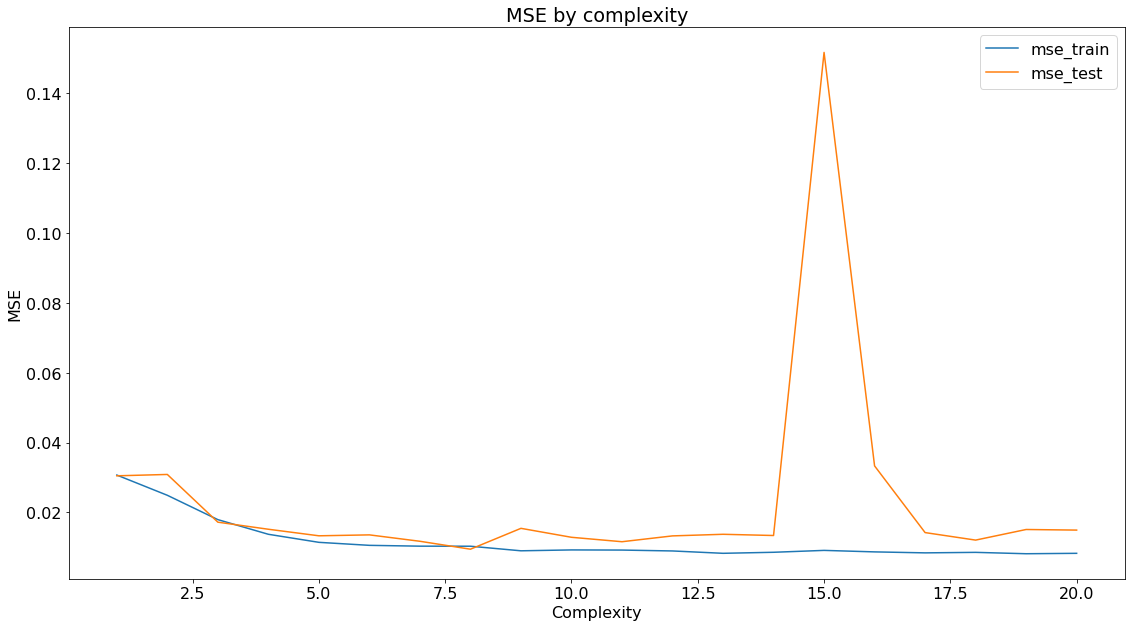

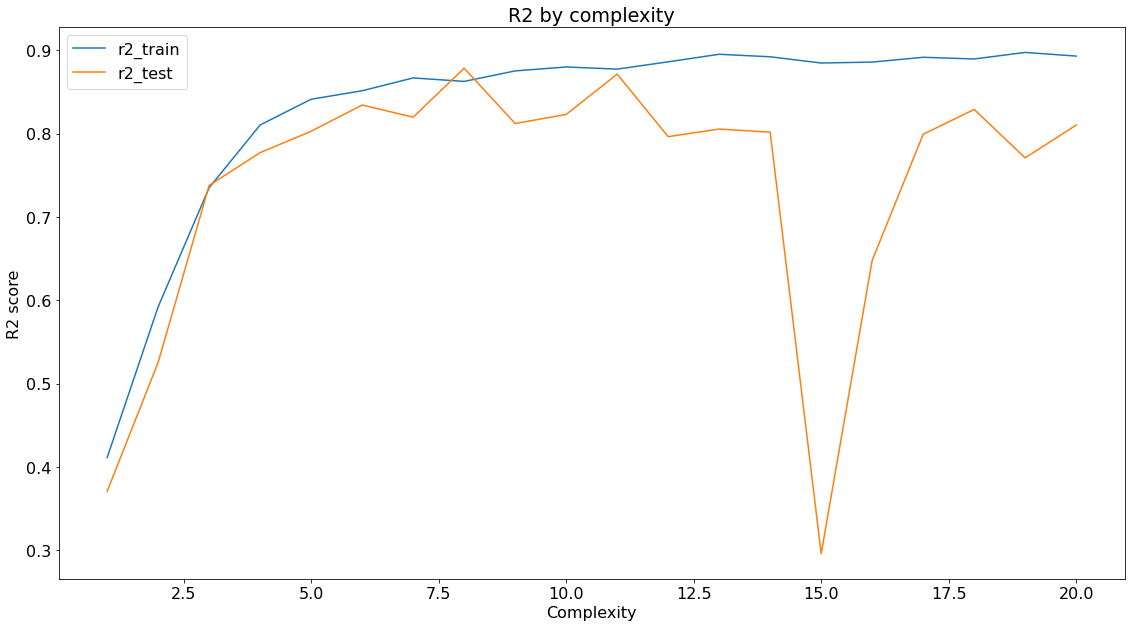

In [3]:
def simple_mse_and_r2_by_complexity(
    reg_func = least_square,
    x = None, 
    y = None, 
    z = None,
    num_points = 1000, 
    complexity = 5, 
    noise = 0.1, 
    scale = True, 
    plot_mse = False, 
    plot_r2 = False,
    y_scale = 'linear',
    lamb = 0,
    return_losses = False,
    scale_with_std = False,
    task_file_name = None):
    """
    Computes the simples ordinary least square based on the Franke Function
    
    Args:
        stuff
        
    Returns:
        ols_beta: The OLS
    """
    
    if x is None:
        x = (np.random.uniform(0, 1, num_points))
        y =  (np.random.uniform(0, 1, num_points))
    if z is None:
        z = FrankeFunction(x, y, noise) # Target
        
    MSE_train = []
    MSE_pred = []
    r2_train = []
    r2_pred = []
    
    all_ols_betas = []
    all_xtx_inv = []

    for complexity in range(1,complexity+1):

        #Trying not to sort the x and y's
        X = create_X(x, y, n=complexity)  # Data

        # True to z instead of y, and same with predictions: z_pred instead of y_pred
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        #scaler = MinMaxScaler(feature_range= [-1,1])
        scaler_in = StandardScaler(with_std=scale_with_std)
        scaler_in.fit(X_train)
        scale_z = StandardScaler(with_std=scale_with_std)
        scale_z.fit(z_train)
        
        if scale:
            X_train = scaler_in.transform(X_train)
            X_test = scaler_in.transform(X_test)
            #X_train -= np.mean(X_train)
            #X_test -= np.mean(X_test)
            z_train = scale_z.transform(z_train)
            z_test = scale_z.transform(z_test)


        beta_opt = reg_func(X_train, z_train, lamb)
        all_ols_betas.append(beta_opt)
        
        xtx = np.linalg.pinv(X_train.transpose().dot(X_train))
        all_xtx_inv.append(xtx)

        z_tilde = X_train.dot(beta_opt)
        z_pred = X_test.dot(beta_opt)


        mse_train = mean_squared_error(z_tilde, z_train)
        MSE_train.append(mse_train)
        mse_test = mean_squared_error(z_pred, z_test)
        MSE_pred.append(mse_test)

        r2_train.append(r2_score(z_tilde, z_train))
        r2_pred.append(r2_score(z_pred, z_test))
    
    if plot_mse:
        plot_errors(
            x_range_train = np.arange(1, complexity+1), 
            x_range_test = np.arange(1, complexity+1), 
            y_values_train = MSE_train, 
            y_values_test = MSE_pred,
            title = 'MSE by complexity', 
            xlabel_axis = 'Complexity',
            ylabel_axis = 'MSE',
            graph_label_train = 'mse_train',
            graph_label_test = 'mse_test',
            y_scale = y_scale,
            task_file_name = f"{task_file_name}_MSE",
        )

    if plot_r2:
        plot_errors(
            x_range_train = np.arange(1, complexity+1), 
            x_range_test = np.arange(1, complexity+1), 
            y_values_train = r2_train, 
            y_values_test = r2_pred,
            title = 'R2 by complexity', 
            xlabel_axis = 'Complexity',
            ylabel_axis = 'R2 score',
            graph_label_train = 'r2_train',
            graph_label_test = 'r2_test',
            task_file_name = f"{task_file_name}_r2_score",
        )
    
    if return_losses:
        return MSE_pred, r2_pred
    
    return all_ols_betas, all_xtx_inv

betas, xtx = simple_mse_and_r2_by_complexity(num_points = 500, complexity = 20, noise = 0.1, plot_mse = True, plot_r2 = True, task_file_name="ex_1_")

### Find confidence interval

In [4]:
def confidence_interval(beta, xtx_inv, z_score):
    """
    Calculates the confidence interval of our parameters beta
    
    Args:
        beta: our parameters
        xtx_inv: (pseudo) inverted of our design matrix transposed multiplied with the design matrix.
        confidence: confidence level
    Returns:
        confidence_interavl: the confidence interval for each of our parameters for a given z_score
    """
    diag_sqrt = np.sqrt(np.diag(xtx_inv)).reshape(-1,1)

    
    confidence_interval = [beta-z_score*diag_sqrt, beta+z_score*diag_sqrt]
        
    return np.array(confidence_interval)


def all_confidence_intervals(num_points = 1000, complexity = 5, noise = 10):
    betas, xtx = simple_mse_and_r2_by_complexity(num_points = num_points, complexity = complexity, noise = noise)

    for i, beta in enumerate(betas):
        interval_min, interval_max = confidence_interval(beta, xtx[i], 1.96)
        print("Complexity:",i+1)
        data = {
            'min': interval_min.ravel(),
            'betas': beta.ravel(),
            'max': interval_max.ravel()
        }
        df = pd.DataFrame(data)
        print(df)
        df.to_csv(f'./data/conf_int_complexity{i+1}.csv')

all_confidence_intervals()

Complexity: 1
        min     betas       max
0  0.000000  0.000000  0.000000
1 -0.099246  0.142824  0.384894
2 -0.553765 -0.307144 -0.060522
Complexity: 2
         min      betas        max
0   0.000000   0.000000   0.000000
1   5.887946   6.971373   8.054801
2 -14.408027 -13.301493 -12.194959
3  -9.566374  -8.593324  -7.620274
4   3.726766   4.589685   5.452604
5  10.253169  11.220663  12.188157
Complexity: 3
         min      betas        max
0   0.000000   0.000000   0.000000
1 -19.377364 -16.203468 -13.029572
2 -13.219593  -9.992179  -6.764765
3  32.705080  38.758959  44.812837
4  31.184727  36.252838  41.320950
5 -25.033387 -18.923827 -12.814267
6 -33.006626 -29.183409 -25.360191
7 -10.852075  -7.402904  -3.953732
8 -30.027799 -26.575076 -23.122353
9  25.158652  28.977628  32.796603
Complexity: 4
           min       betas         max
0     0.000000    0.000000    0.000000
1   -27.241546  -20.611011  -13.980475
2    -5.768711    1.216186    8.201083
3     5.743415   27.417327   4

## Exercise 2

### Plotting Figure 2.11 Using log scale

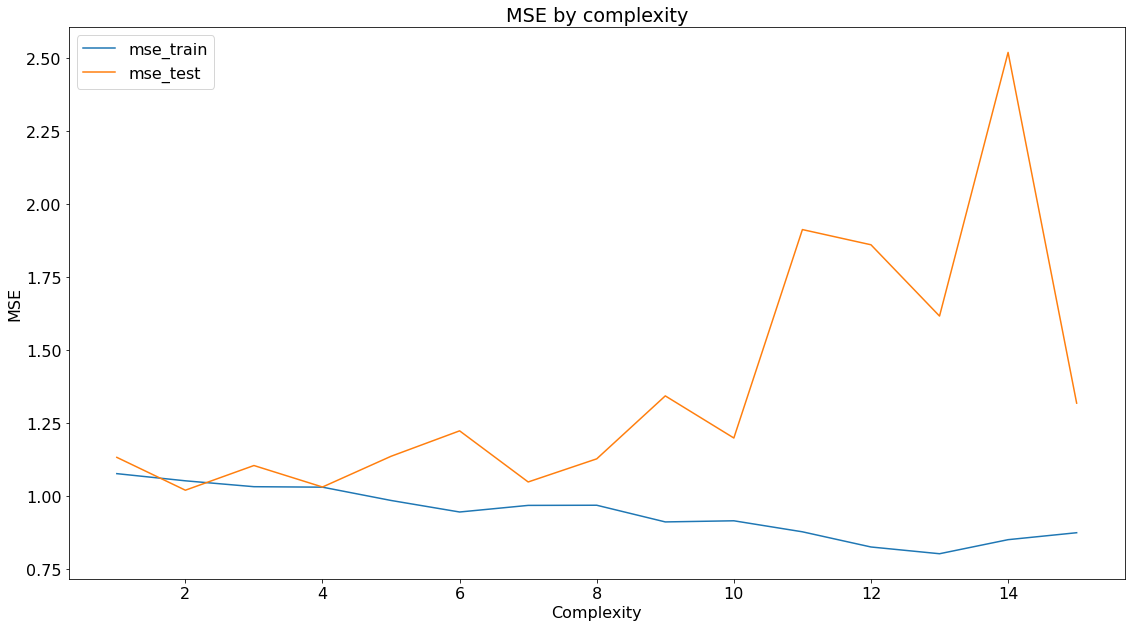

In [5]:
betas, xtx = simple_mse_and_r2_by_complexity(num_points = 500, complexity = 15, noise = 1, plot_mse=True, y_scale = 'linear', task_file_name="ex_2_")

## Bias-variance trade-off with bootstrap and varying number of datapoints ( for complexity, test size, and number of bootstraps)

In [6]:
def custom_mse_with_broadcast(y_pred, y_test):
    return np.mean((y_test - y_pred)**2, axis=1, keepdims=True)

def bias_variance_analysis_bootstrap(reg_func, 
                                     num_points, 
                                     max_degree, 
                                     num_bootstraps,
                                     x = None,
                                     y = None,
                                     z = None,
                                     noise = 0.1,
                                     lamb = 0, 
                                     plot = True, 
                                     plot_log = True, 
                                     show_plot = True, 
                                     test_size = 0.2, 
                                     only_return_error = False, 
                                     extra_text = "", 
                                     save_fig = False,
                                     scale_with_std = False):
        
    # Make data
    if x is None:
        x = (np.random.uniform(0, 1, num_points))
        y =  (np.random.uniform(0, 1, num_points))
    if z is None:
        z = FrankeFunction(x, y, noise) # Target
    
    # Aggregrate results
    error = np.zeros(max_degree)
    bias = np.zeros(max_degree)
    variance = np.zeros(max_degree)
    
    # to find best model
    best_mse = float('inf')
    best_complexity = 0
    
    for complexity in range(max_degree):
        
        # Make design matrix
        X = create_X(x, y, n=complexity + 1) # +1, as we want to start from complexity 1
        
        # Split training data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=test_size)
        
        # Scaling the data
        scaler_in = StandardScaler(with_std=scale_with_std)
        scaler_in.fit(X_train)
        scale_z = StandardScaler(with_std=scale_with_std)
        scale_z.fit(z_train)
        
        X_train = scaler_in.transform(X_train)
        X_test = scaler_in.transform(X_test)
        z_train = scale_z.transform(z_train)
        z_test = scale_z.transform(z_test)
        
        # Bootstrap
        agg = []
        z_pred_aggregate = np.empty((z_test.shape[0], num_bootstraps))
        for boot_strap_number in range(0, num_bootstraps):
            x_sample, y_sample = resample(X_train, z_train)
            # Find optimal betas
            beta_opt = reg_func(x_sample, y_sample, lamb)
            # Predict
            z_pred = X_test.dot(beta_opt).ravel()
            # Aggregate the predictions
            z_pred_aggregate[:, boot_strap_number] = z_pred
            
        # Loss: Mean of all the bootstrap MSE's
        #z_pred_aggregate = np.delete(z_pred_aggregate, 0, 1)
        mse_test = np.mean(custom_mse_with_broadcast(z_pred_aggregate, z_test))
        # Find best model
        if mse_test < best_mse:
            best_mse = mse_test
            best_complexity = complexity + 1 #Start from complexity 1, but index from 0
        #print(z_pred_aggregate[:,complexity])
        # Aggregrate stats:
        error[complexity] = mse_test
        bias[complexity] = np.mean((z_test - np.mean(z_pred_aggregate, axis = 1, keepdims=True))**2)
        variance[complexity] = np.mean((z_pred_aggregate - np.mean(z_pred_aggregate, axis = 1, keepdims = True))**2)
    
    # Calculate bias + variance
    bias_annd_variance = np.add(bias.copy(), variance.copy())
    
    # Plot figure of bias variance
    polydegree =  np.arange(1, max_degree + 1)
    if plot:
        plt.figure(figsize = (15,5))
        plt.tight_layout()
        plt.plot(polydegree, error, label='Error')
        plt.plot(polydegree, bias, label='bias')
        plt.plot(polydegree, variance, label='Variance')
        plt.plot(polydegree, bias_annd_variance, label = 'bias + variance')
        plt.title(f"{reg_func.__name__}: Bias-Variance in linear scale, Num_datapoints = {num_points}"+ extra_text)
        plt.xlabel("Complexity")
        plt.ylabel("Error")
        plt.yscale('linear')
        plt.legend()
        if save_fig:
            plt.savefig(f"./figures/{reg_func.__name__}_bias_variance_Num_datapoints_{num_points}.png", dpi=150)
        plt.show()
    if plot_log:
        plt.figure(figsize = (20,5))
        plt.tight_layout()
        plt.plot(polydegree, error, label='Error')
        plt.plot(polydegree, bias, label='bias')
        plt.plot(polydegree, variance, label='Variance')
        plt.plot(polydegree, bias_annd_variance, label = 'bias + variance')
        plt.title(f"{reg_func.__name__}: Bias-Variance in Log scale, Num_datapoints = {num_points} " + extra_text)
        plt.xlabel("Complexity")
        plt.ylabel("Error")
        plt.yscale('log')
        plt.legend()
    if show_plot:
        plt.show()
    #print(f"Best MSE: {best_mse} at complexity: {best_complexity} for number of datapoints: {num_points}, num_bootstraps = {best_num_bstraps}, , test_split = {train_split}")
    if only_return_error:
        return error
    
    return best_mse, best_complexity, error, bias, variance

def run_bias_variance_bootstrap(reg_func, 
                                 x = None,
                                 y = None,
                                 z = None,
                                 noise = 0.1,
                                 points = [20, 50, 100], 
                                 max_degree = 12, 
                                 test_sizes = (0.2, 1, 1), 
                                 lamb = 0, 
                                 plot_best = True,
                                 extra_text = "",
                                 save_fig = False,
                                 plot_scale = 'linear'):
    
    best_mse_per_points = np.zeros(len(points))
    best_complexity_per_points = np.zeros(len(points))
    
    best_error_per_points = np.zeros((len(points), max_degree))
    best_bias_per_points = np.zeros((len(points), max_degree))
    best_variance_per_points = np.zeros((len(points), max_degree))
    best_train_split_per_points = np.zeros(len(points))
    
    # Run for different number of datapoints
    for point_ind, num_points in enumerate(points):
        global_best_mse = float('inf')
        global_best_complexity = 0
        best_num_bstraps = 0
        best_train_split = 0
        best_error = []
        best_bias = []
        best_variance = []
        
        #for num_bstraps in range(5,11):
        # run for different size of test data
        for test_size in np.arange(start = test_sizes[0], stop = test_sizes[1], step = test_sizes[2]):
            best_mse, best_complexity, error, bias, variance = bias_variance_analysis_bootstrap(reg_func, num_points, x=x, y=y, z=z, noise = noise, max_degree=max_degree, num_bootstraps = num_points, test_size = test_size, plot=False, plot_log = False, lamb = lamb, extra_text = extra_text)
            if best_mse < global_best_mse:
                global_best_mse = best_mse
                global_best_complexity = best_complexity
                best_train_split = test_size
                best_error = error
                best_bias = bias
                best_variance = variance
                
        # Re-run and plot best results for each number of datapoints
        if plot_best:
            bias_annd_variance = np.add(best_bias.copy(), best_variance.copy())
            polydegree =  np.arange(1, max_degree + 1)
            print(f"Best global: {global_best_mse} at complexity: {global_best_complexity} for number of datapoints: {num_points}, num_bootstraps = {num_points}, test_split = {best_train_split}")
            plt.figure(figsize = (15,5))
            plt.plot(polydegree, best_error, label='Error')
            plt.plot(polydegree, best_bias, label='bias')
            plt.plot(polydegree, best_variance, label='Variance')
            plt.plot(polydegree, bias_annd_variance, label = 'bias + variance')
            plt.title(f"{reg_func.__name__}: Bias-Variance in linear scale, Num_datapoints = {num_points}"+ extra_text)
            plt.xlabel("Complexity")
            plt.ylabel("Error")
            plt.yscale(plot_scale)
            plt.legend()
            plt.show()
            
        best_mse_per_points[point_ind] = global_best_mse
        best_complexity_per_points[point_ind] = global_best_complexity
        
        best_error_per_points[point_ind,:] = best_error
        best_bias_per_points[point_ind,:] = best_bias
        best_variance_per_points[point_ind,:] = best_variance
        best_train_split_per_points[point_ind] = best_train_split

    return best_mse_per_points, best_complexity_per_points, best_error_per_points, best_bias_per_points, best_variance_per_points, best_train_split_per_points

Best global: 0.010076958800533954 at complexity: 1 for number of datapoints: 20, num_bootstraps = 20, test_split = 0.2


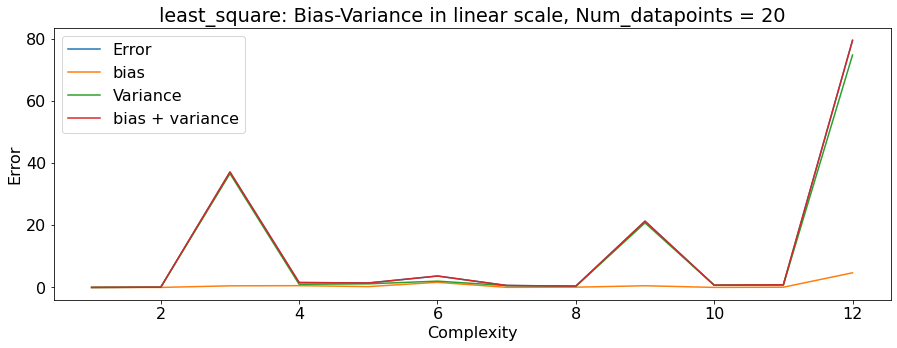

Best global: 0.01753297240077983 at complexity: 1 for number of datapoints: 50, num_bootstraps = 50, test_split = 0.2


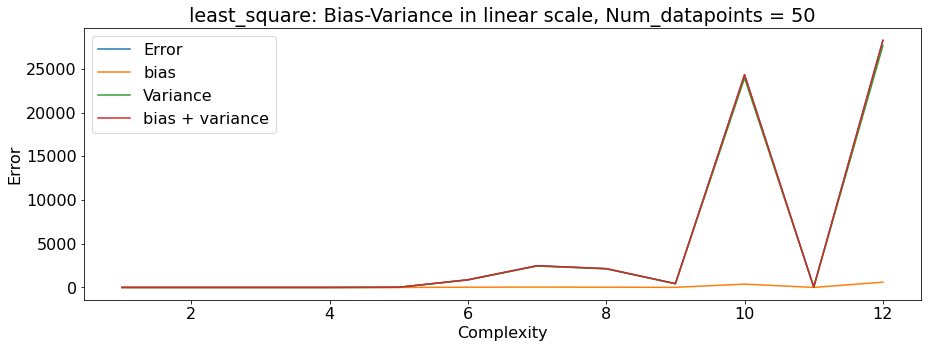

Best global: 0.012268195362396058 at complexity: 2 for number of datapoints: 100, num_bootstraps = 100, test_split = 0.2


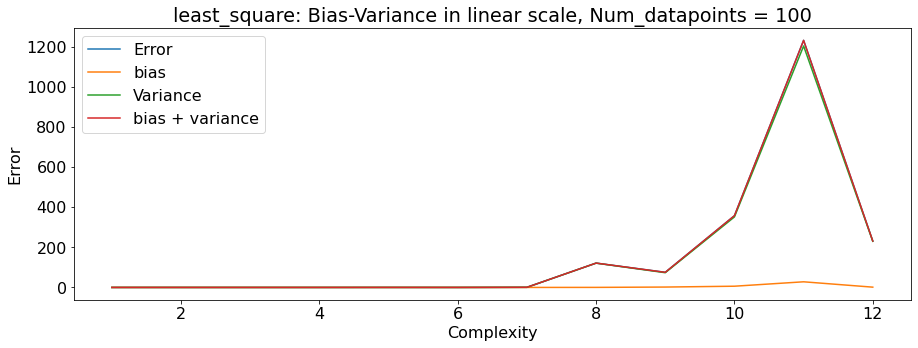

In [7]:
_ = run_bias_variance_bootstrap(least_square, test_sizes = (0.2, 0.5, 0.1))

# Exercise 3

## K-fold cross-validation

Scaling the data after we split the data, as if we split it before, then the we scale based on all the data instead of just training

In [ ]:
def kfold_custom(reg_func, 
                 num_points, 
                 num_splits, 
                 complexity, 
                 x=None, 
                 y=None,
                 z=None,
                 noise = 0.1, 
                 lamb = 0, 
                 scale = True,
                 scale_with_std = False,
                 set_random_seed=False):
    
    # Set random seed to compare with SKlearn
    if set_random_seed:
        np.random.seed(88)

    
    # Create data
    if x is None:
        x = (np.random.uniform(0, 1, num_points))
        y =  (np.random.uniform(0, 1, num_points))
    if z is None:
        z = FrankeFunction(x, y, noise) # Target
    
    X = create_X(x, y, n=complexity)

    # Initialize our kfold
    kfold = KFold(n_splits = num_splits)
    
    # Error
    mse_test_kfold = np.zeros(num_splits)
    
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Training and test split + scaling

        if scale:
            if scale_with_std:
                X_train = (X[train_index] - np.mean(X[train_index]))/np.std(X[train_index])
                z_train = (z[train_index] - np.mean(z[train_index]))/np.std(z[train_index])

                X_test = (X[test_index] - np.mean(X[test_index]))/np.std(X[test_index])
                z_test = (z[test_index] - np.mean(z[test_index]))/np.std(z[test_index])
            else:
                X_train = X[train_index] - np.mean(X[train_index])
                z_train = z[train_index] - np.mean(z[train_index])

                X_test = X[test_index] - np.mean(X[test_index])
                z_test = z[test_index] - np.mean(z[test_index])
        # Scale = False for comparing with SKlearn
        else:
            X_train = X[train_index] 
            z_train = z[train_index]

            X_test = X[test_index]
            z_test = z[test_index]
        
        
        # Optimal Betas
        beta_opt = reg_func(X_train, z_train, lamb)

        # Prediction
        z_pred = X_test.dot(beta_opt)
        
        mse_test_kfold[i] = mean_squared_error(z_test, z_pred)     
        
    return np.mean(mse_test_kfold)

    
def cross_validation(reg_func, 
                     num_points, 
                     num_folds, 
                     max_complexity, 
                     x=None, 
                     y=None,
                     z=None,
                     noise=0.1, 
                     lamb=0, 
                     plot = False,
                     scale = True, 
                     set_random_seed=False,
                     scale_with_std = False):
    
    mse_per_complexity = np.zeros(max_complexity)
    
    for complexity in range(max_complexity):
        mse_per_complexity[complexity] = kfold_custom(reg_func, num_points, num_folds, complexity+1, x=x, y=y, z=z, noise=noise, lamb=lamb, scale = scale, set_random_seed = set_random_seed, scale_with_std = scale_with_std)
    
    if plot:
        polydegree =  np.arange(1, max_complexity +1 )
        plt.figure(figsize = (16,9))
        plt.tight_layout()
        plt.plot(polydegree, mse_per_complexity, label='MSE cross validation: Num Folds = ' + str(num_folds))
        plt.xlabel("Complexity")
        plt.ylabel("MSE")
        plt.title("MSE all folds per complexity")
        #plt.yscale('log')
        plt.legend()
    
    return mse_per_complexity
        
def full_cross_valid(reg_func, 
                     num_points, 
                     min_fold, 
                     max_fold, 
                     max_complexity, 
                     x=None, 
                     y=None,
                     z=None,
                     noise=0.1, 
                     lamb=0, 
                     plot = False, 
                     show_plot = False,
                     scale = True, 
                     set_random_seed=False,
                     scale_with_std = False):
    
    all_mse_per_fold = np.zeros([max_fold-min_fold+1, max_complexity])
    
    # perform CV for different number of folds
    for i, fold in enumerate(range(min_fold, max_fold+1)):
        all_mse_per_fold[i] = cross_validation(reg_func, num_points, fold, max_complexity, x=x, y=y, z=z, noise=noise, lamb=lamb, plot=plot, scale = scale, set_random_seed = set_random_seed, scale_with_std = scale_with_std)

    if show_plot:
        plt.show()
    
    return all_mse_per_fold

def find_best_params_cv(reg_func, 
                        num_points, 
                        min_fold, 
                        max_fold, 
                        max_complexity,
                        x=None,
                        y=None,
                        z=None,
                        noise=0.1, 
                        lamb=0, 
                        plot = False,
                        show_plot = False, 
                        set_random_seed = False):
    
    results = full_cross_valid(reg_func, num_points, min_fold, max_fold , max_complexity, x=x, y=y, z=z, noise=noise, lamb=lamb, plot = True, show_plot = True, set_random_seed = set_random_seed)
    best_fold, best_complexity = np.unravel_index(np.argmin(results, axis=None), results.shape)
    # Since fold indexing starts from 0, we need to add the min fold to get the actual fold
    actual_best_fold = best_fold + min_fold 
    print(f"Best params: Folds = {actual_best_fold} and complexity = {best_complexity}")
    polydegree =  np.arange(1, max_complexity+1)
    plt.figure(figsize=(16,9))
    plt.tight_layout()
    plt.plot(polydegree, results[best_fold], label = f"MSE for best fold {actual_best_fold}")
    plt.title(f"MSE for best parameters of CV using {reg_func.__name__}. Best Params: Complexity = {best_complexity}, Best fold = {actual_best_fold}")
    plt.xlabel("Complexity")
    plt.ylabel("MSE")
    plt.yscale('log')
    plt.legend()

In [ ]:
find_best_params_cv(least_square, 100, 5,10 , 10, plot = True, show_plot = True, set_random_seed = True)

### Comparing with SKlearn

In [ ]:
def cross_val_sklearn(num_points, num_folds, max_complexity, x=None, y=None, z = None, noise = 0.1, plot=False):
    np.random.seed(88)
    estimated_mse_sklearn = np.zeros(max_complexity)
    
    if x is None:
        x = (np.random.uniform(0, 1, num_points))
        y =  (np.random.uniform(0, 1, num_points))
    if z is None:
        z = FrankeFunction(x, y, noise) # Target
    
    for complexity in range(max_complexity):
        
        # Don't scale, just fit the raw data.
        linreg = LinearRegression(fit_intercept = False)
        
        X = create_X(x, y, n=complexity)
        
        kfold = KFold(n_splits = num_folds)

        estimated_mse_folds = cross_val_score(linreg, X, z, scoring='neg_mean_squared_error', cv=kfold)

        estimated_mse_sklearn[complexity] = np.mean(-estimated_mse_folds)
        
    polydegree =  np.arange(max_complexity)
    plt.figure(figsize = (16,9))
    plt.tight_layout()
    plt.plot(polydegree, estimated_mse_sklearn, label='MSE cross validation Sklearn ' + str(num_folds))
    plt.xlabel("Complexity")
    plt.ylabel("MSE")
    #plt.yscale('log')
    plt.legend()
    if plot:
        plt.show()

In [ ]:
cross_val_sklearn(100, 10, 10, plot=True)

In [ ]:
def compare_cross_valid_custom_vs_sklearn():
    for fold in range(5,11):
        full_cross_valid(least_square, 100, fold,fold,15, plot=False, scale = False, set_random_seed = True)
        cross_val_sklearn(100, fold, 15)
        plt.show()

In [ ]:
compare_cross_valid_custom_vs_sklearn()

## Compare Cross validation vs. bootstrap for MSE for Least Square

In [14]:
def compare_cv_with_booststrap(max_data_points, max_complexity):
    for fold in range(5,11):
        print(f"Fold: {fold}")
        #for num_data_points in range(20,max_data_points, 50):
        for num_data_points in [20, 100]:
            bootstrap_mse = bias_variance_analysis_bootstrap(least_square, num_data_points, max_complexity, num_data_points, plot = False, only_return_error = True, plot_log = False) 
            cv_mse = cross_validation(least_square, num_data_points, fold, max_complexity)
            cross_val_sklearn(num_data_points, fold, max_complexity)
            polydegree =  np.arange(max_complexity)
            plt.figure(figsize = (16,9))
            plt.tight_layout()
            plt.plot(polydegree, bootstrap_mse, label='MSE Boot_strap')
            plt.plot(polydegree, cv_mse, label='MSE CV num_folds: '+str(fold))
            plt.xlabel("Complexity")
            plt.ylabel("MSE")
            plt.title("Bootstrap vs. CV:  num_data_points: "+str(num_data_points))
            plt.yscale('log')
            plt.legend()
            plt.show()

Fold: 5


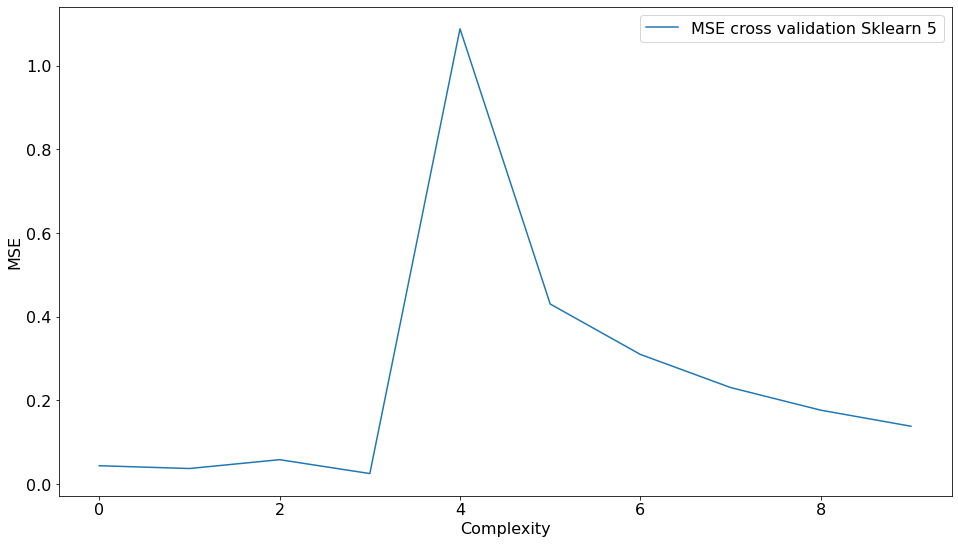

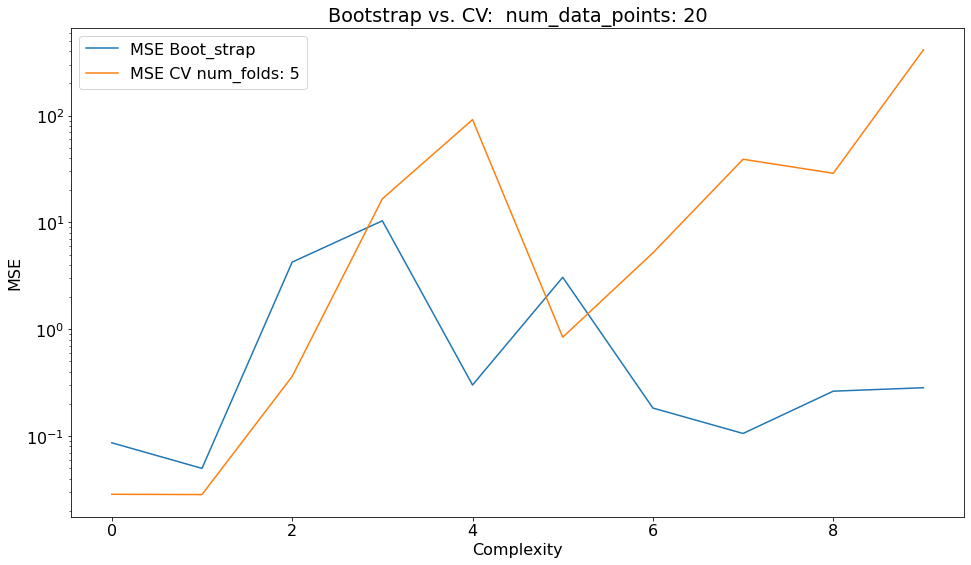

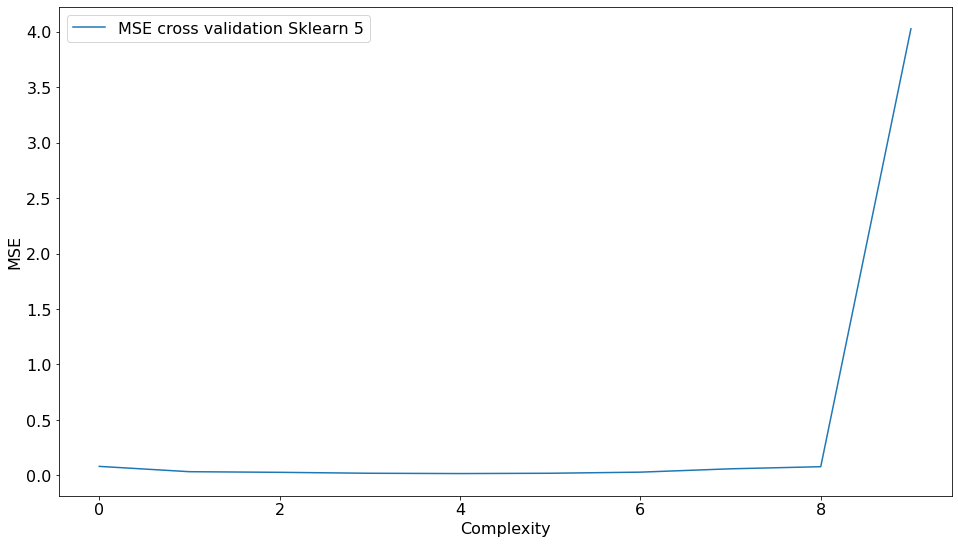

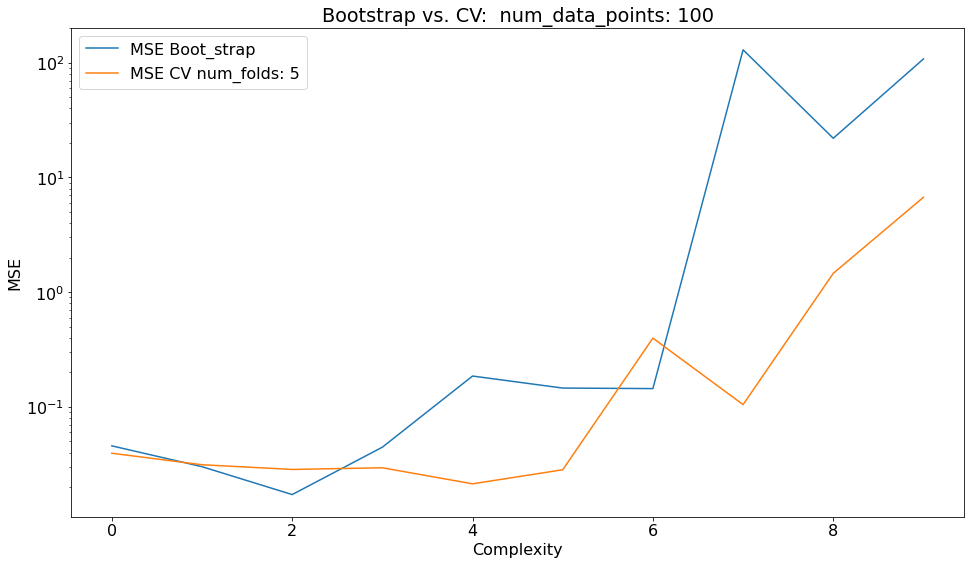

Fold: 6


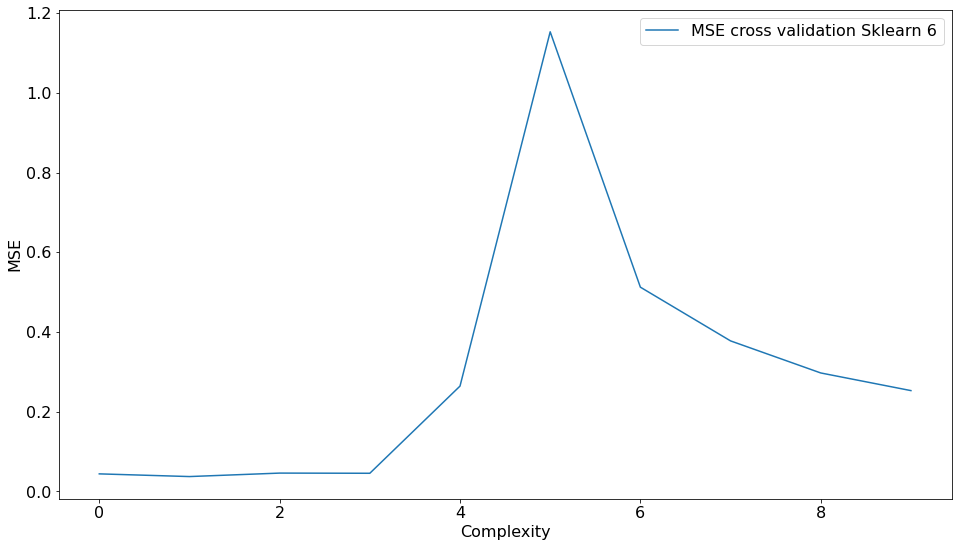

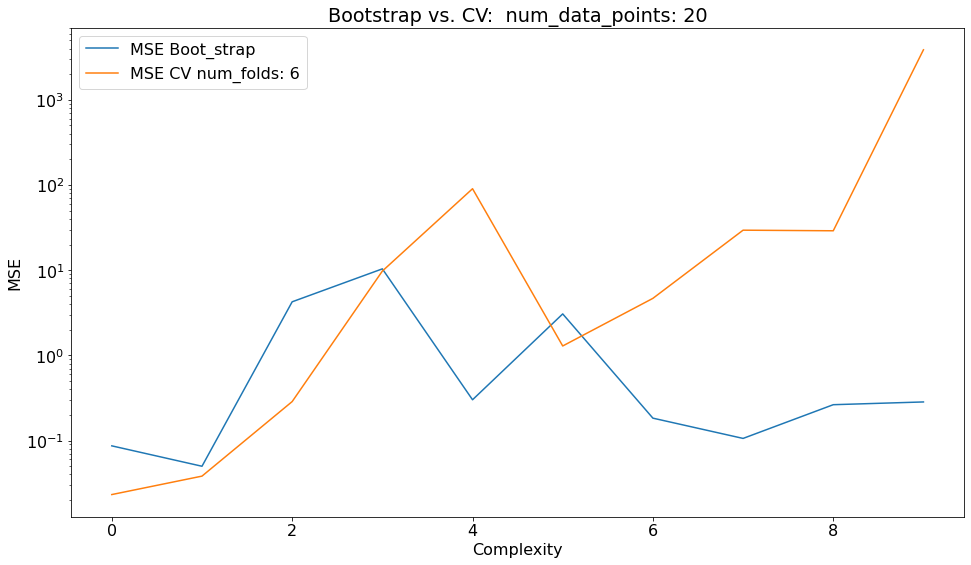

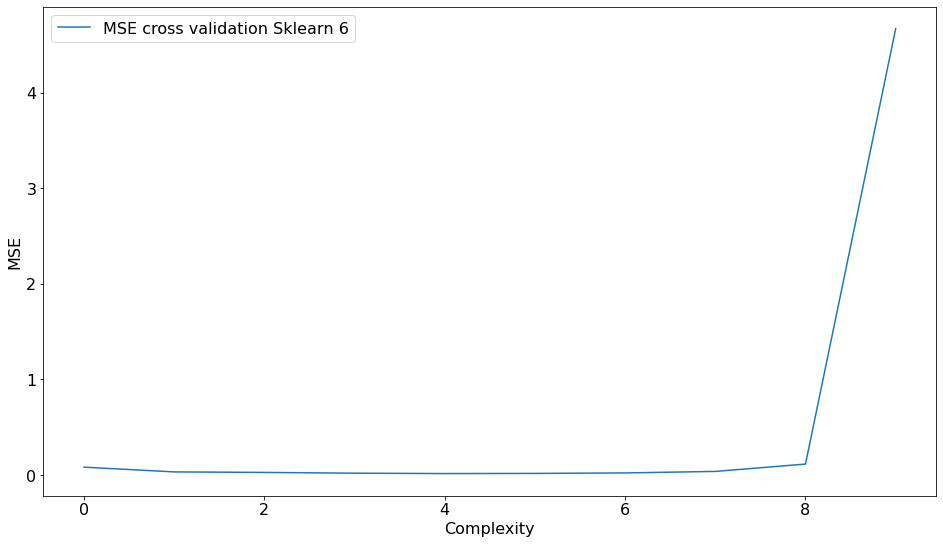

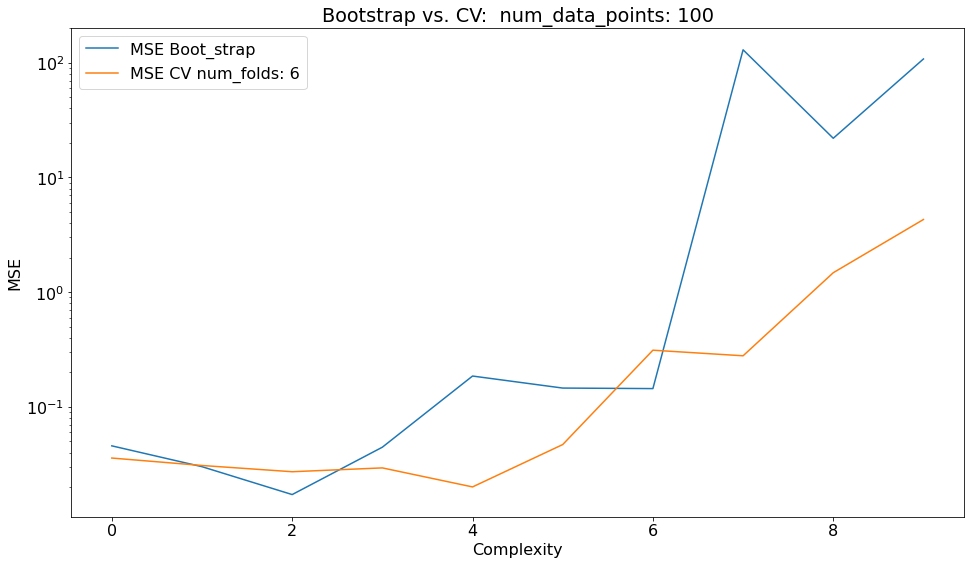

Fold: 7


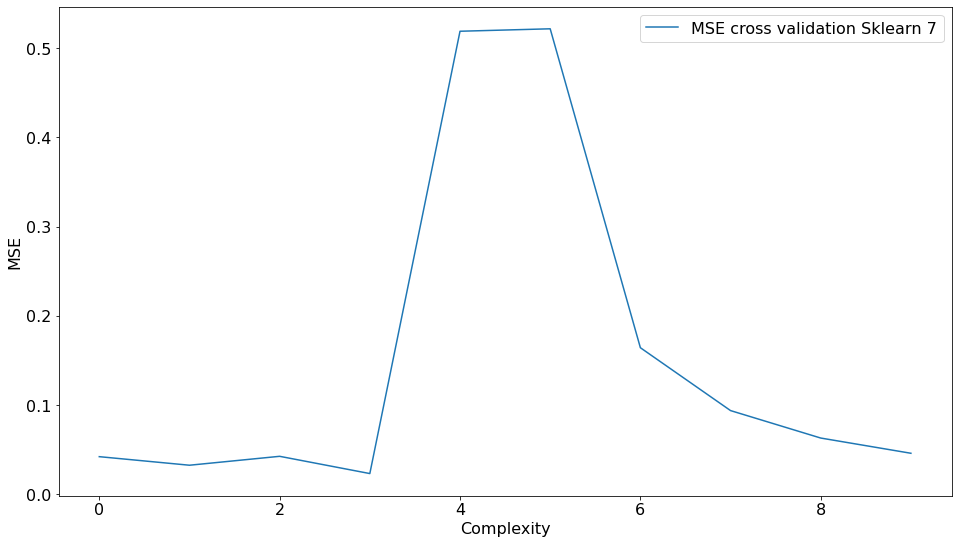

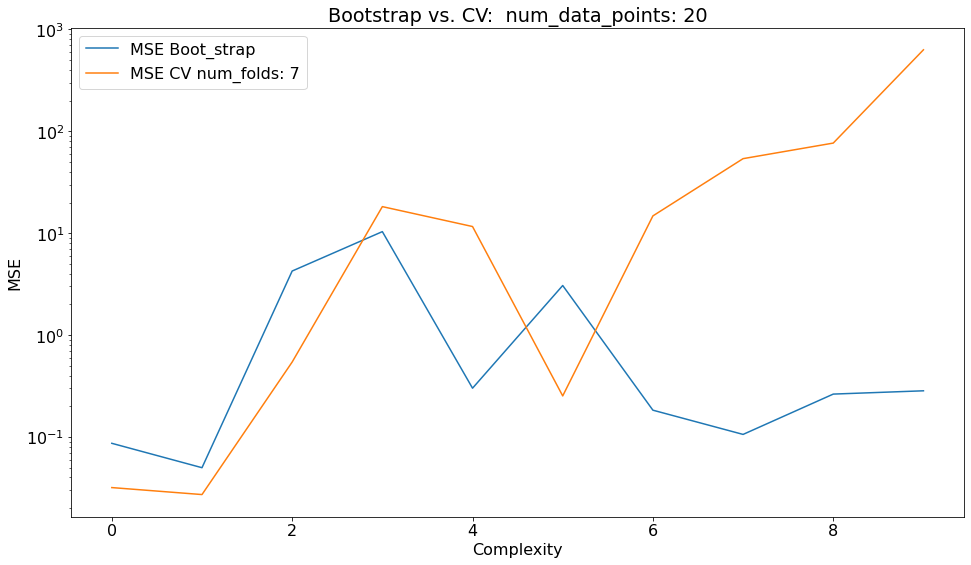

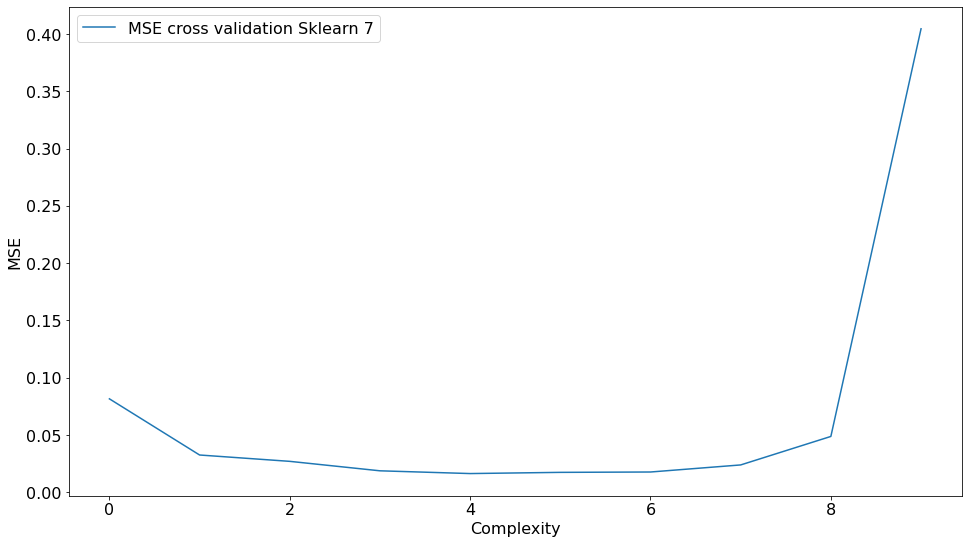

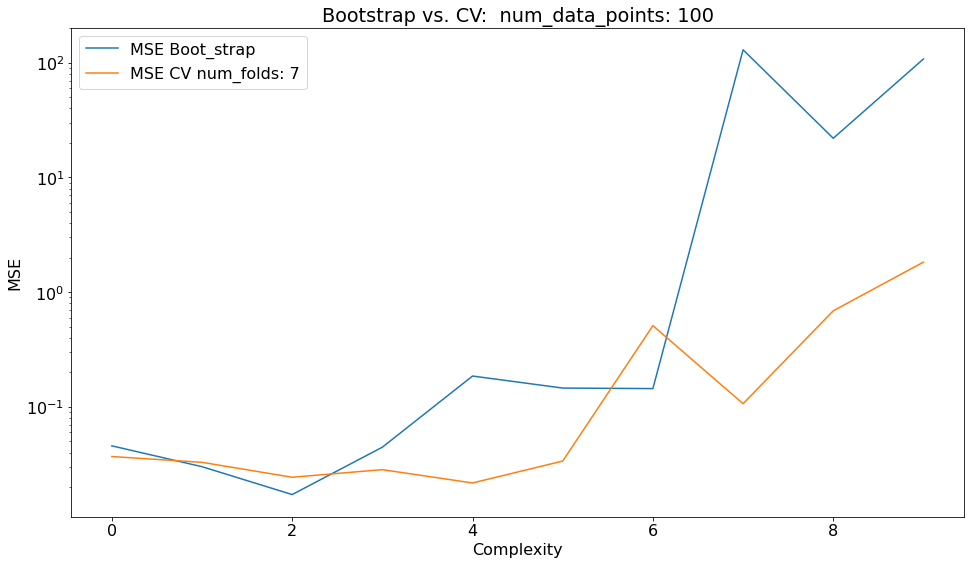

Fold: 8


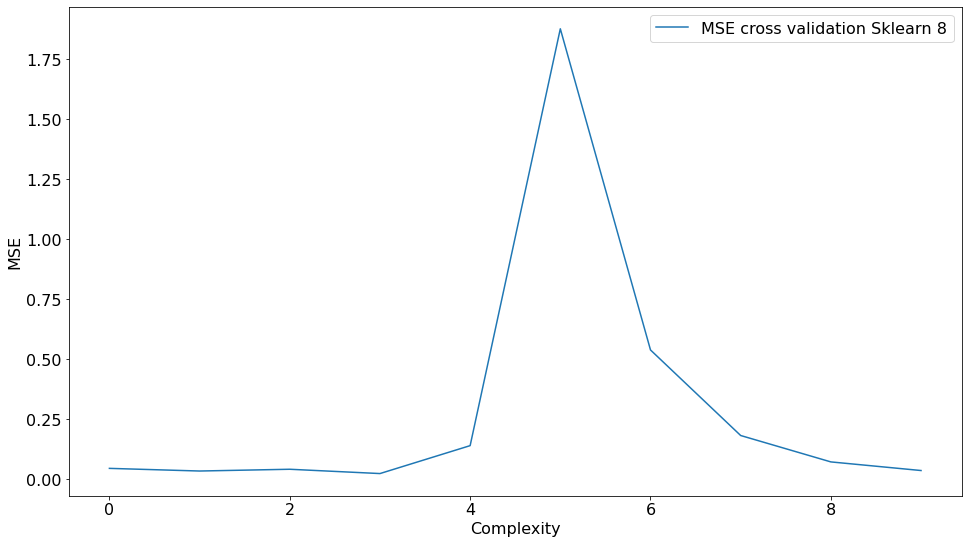

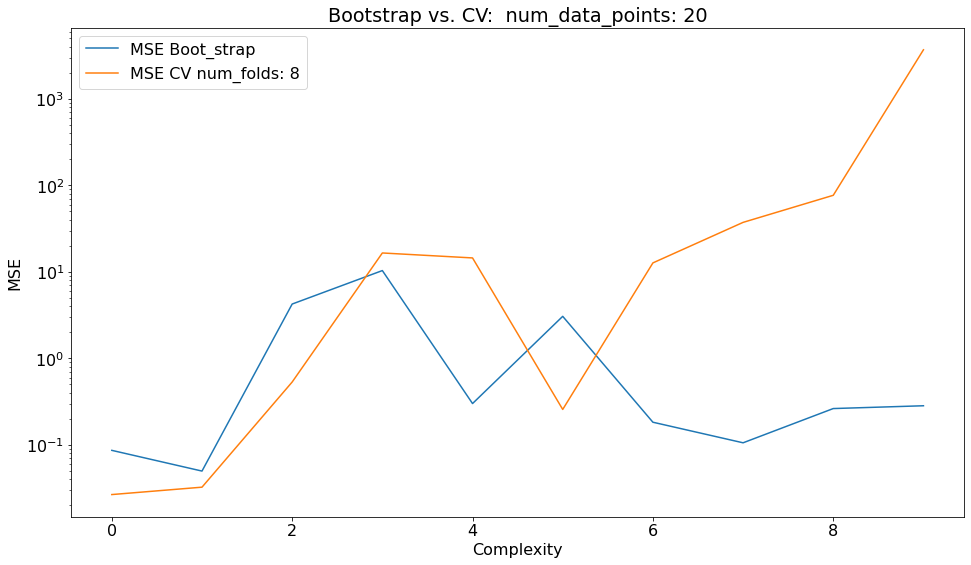

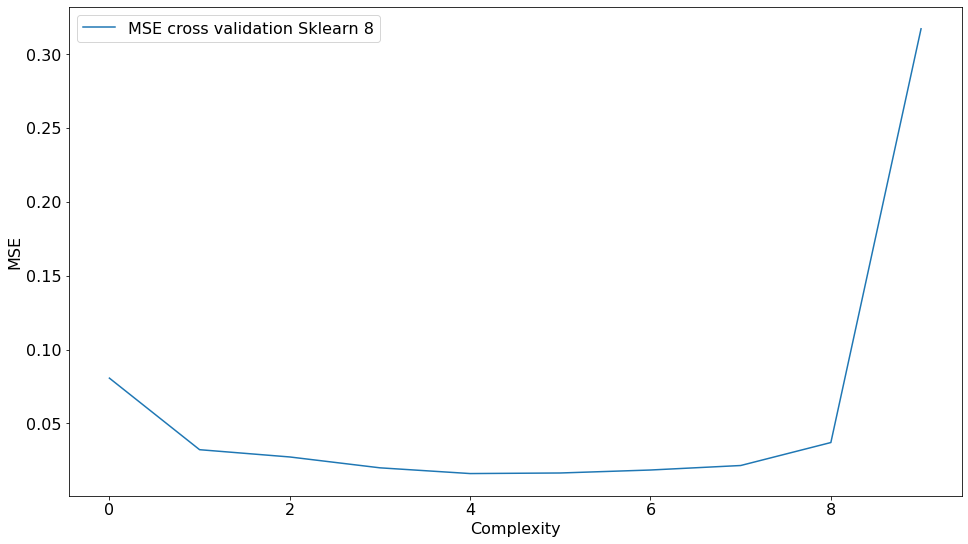

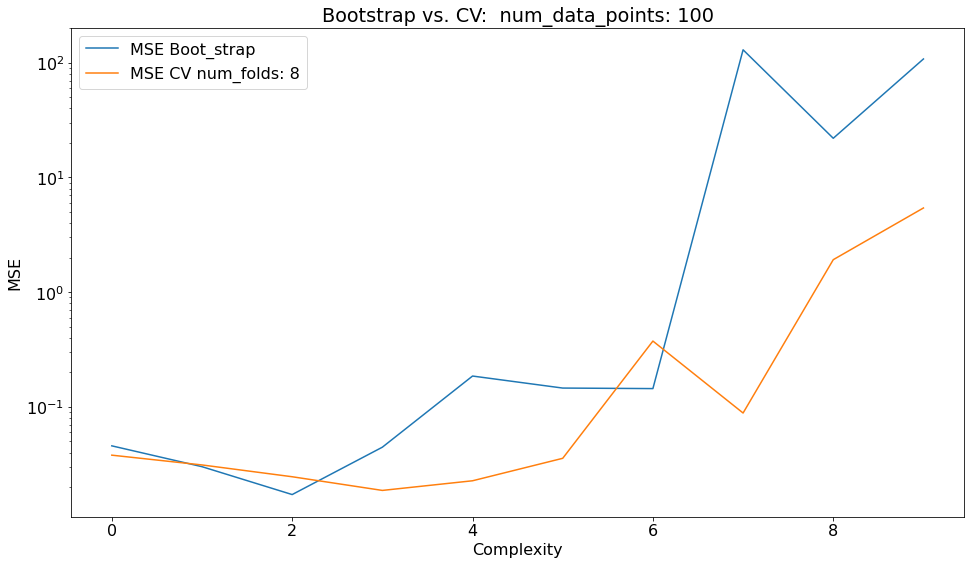

Fold: 9


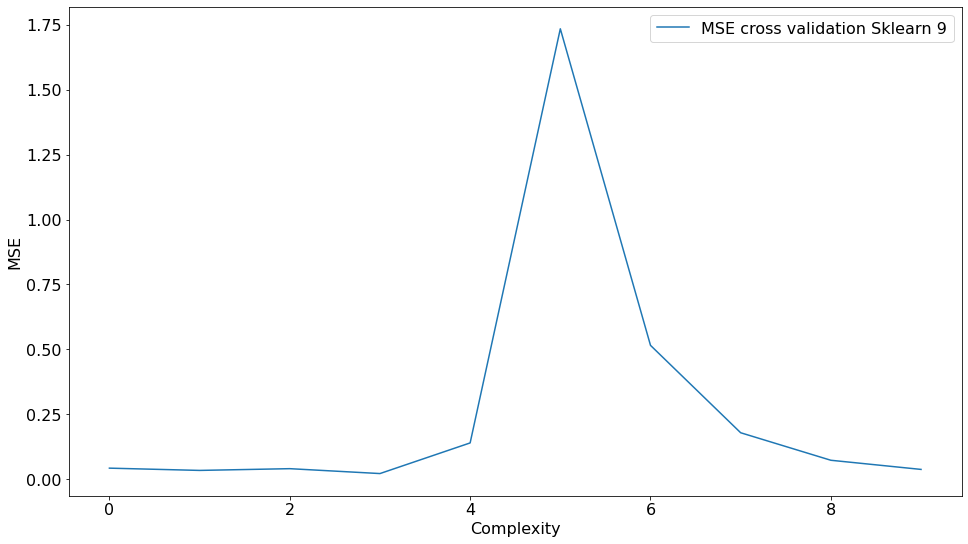

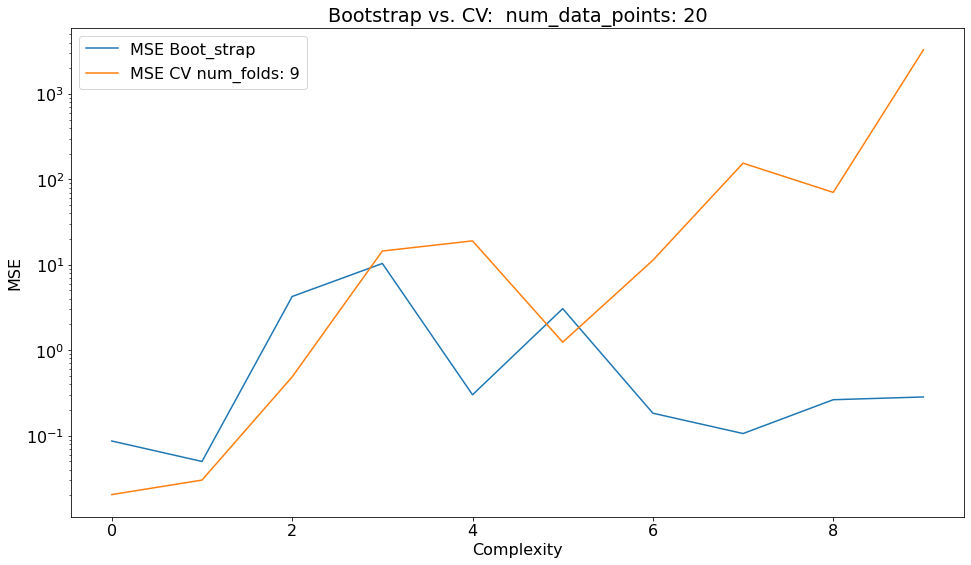

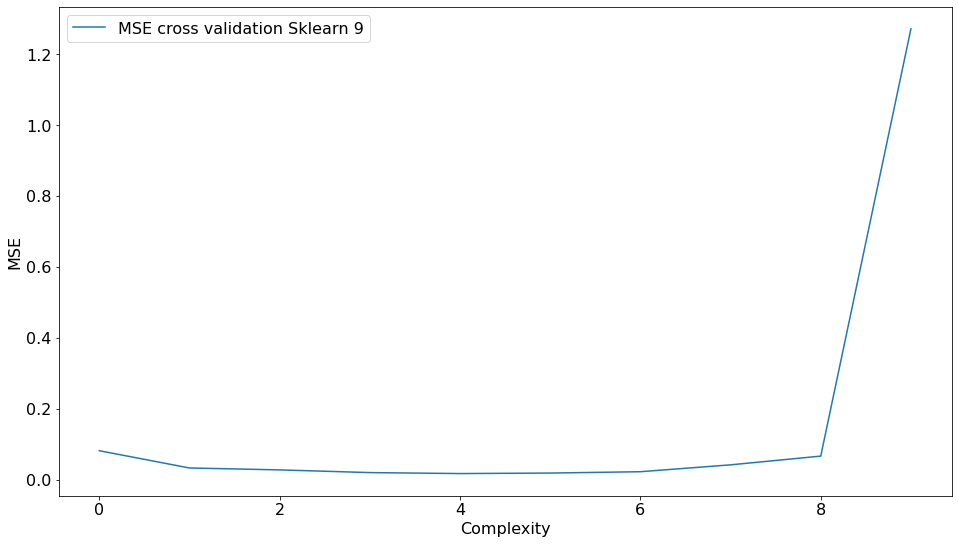

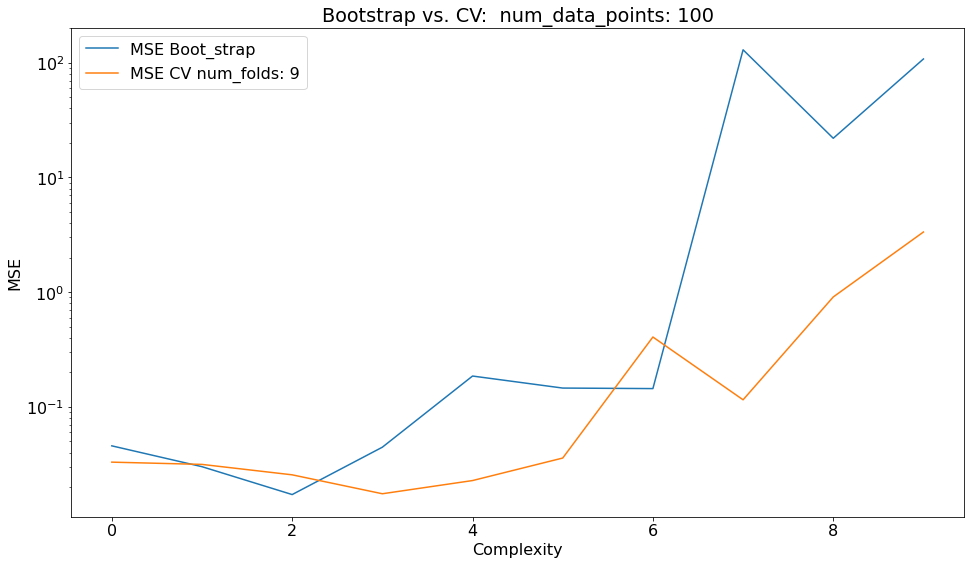

Fold: 10


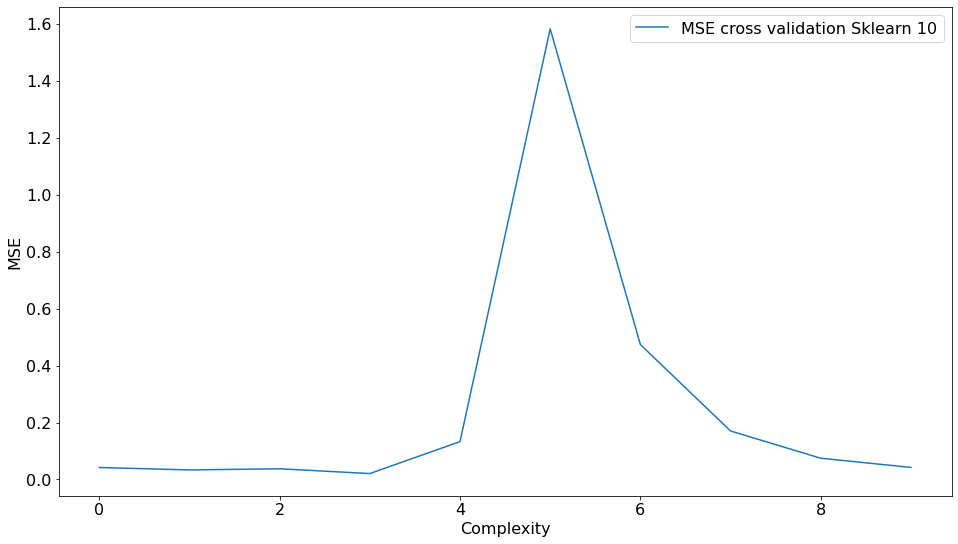

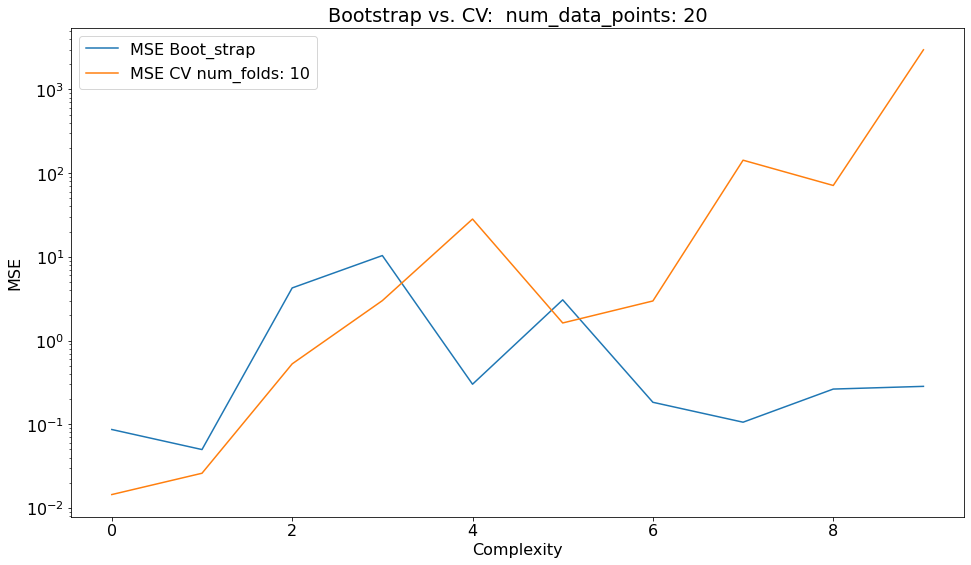

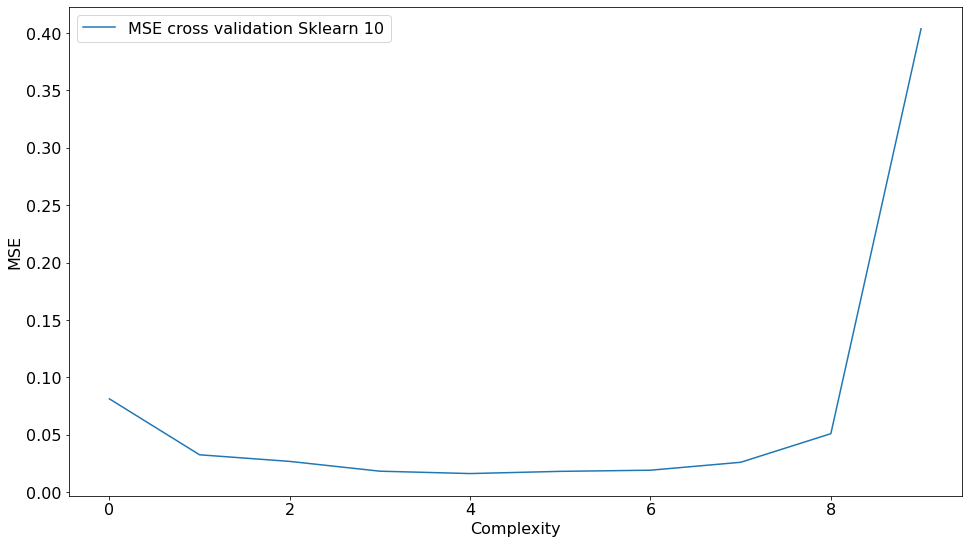

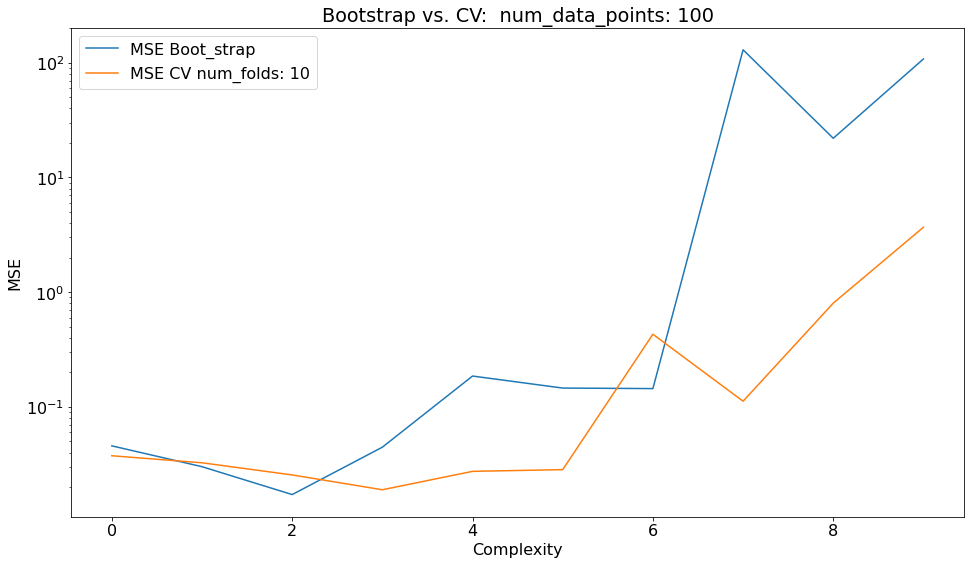

In [15]:
compare_cv_with_booststrap(200, 10)    

### Results 

commment comment comment...

Num datapoints: CV better for many, bootstrap better for few.

# Exercise 4

In this exercise we will:
* Write our own Ridge regression using singular value decomposition using the function pinv(), which uses the SVD.
* Perform the same bootstrap analysis as we did in exercise 2, using the same polynomials with different lambdas.
* Perform the same cross validation as in exercise 3, but with varying lambdas.
* Compare the results from Ridge (Ex. 4) with results from Least Square (Ex. 1-3).
* In general: Study the dependancies of lambads

Furthermore:
* Study the bias-variance trade-off for varying parameters lambda (for Ridge) using bootstrap.

### Custom Ridge Regression

In [16]:
def Ridge(x_value,y_value, lamb):
    return np.linalg.pinv(x_value.T.dot(x_value) + lamb*np.identity(x_value.shape[1])).dot(x_value.T).dot(y_value)

## Bootstrap analysis (Ex. 2) using Ridge, with different lambdas

Best lambda: 228.54638641349885  for number of datapoints: 20
Best global: [0.0026121] at complexity: [2.] for number of datapoints: 20, num_bootstraps = 20, test_split = [0.2]


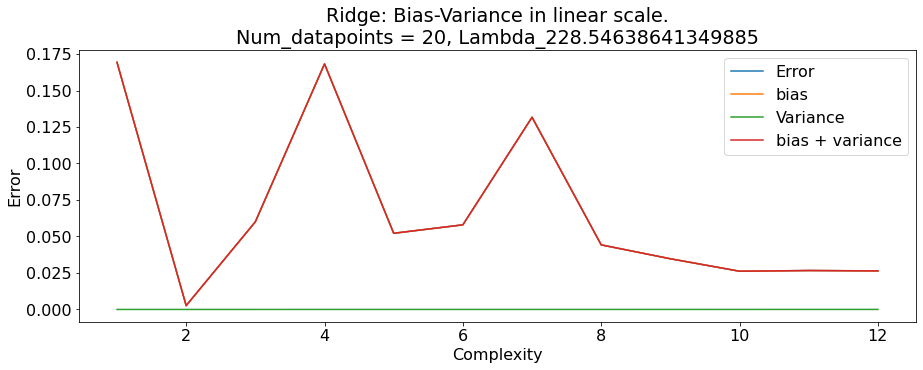

Best global: 0.02742321040833446 at complexity: 2 for number of datapoints: 20, num_bootstraps = 20, test_split = 0.2


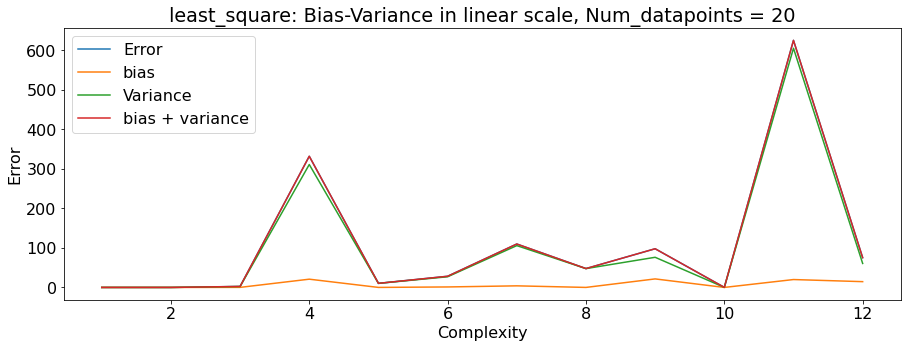

Best lambda: 0.0006614740641230146  for number of datapoints: 50
Best global: [0.00786841] at complexity: [1.] for number of datapoints: 50, num_bootstraps = 50, test_split = [0.2]


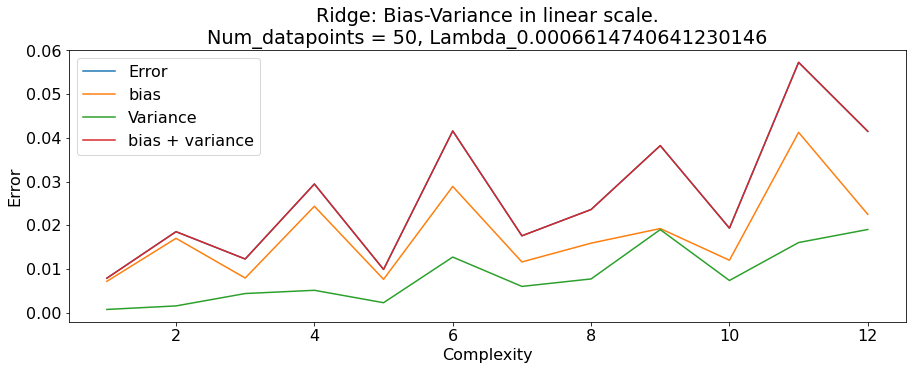

Best global: 0.036034013013510204 at complexity: 3 for number of datapoints: 50, num_bootstraps = 50, test_split = 0.2


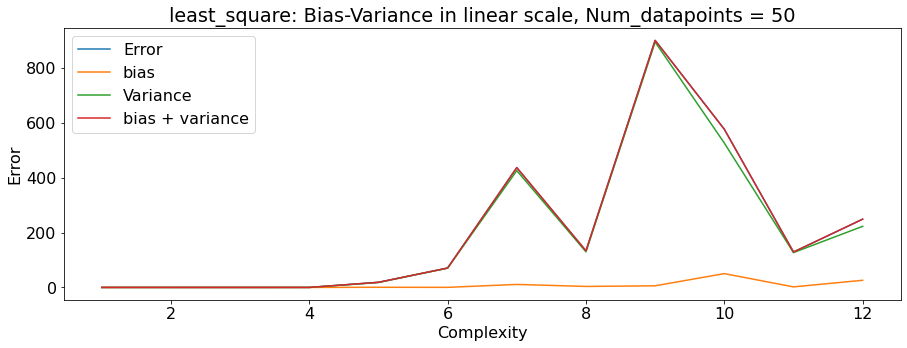

Best lambda: 0.0027283333764867696  for number of datapoints: 100
Best global: [0.01297263] at complexity: [6.] for number of datapoints: 100, num_bootstraps = 100, test_split = [0.2]


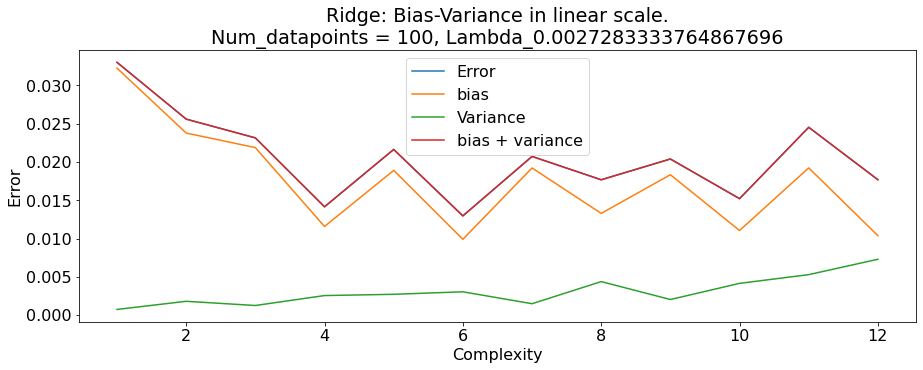

Best global: 0.02086569537400866 at complexity: 4 for number of datapoints: 100, num_bootstraps = 100, test_split = 0.2


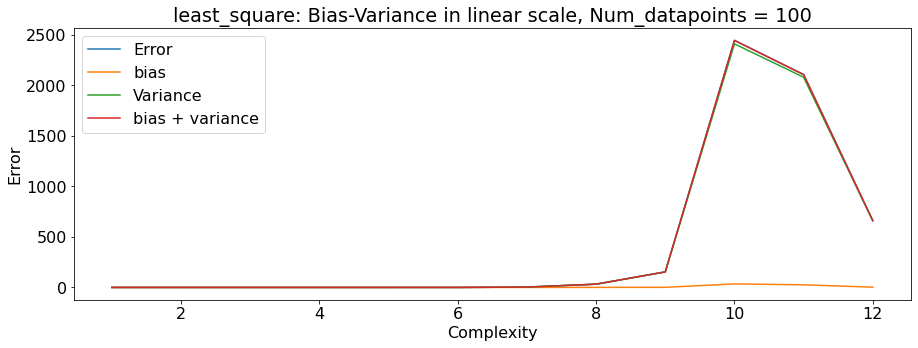

In [17]:
def run_bias_variance_bootstrap_ridge_or_lasso(reg_func, x=None, y=None, z = None, noise = 0.1, nlambdas = 10, data_point_list = [20, 50, 100], save_fig = False, max_degree = 12, ):
    #np.random.seed(88)
    lambdas = np.logspace(-4,4, nlambdas)
    mse_aggregate = np.zeros([len(data_point_list), nlambdas])
    for data_point_index, num_points in enumerate(data_point_list):
        #print(f"Number of datapoints {num_points}")
        global_best_mse = float('inf')
        best_lamb = 0
        global_best_complexity = 0
        
        global_best_error_per_points = None
        global_best_bias_per_points = None
        global_best_variance_per_points = None
        
        global_best_test_split = 0
        
        best_extra_text = ""
        
        for lamb_ind, lamb in enumerate(lambdas):
            extra =  'Lambda_'+str(lamb)
            best_mse_this_lambda, best_complexity, best_error_per_points, best_bias_per_points, best_variance_per_points, best_train_split = run_bias_variance_bootstrap(reg_func, x=x, y=y, z=z, noise = noise, points = [num_points], max_degree = max_degree, lamb = lamb, plot_best = False, extra_text = extra)
            
            if best_mse_this_lambda < global_best_mse:
                global_best_mse = best_mse_this_lambda
                best_lamb = lamb
                global_best_complexity = best_complexity
                
                global_best_error_per_points = best_error_per_points
                global_best_bias_per_points = best_bias_per_points
                global_best_variance_per_points = best_variance_per_points
                
                global_best_train_split = best_train_split
                best_extra_text = extra
            
                
        print(f"Best lambda: {best_lamb}  for number of datapoints: {num_points}")
        
        bias_annd_variance = np.add(global_best_bias_per_points.copy(), global_best_variance_per_points.copy())
        polydegree =  np.arange(1, max_degree + 1)
        print(f"Best global: {global_best_mse} at complexity: {global_best_complexity} for number of datapoints: {num_points}, num_bootstraps = {num_points}, test_split = {global_best_train_split}")
        plt.figure(figsize = (15,5))
        plt.tight_layout()
        plt.plot(polydegree, global_best_error_per_points.reshape(-1,1), label='Error')
        plt.plot(polydegree, global_best_bias_per_points.reshape(-1,1), label='bias')
        plt.plot(polydegree, global_best_variance_per_points.reshape(-1,1), label='Variance')
        plt.plot(polydegree, bias_annd_variance.reshape(-1,1), label = 'bias + variance')
        plt.title(f"{reg_func.__name__}: Bias-Variance in linear scale.\nNum_datapoints = {num_points}, "+best_extra_text)
        plt.xlabel("Complexity")
        plt.ylabel("Error")
        plt.legend()
        plt.show()
        
    return mse_aggregate, lambdas

for num_points in [20, 50, 100]:
    run_bias_variance_bootstrap_ridge_or_lasso(Ridge, data_point_list = [num_points], nlambdas = 40, save_fig = True)
    run_bias_variance_bootstrap(least_square, points = [num_points], save_fig = True)

## What do we see?

We see that with a large regularization term, the number of data points will have less to say. The regularization term squishes the parameters of the model so much that the feeding more won't do much to make a better fit (unless you feed a lot).

Remember that ridge shrinks larger weights -> they become more uniform. Too large regularization = no more weights.

## Cross validation analysis (Ex. 3) using Ridge, with different lambdas

In [18]:
def cv_analysis_ridge_lasso(reg_func ,x=None, y=None, z = None, noise = 0.1, nlambdas = 10, max_complexity = 10, data_points = [20, 50, 100], min_fold = 5, max_fold = 10, scale_with_std = False):
    np.random.seed(88)
    lambdas = np.logspace(-4,4, nlambdas)
    mse_aggregate = np.zeros([3, max_fold - min_fold+1, max_complexity, nlambdas])
    if z is not None:
        data_points = [len(z)]
    for data_point_index, data_points in enumerate(data_points):
        print(f"Number of datapoints {data_points}")
        global_best_mse = float('inf')
        global_best_complexity = 0
        global_best_mse_graph = None
        best_num_bstraps = 0
        best_lamb = 0
        for lamb_ind, lamb in enumerate(lambdas):
            all_mse_per_fold = full_cross_valid(reg_func, data_points, x=x, y=y, z=z, noise = noise, max_fold = max_fold, min_fold = min_fold, max_complexity = max_complexity, lamb=lamb, plot = False, show_plot = False, scale_with_std=scale_with_std)
            best_fold, best_complexity = np.unravel_index(np.argmin(all_mse_per_fold, axis=None), all_mse_per_fold.shape)
            best_mse = all_mse_per_fold[best_fold, best_complexity]
            #print(lamb, best_mse, global_best_mse)
            if best_mse < global_best_mse:
                global_best_mse = best_mse
                global_best_mse_graph = all_mse_per_fold[best_fold, :]
                actual_best_fold = best_fold
                global_best_complexity = best_complexity + 1
                best_num_bstraps = data_points
                best_lamb = lamb
            mse_aggregate[data_point_index, :, :, lamb_ind] = all_mse_per_fold

        actual_best_fold = actual_best_fold + min_fold 
        print(f"Best params: Folds = {actual_best_fold} and complexity = {global_best_complexity} with lambda = {best_lamb}. Best MSE: {global_best_mse}")
        polydegree =  np.arange(1, max_complexity +1)
        plt.figure(figsize = (16,9))
        plt.tight_layout()
        plt.plot(polydegree, global_best_mse_graph)
        plt.title(label=f"Best MSE for CV using {reg_func.__name__} with lambda = {best_lamb}.\nBest Params: Complexity = {global_best_complexity}, Best fold = {actual_best_fold}. {data_points} data points.")
        plt.xlabel("Complexity")
        plt.ylabel("MSE")
        #plt.yscale('log')
        plt.show()
    return mse_aggregate, lambdas


def plot_lambda_dependency(reg_func, plot_everything = False):
    mse_aggregate, lambdas = cv_analysis_ridge_lasso(reg_func, nlambdas = 20, max_complexity = 10, min_fold = 5, max_fold = 10)
    if plot_everything:
        # for number of datapoints [20, 50, 100]
        for data_points in mse_aggregate:
            # for number of folds (5-10)
            for fold, folds in enumerate(data_points):
                # for complexity 0 -> max_complexity-1
                for comp, complexity in enumerate(folds):
                    plt.figure(figsize = (16,9))
                    plt.tight_layout()
                    plt.plot(np.log10(lambdas), complexity, label = 'MSE per lambda')
                    plt.xlabel('log10(lambda)')
                    plt.ylabel('mse')
                    plt.title(f"MSE per lambda for {len(complexity)} datapoints, for {(fold+5)} folds, for complexity {comp}")
                    plt.legend()
                    plt.tight_layout()
                    plt.show()

Number of datapoints 20
Best params: Folds = 10 and complexity = 7 with lambda = 29.763514416313132. Best MSE: 0.00524897582176721


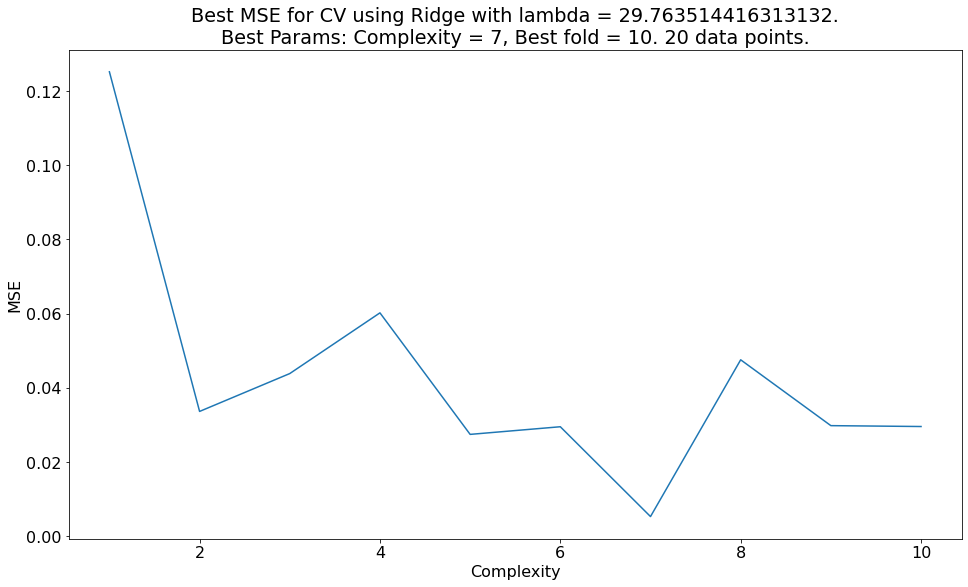

Number of datapoints 50
Best params: Folds = 10 and complexity = 6 with lambda = 0.03359818286283781. Best MSE: 0.014134356949698442


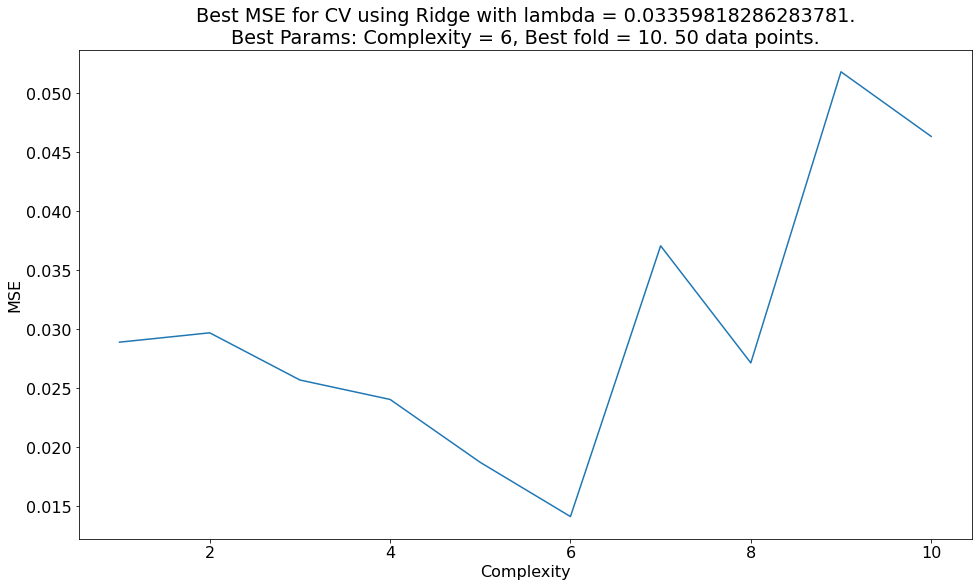

Number of datapoints 100
Best params: Folds = 7 and complexity = 6 with lambda = 0.0006951927961775605. Best MSE: 0.011146781522012839


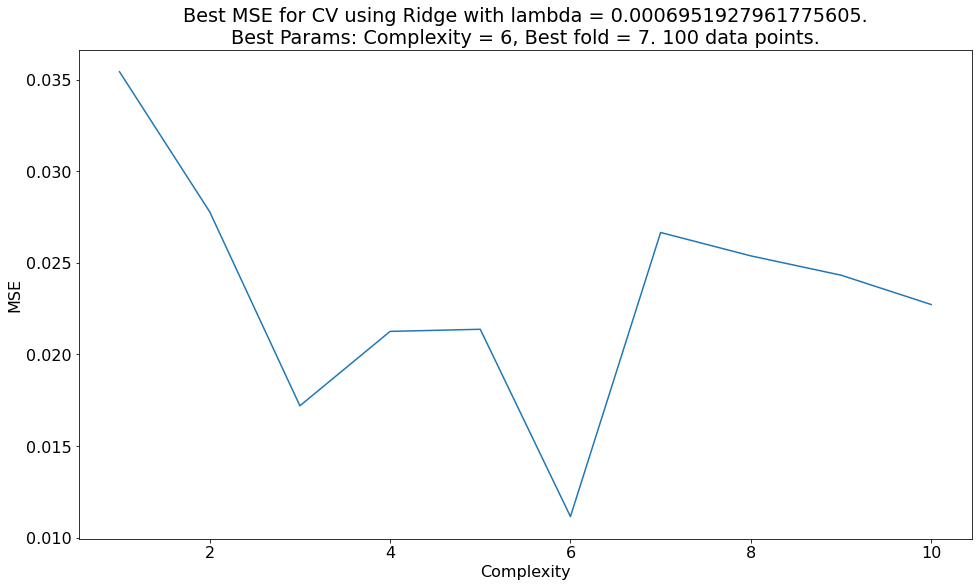

In [19]:
plot_lambda_dependency(Ridge)

# Run the above analysis

Number of datapoints 20
Best params: Folds = 10 and complexity = 7 with lambda = 29.763514416313132. Best MSE: 0.00524897582176721


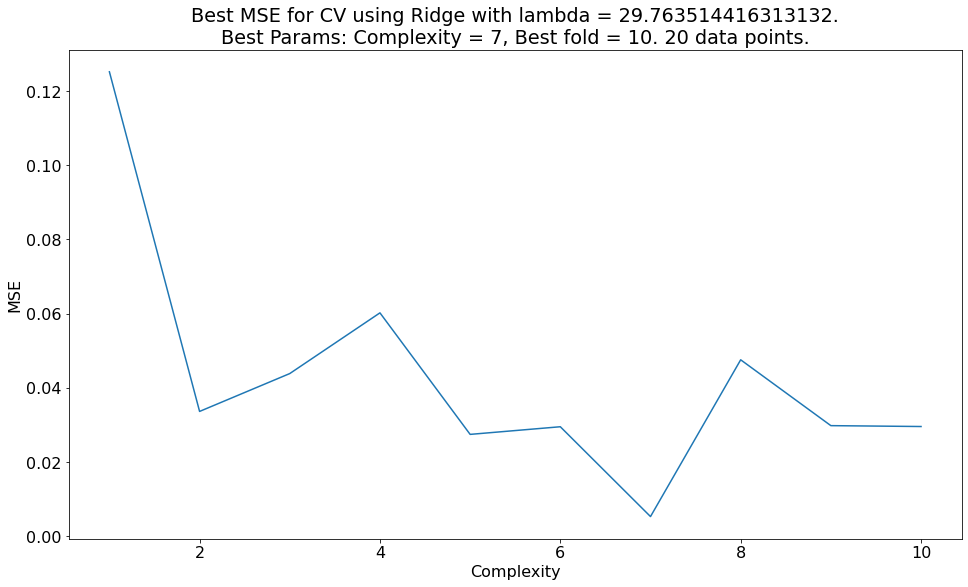

Number of datapoints 50
Best params: Folds = 10 and complexity = 6 with lambda = 0.03359818286283781. Best MSE: 0.014134356949698442


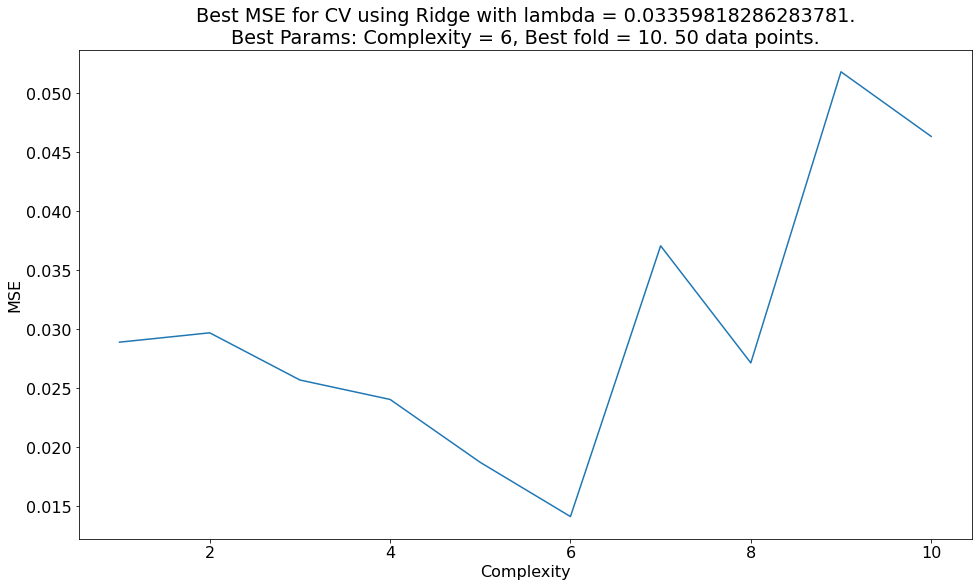

Number of datapoints 100
Best params: Folds = 7 and complexity = 6 with lambda = 0.0006951927961775605. Best MSE: 0.011146781522012839


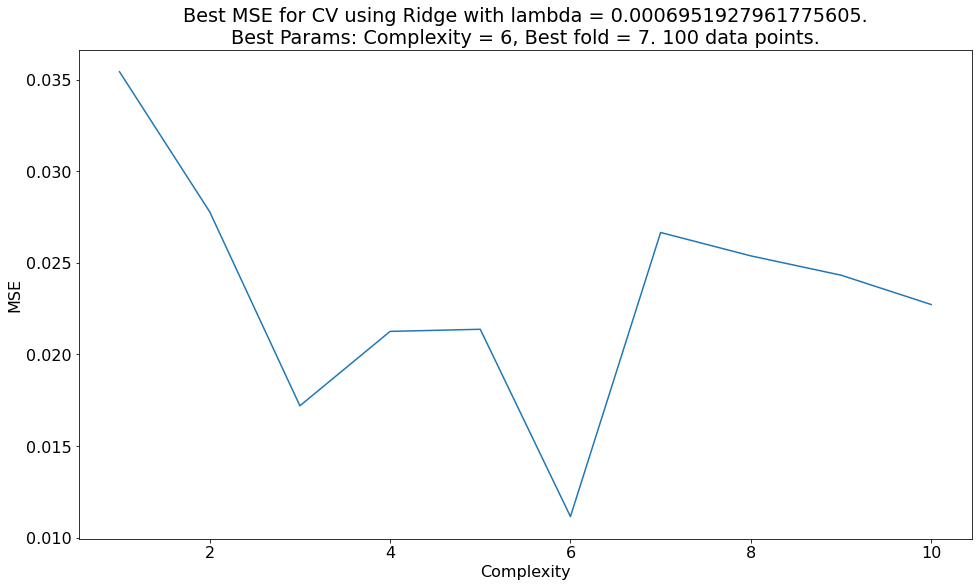

In [20]:
mse_aggregate, lambdas = cv_analysis_ridge_lasso(Ridge, nlambdas = 20, max_complexity = 10, min_fold = 5, max_fold = 10)

## Lets see how the regularization term affects the MSE and R2

In [21]:
def check_error_by_lambda(reg_func, complexity = 20):
    lambdas = np.logspace(-5,2, 30)
    
    all_mse = np.zeros((len(lambdas), complexity))
    all_r2 = np.zeros((len(lambdas), complexity))
    for i, lamb in enumerate(lambdas):
        mse, r2 = simple_mse_and_r2_by_complexity(reg_func, num_points = 1000, lamb = lamb, complexity = complexity, noise = 0.1, plot_mse = False, plot_r2 = False, return_losses = True)
        all_mse[i,:] = np.array(mse)
        all_r2[i,:] = np.array(r2)
        
    for comp in range(1, complexity):
        plt.figure(figsize = (16,9))
        plt.tight_layout()
        plt.plot(np.log10(lambdas), all_mse[:, comp], label = 'MSE per lambda')
        plt.xlabel('log10(lambda)')
        plt.ylabel('mse')
        plt.title(f"MSE per lambda for {reg_func.__name__} for complexity {comp}")
        plt.legend()
        plt.show()
        plt.figure(figsize = (16,9))
        plt.tight_layout()
        plt.plot(np.log10(lambdas), all_r2[:, comp], label = 'MSE per lambda')
        plt.xlabel('log10(lambda)')
        plt.ylabel('r2')
        plt.title(f"R2 per lambda for {reg_func.__name__} for complexity {comp}")
        plt.legend()
        plt.show()

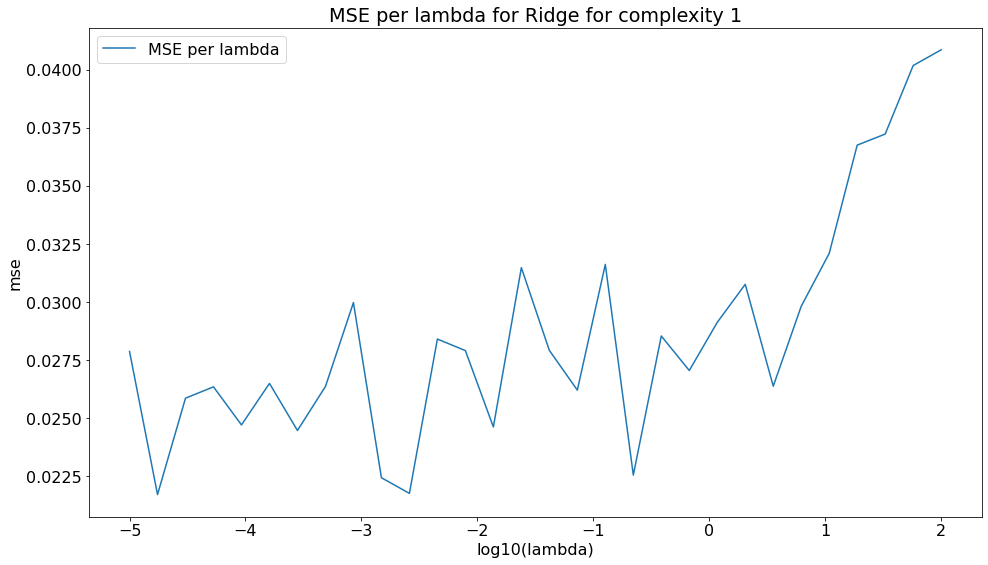

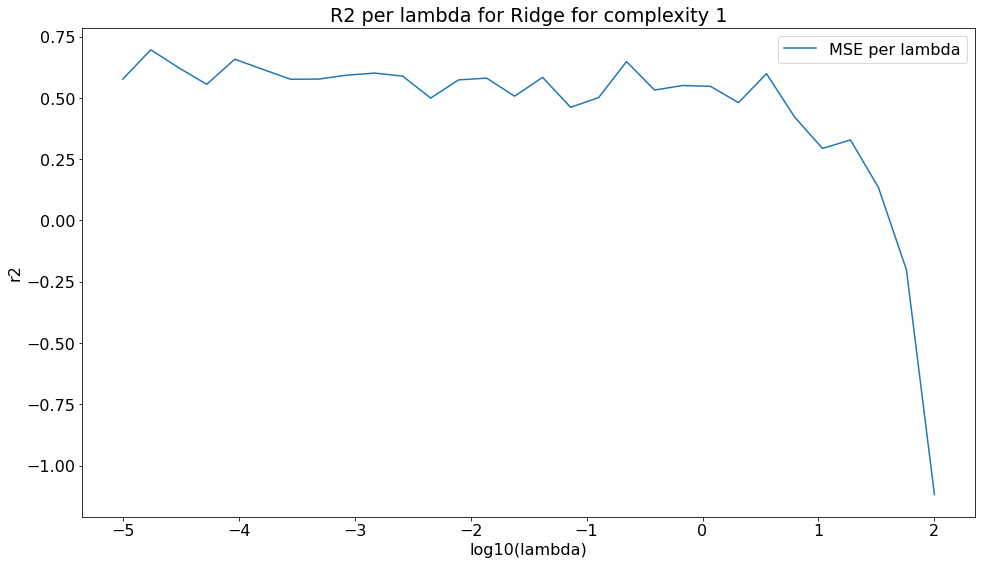

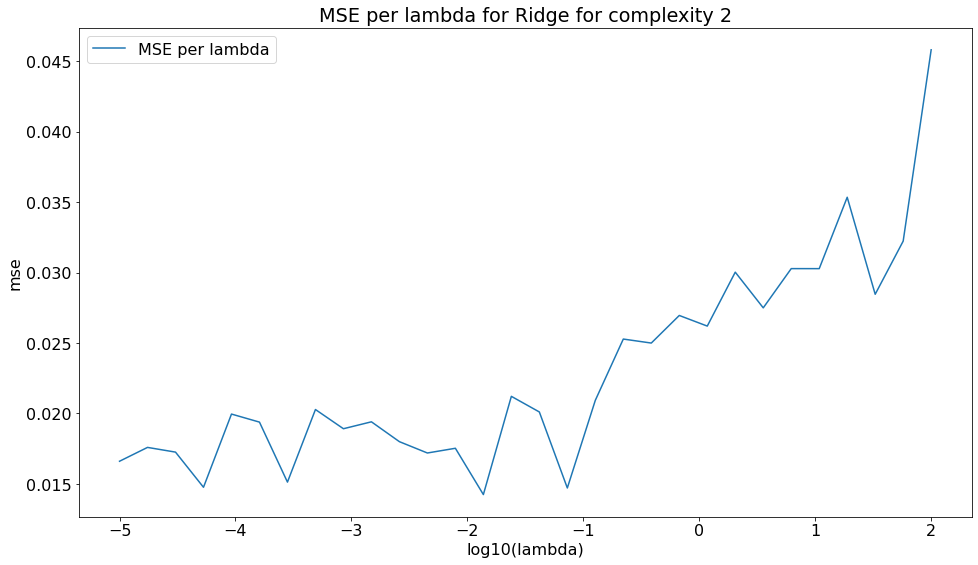

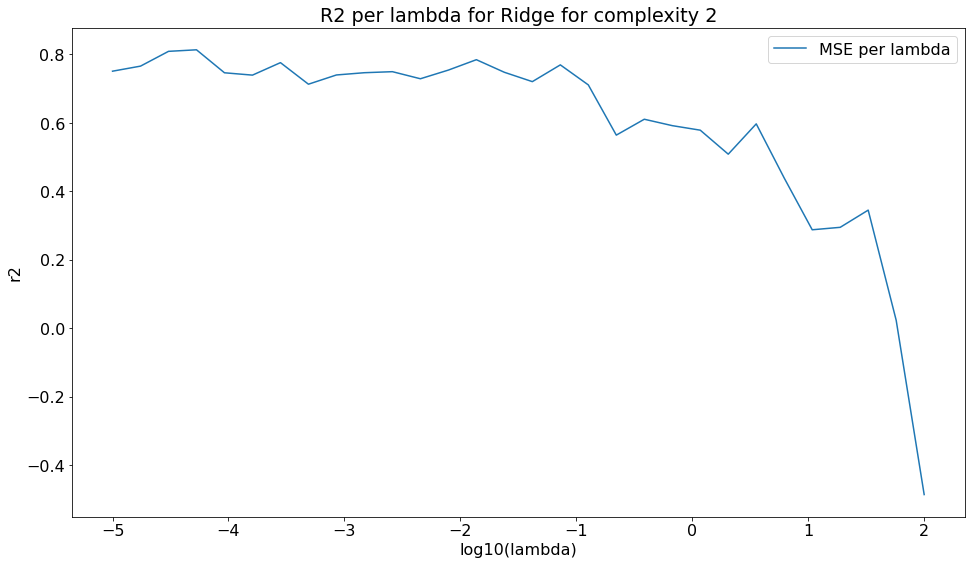

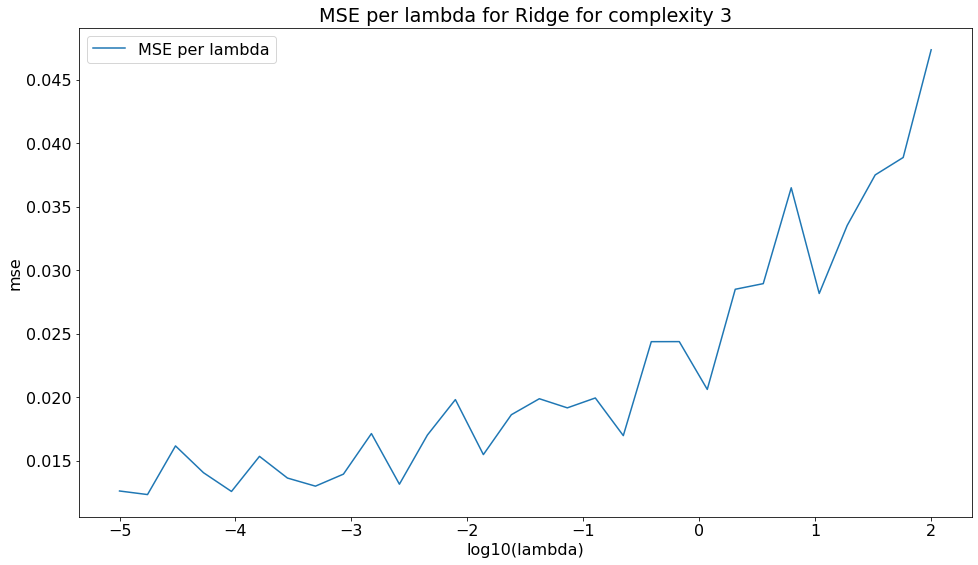

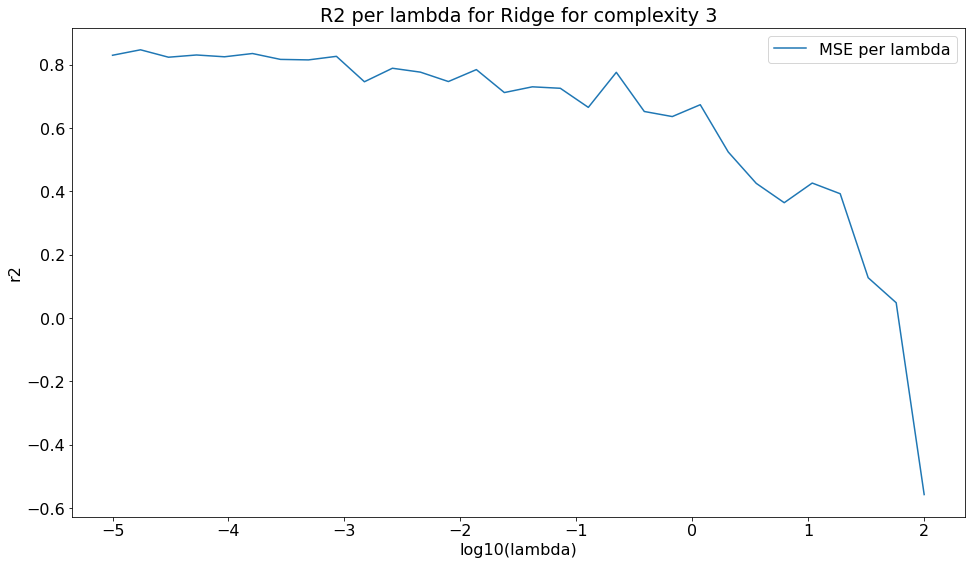

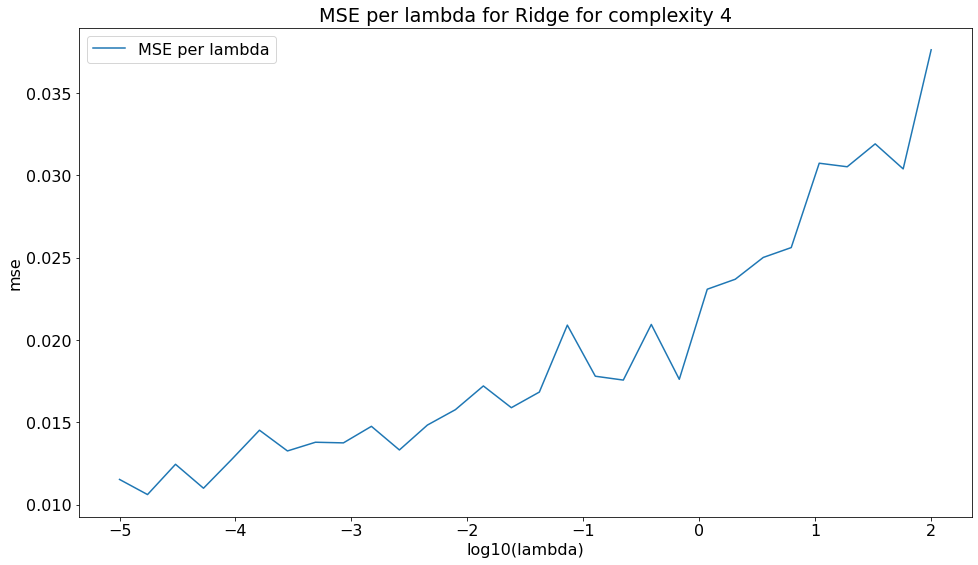

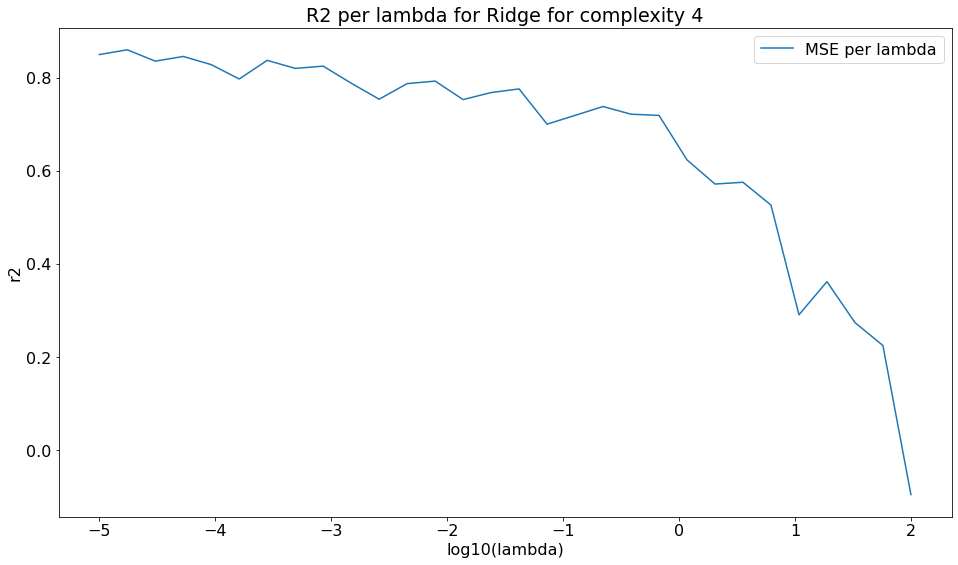

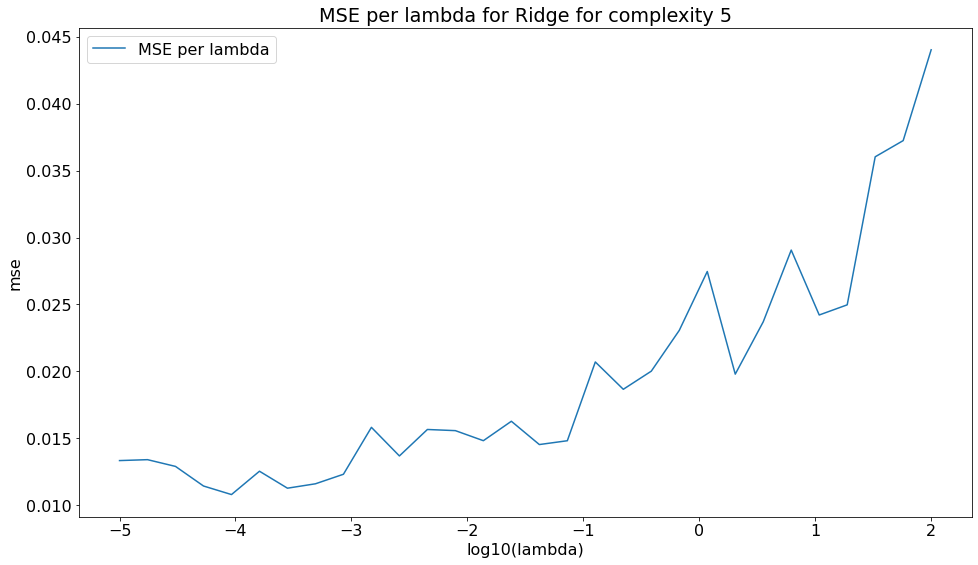

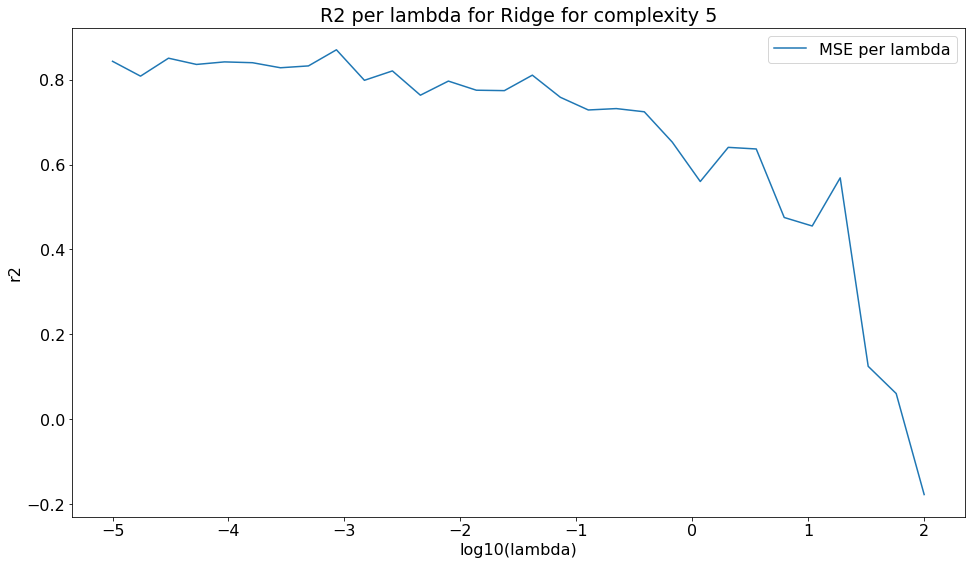

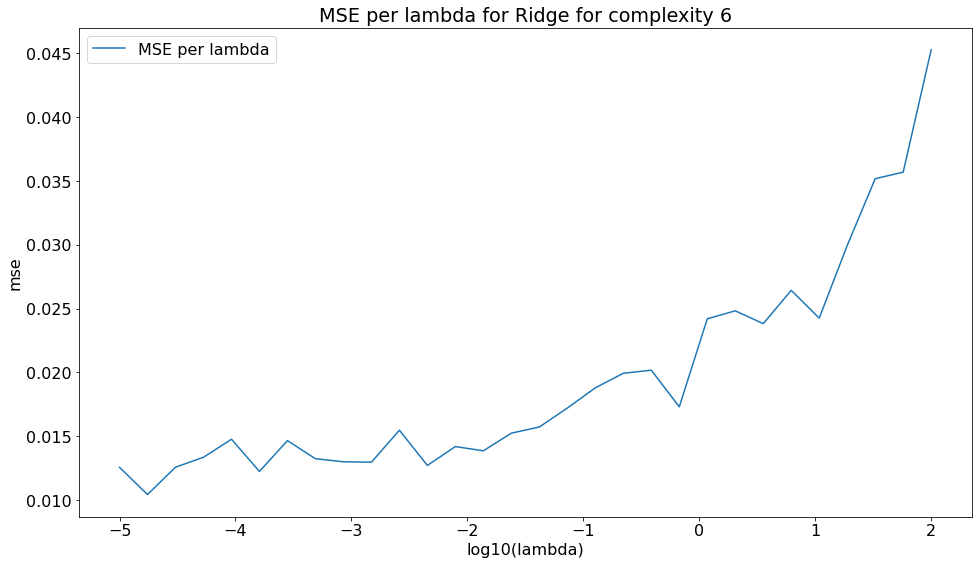

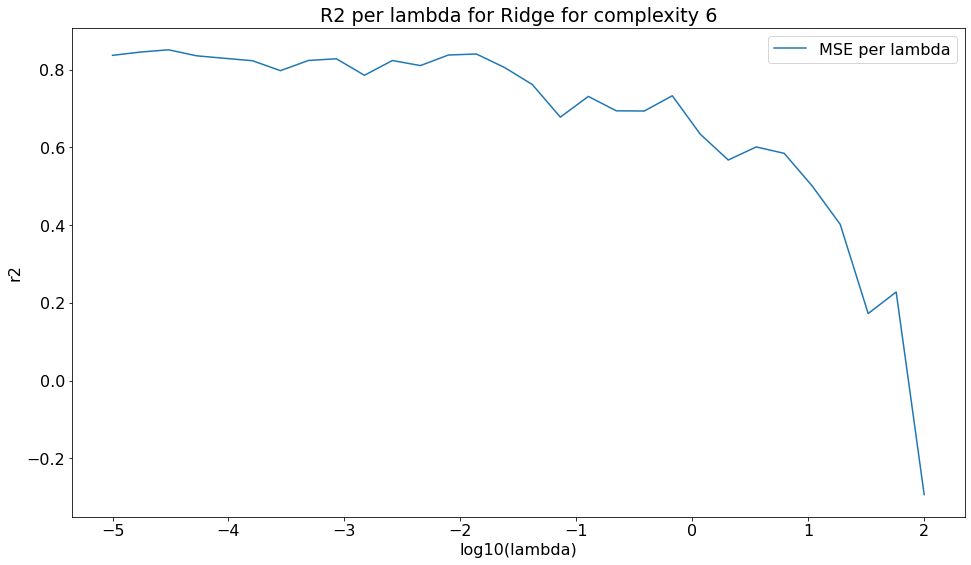

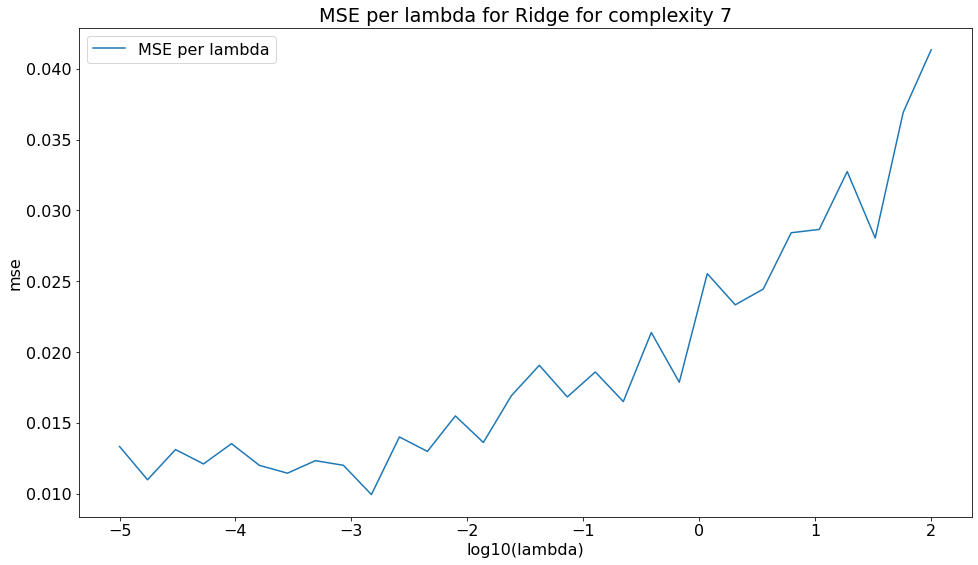

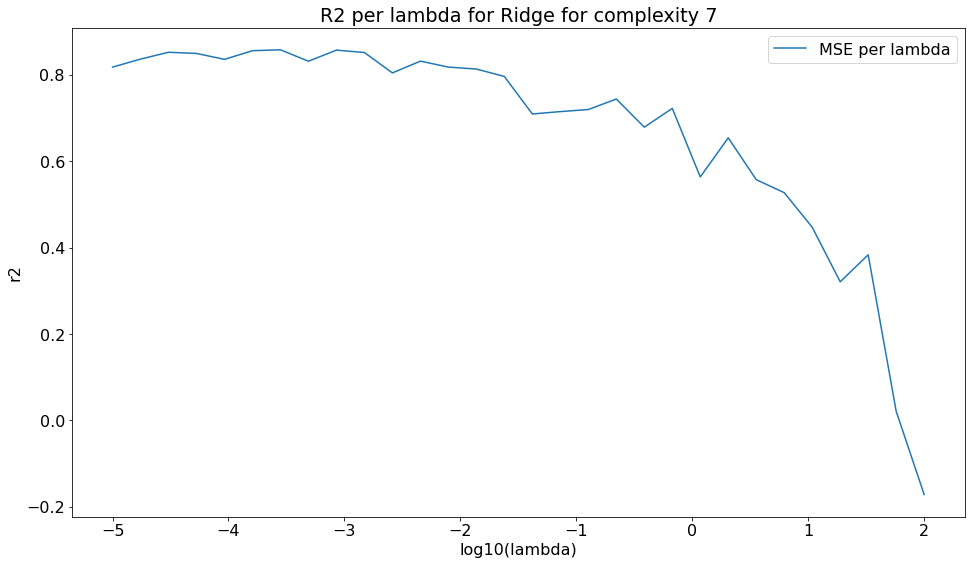

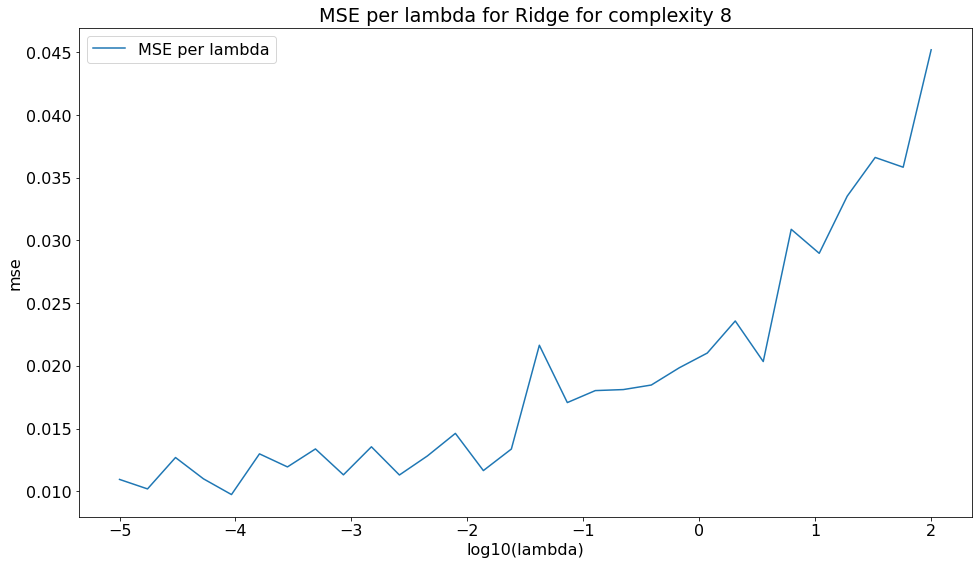

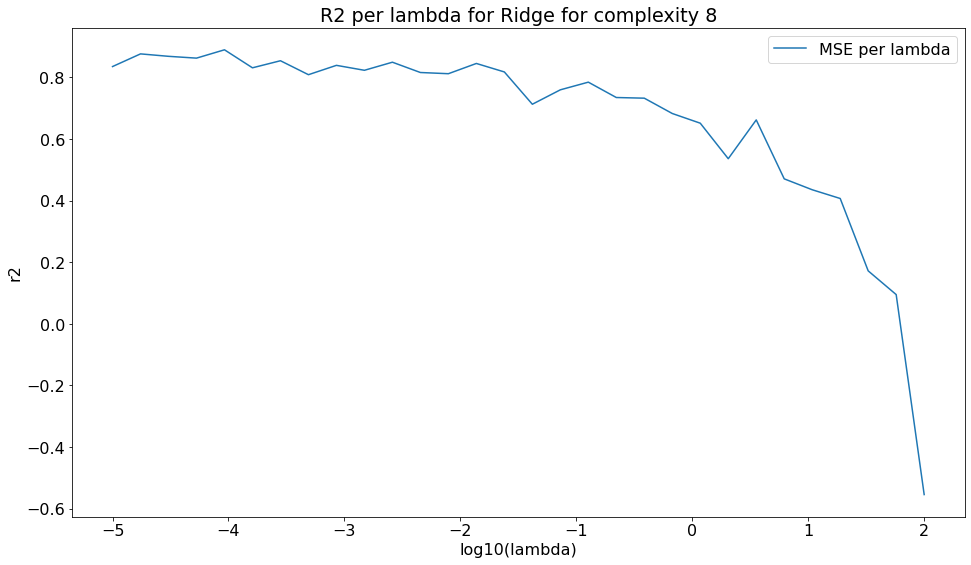

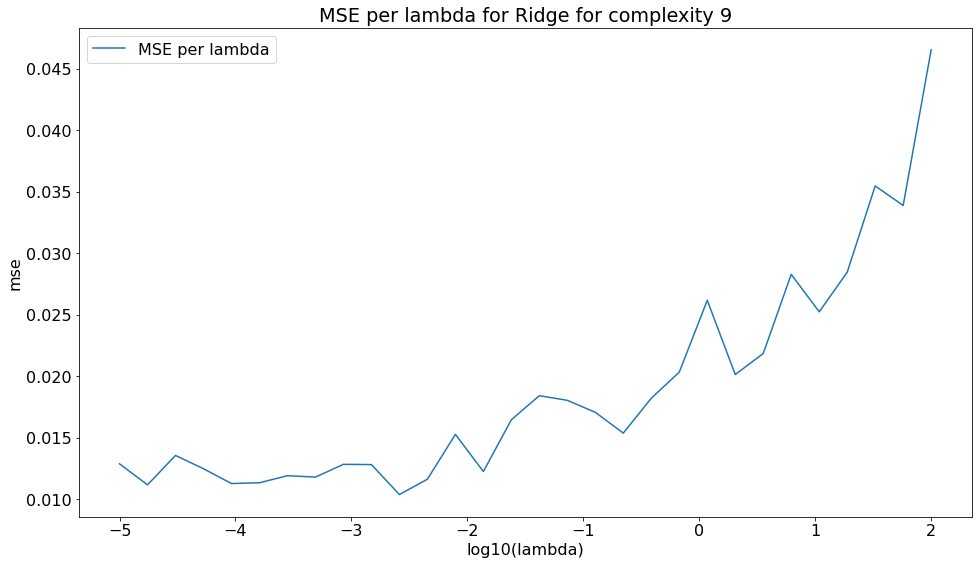

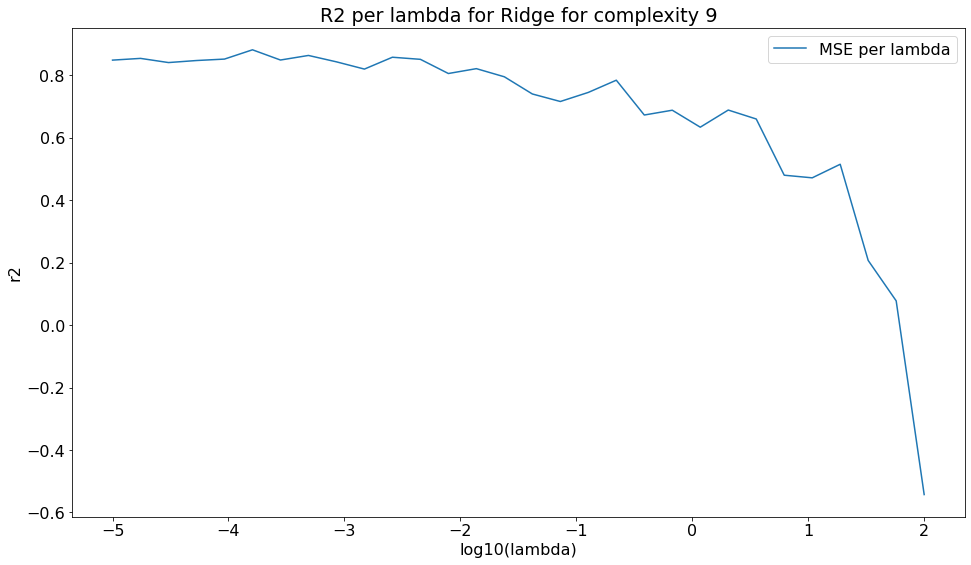

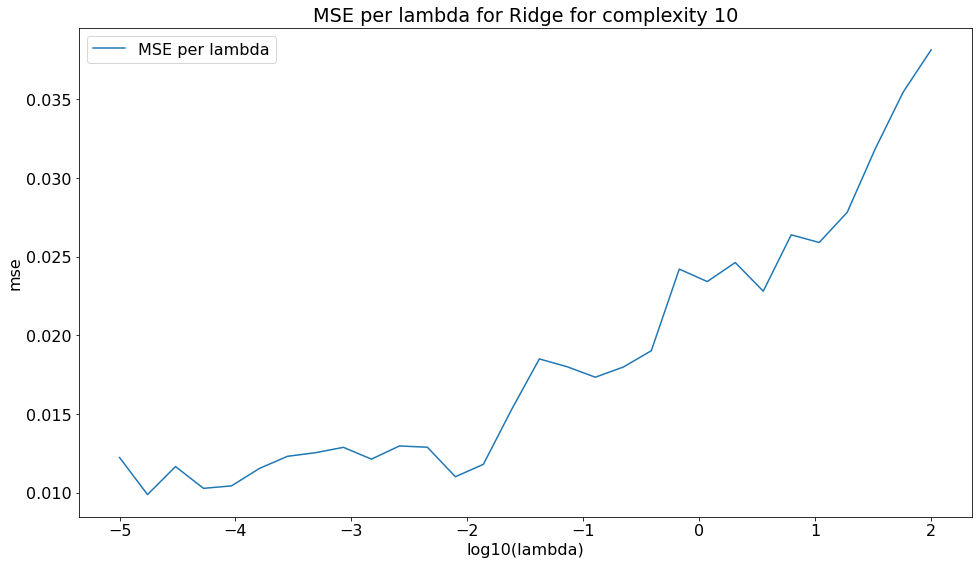

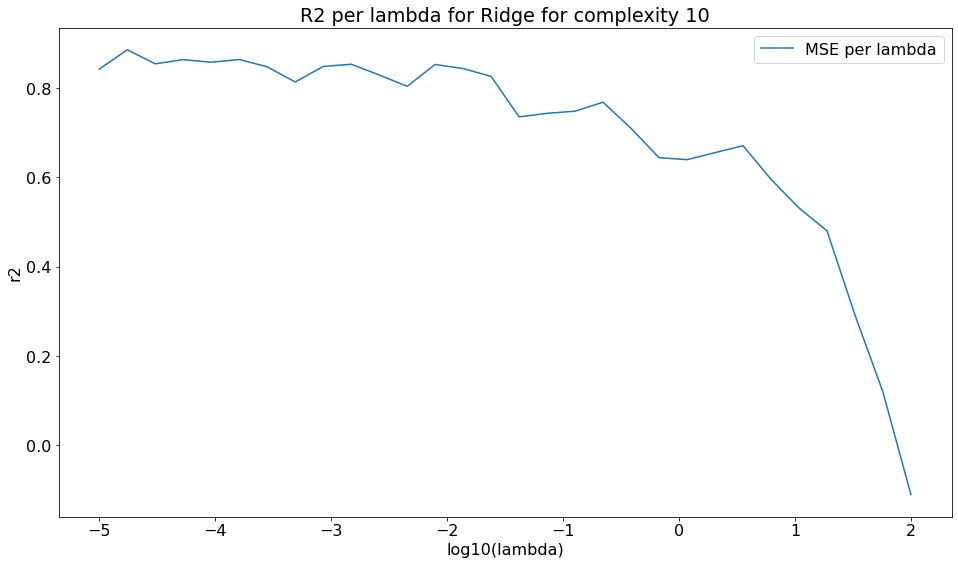

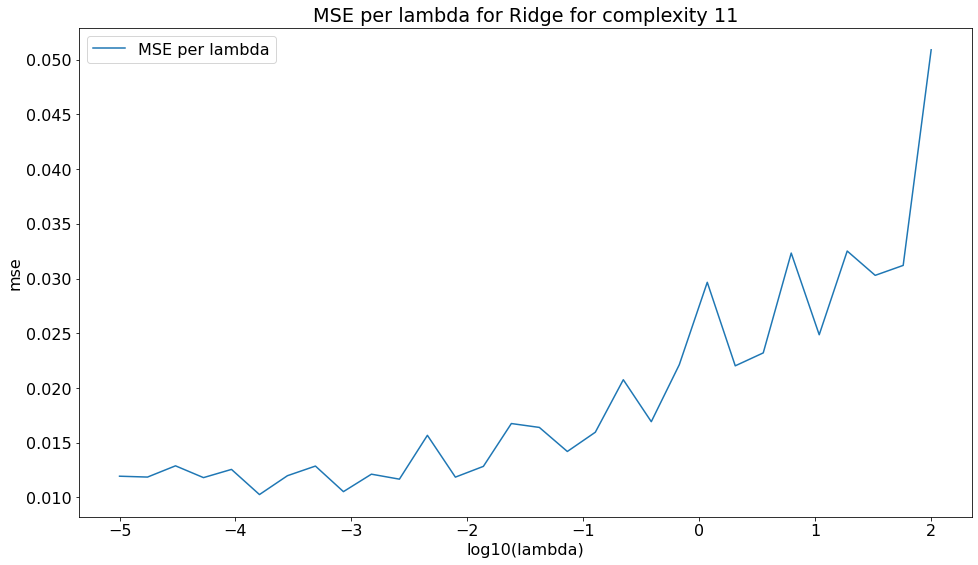

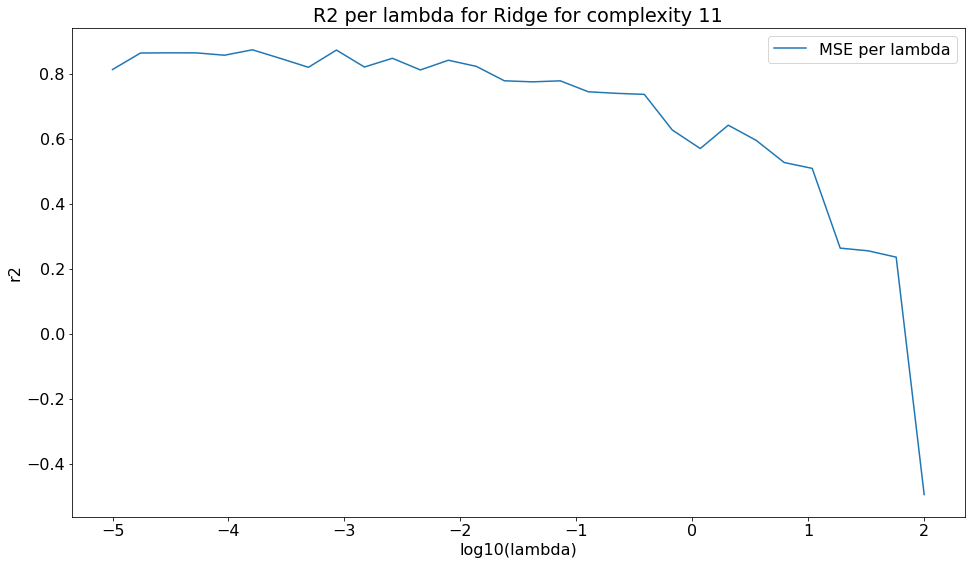

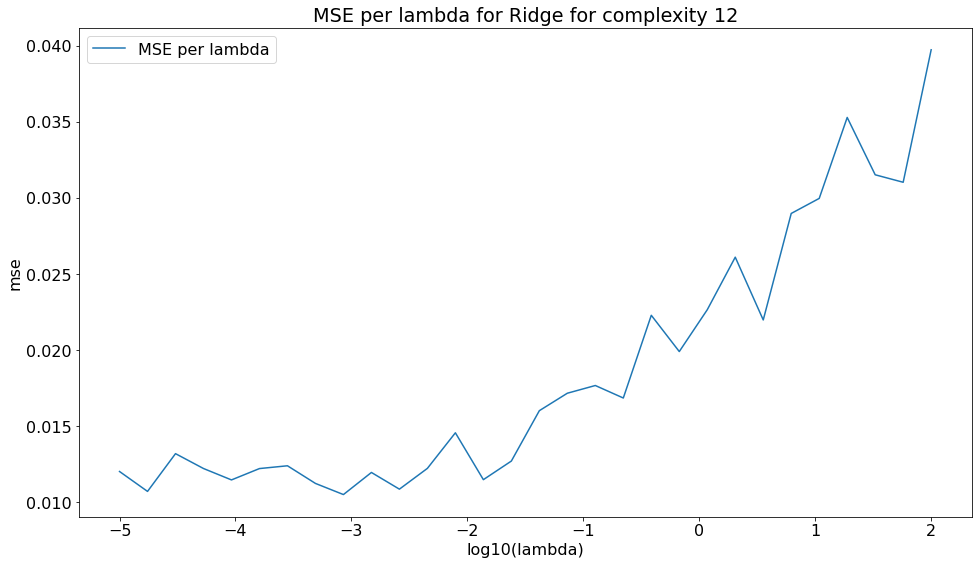

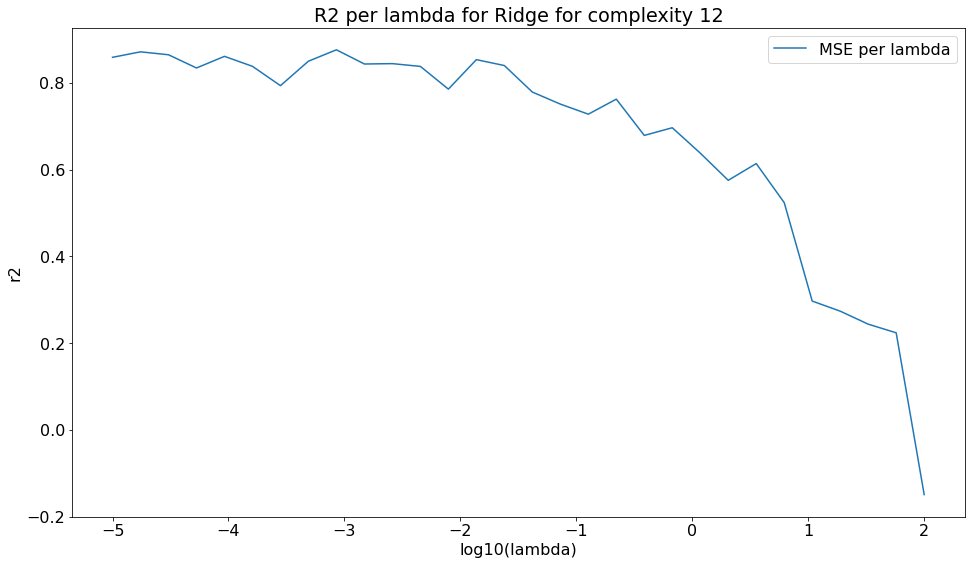

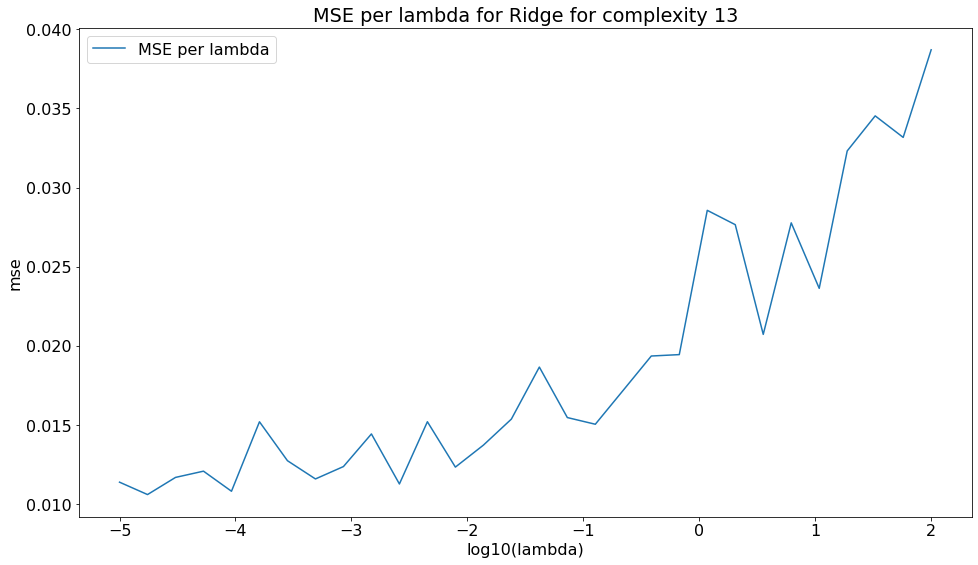

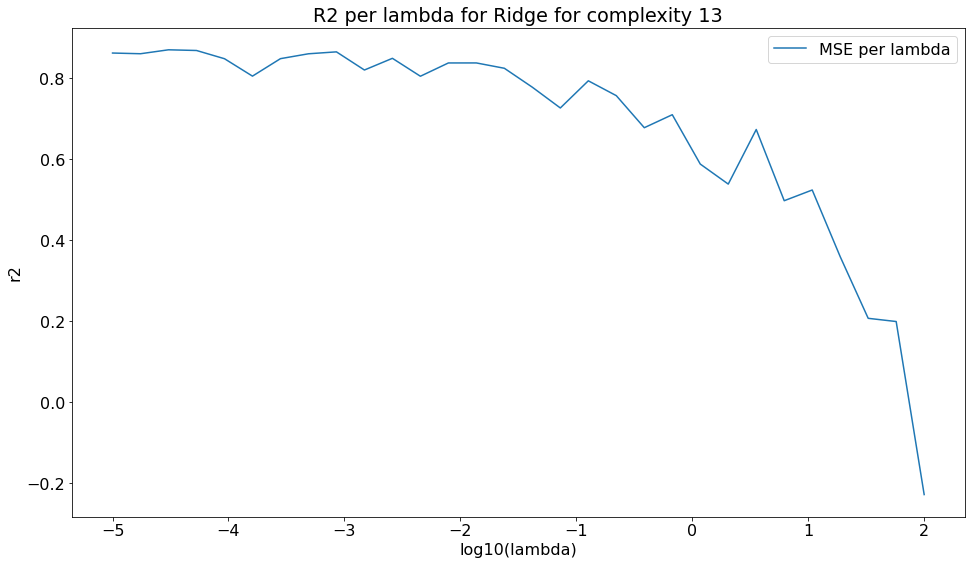

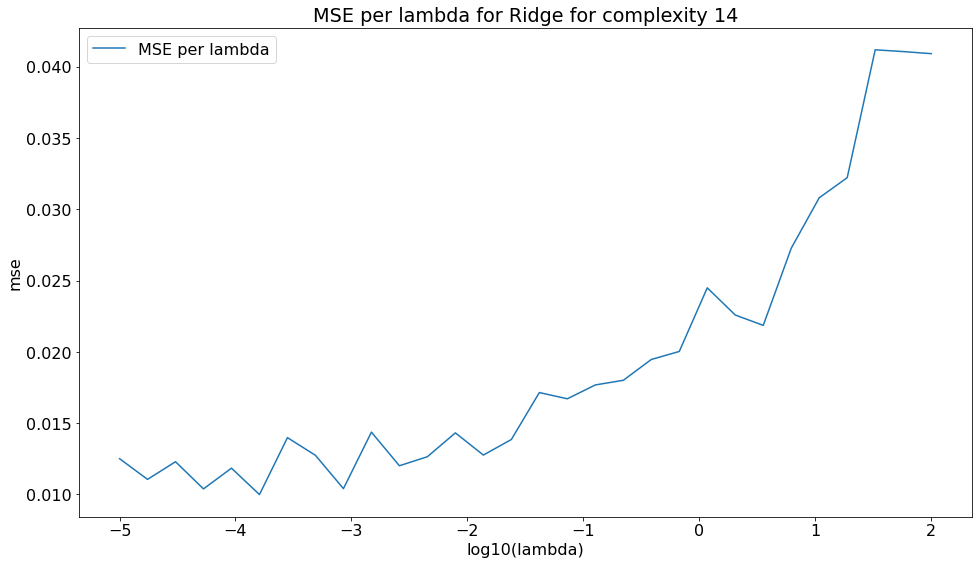

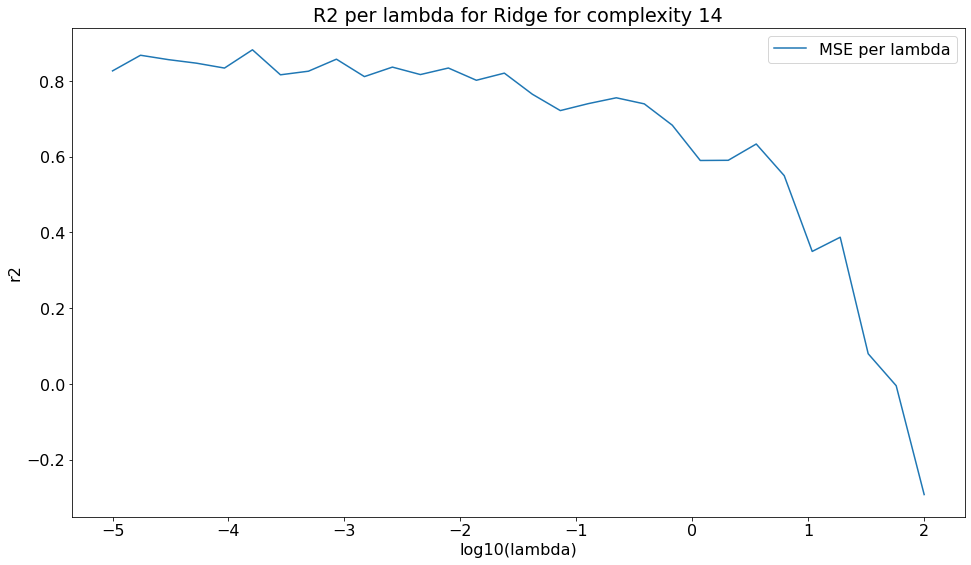

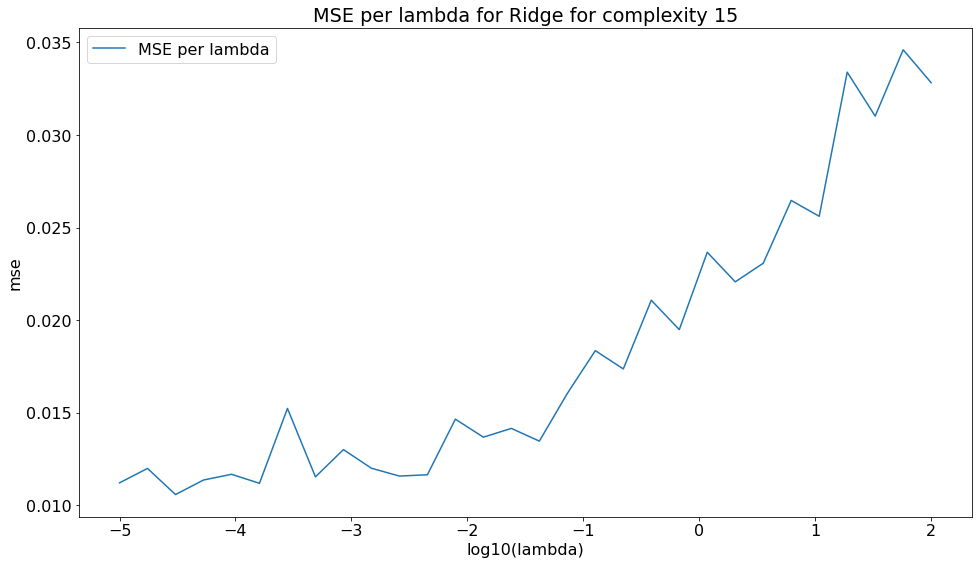

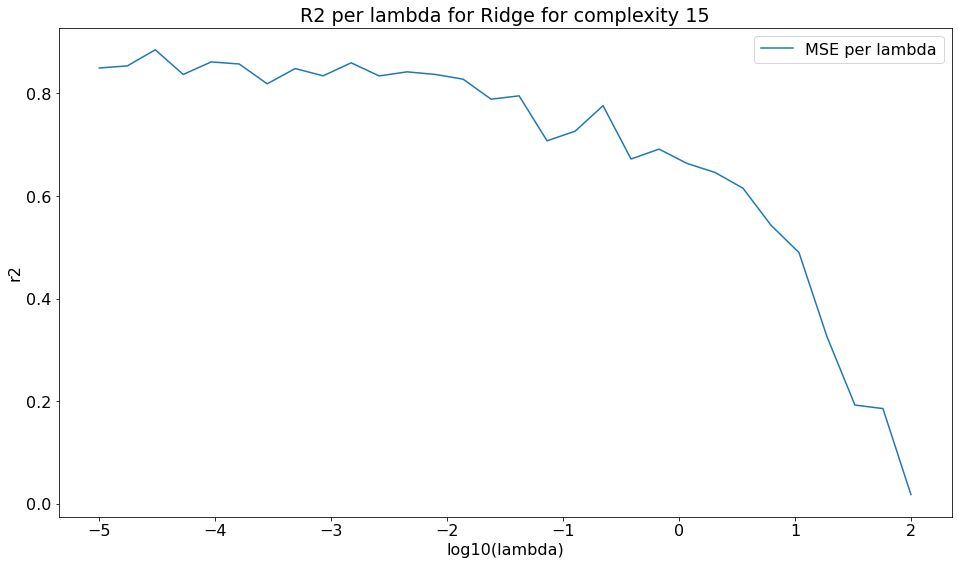

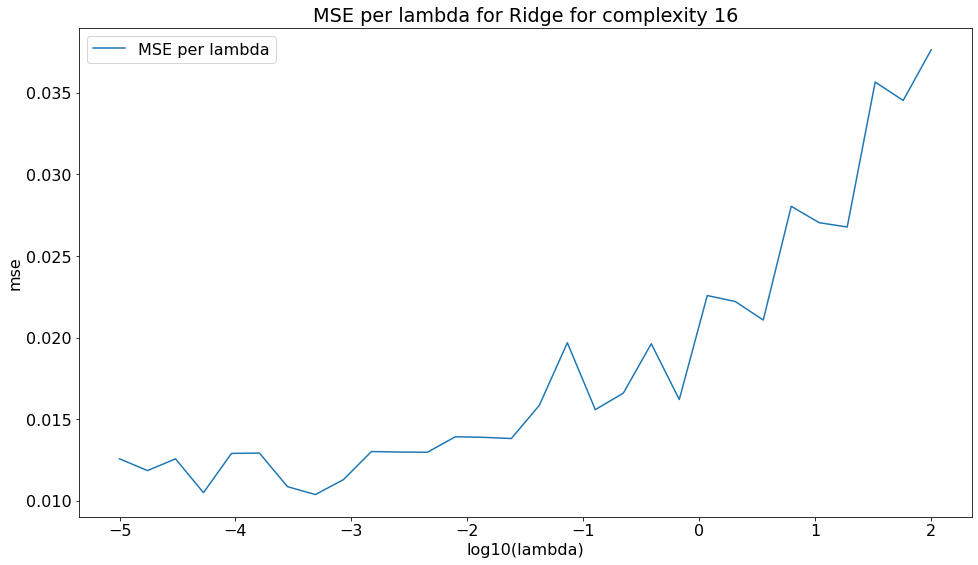

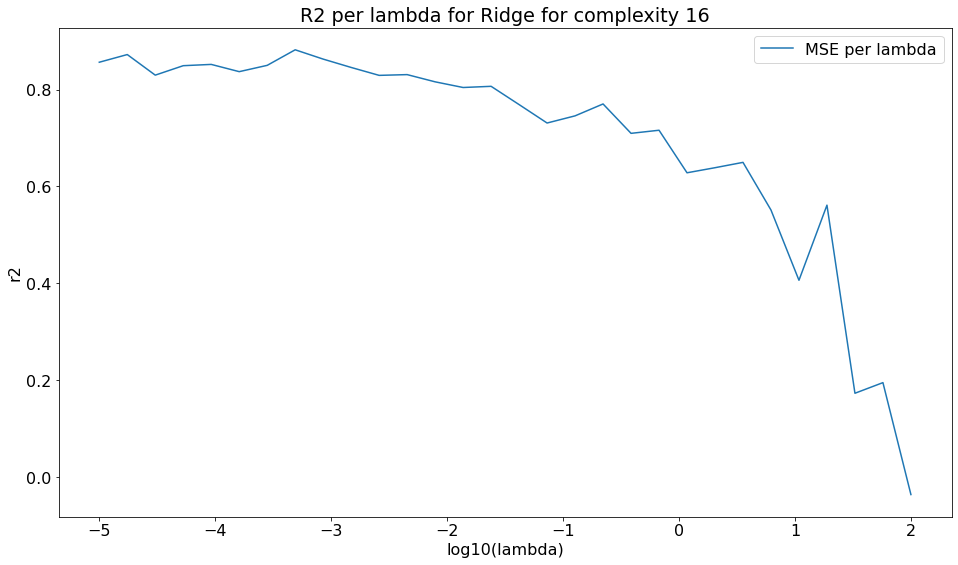

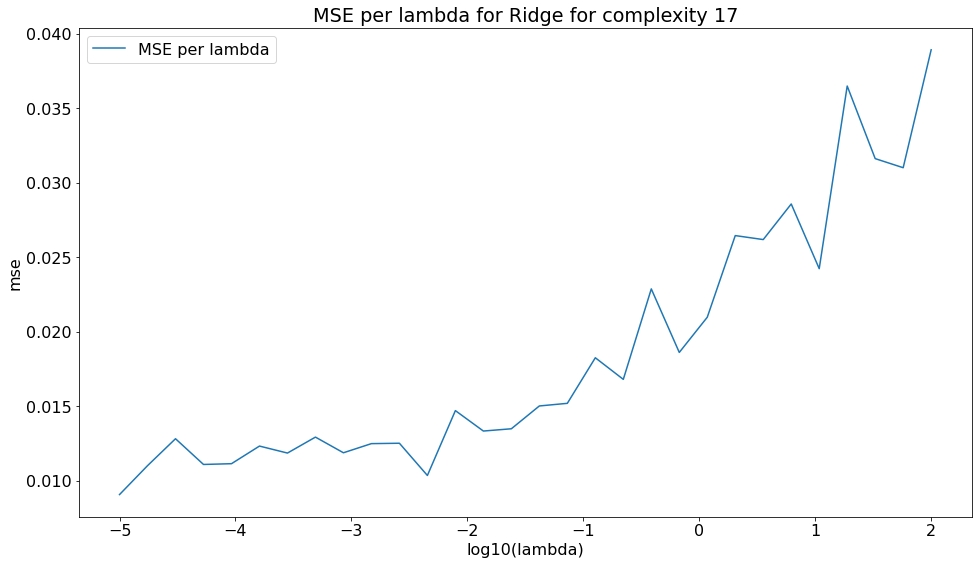

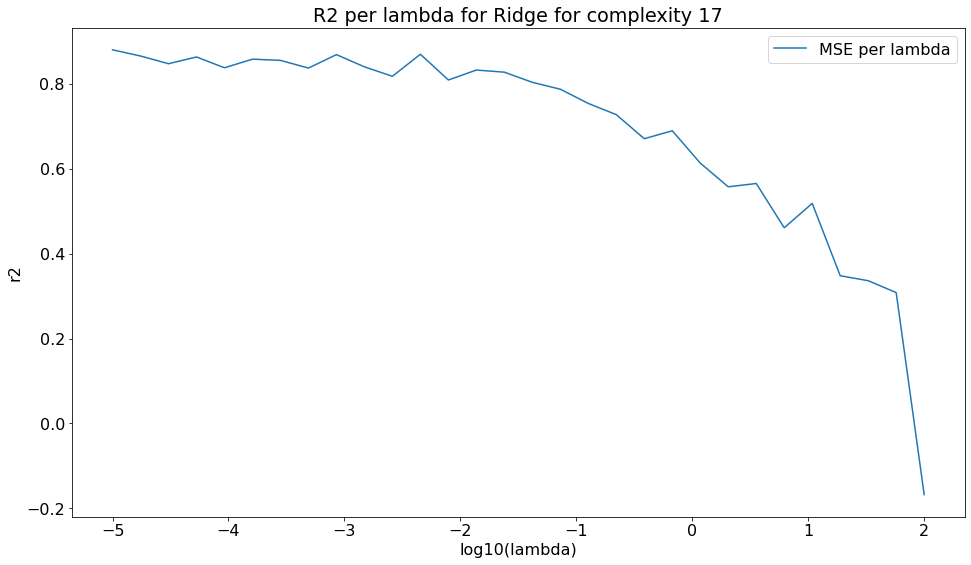

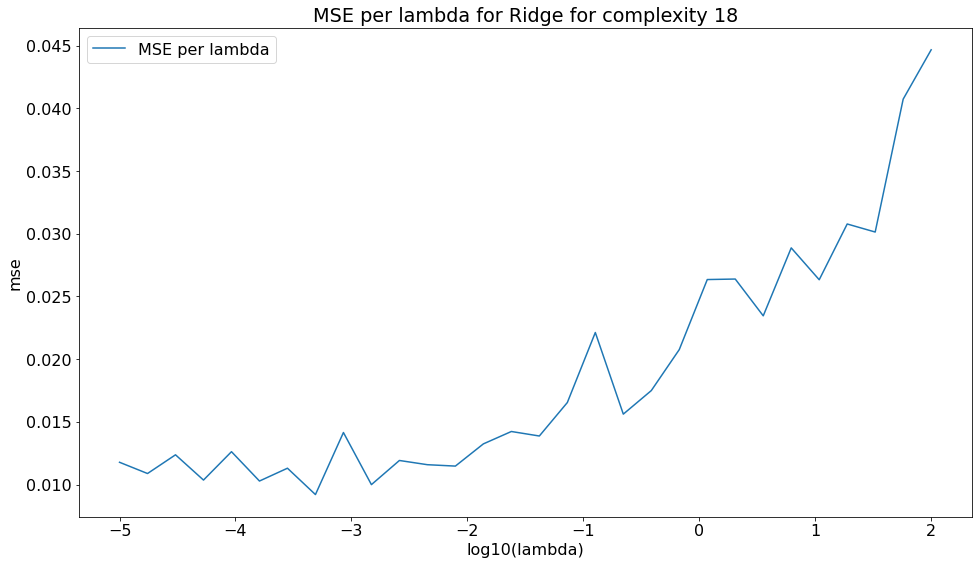

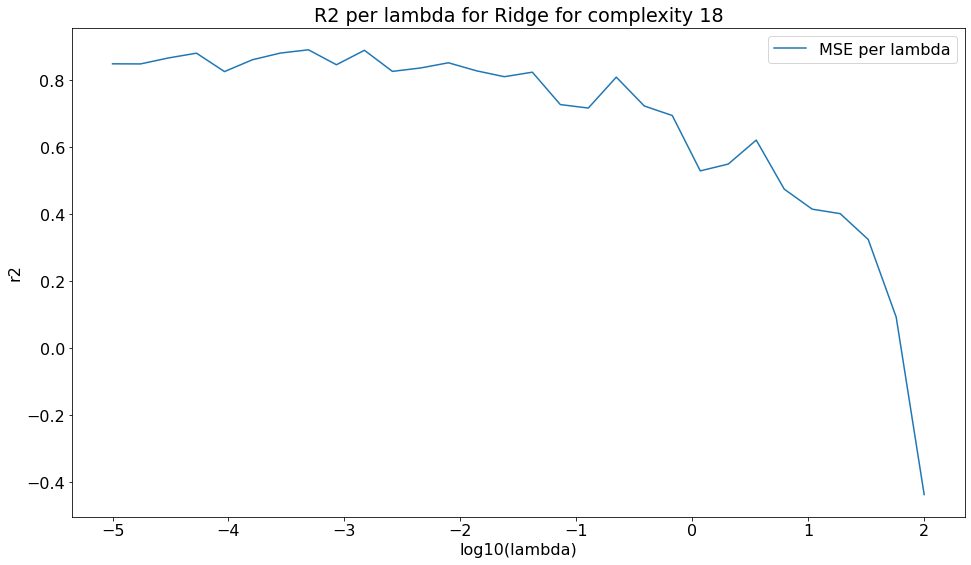

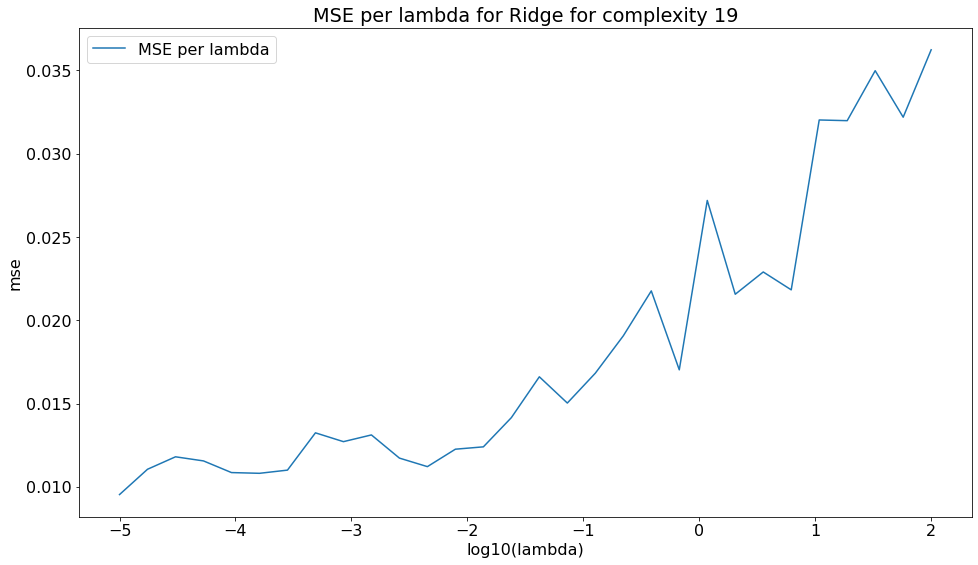

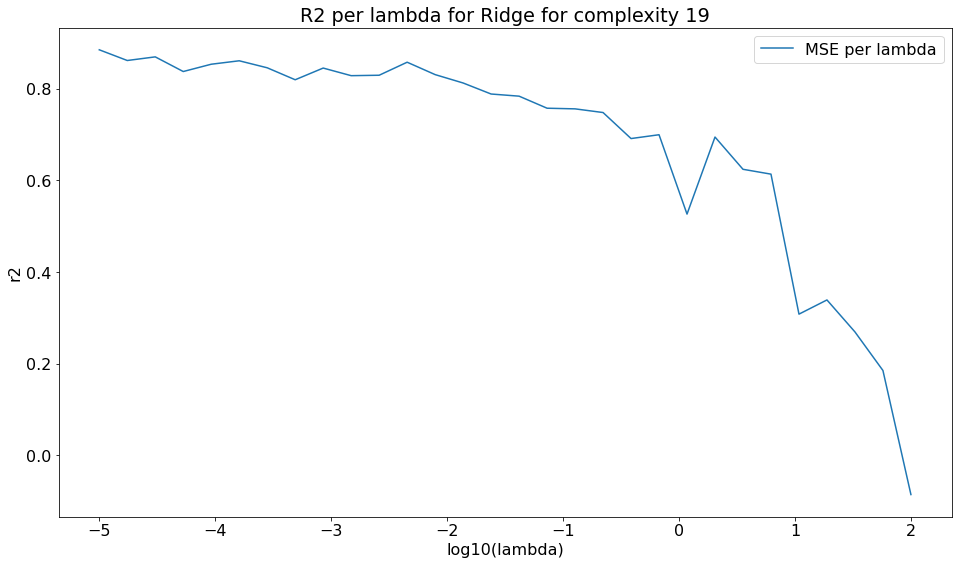

In [22]:
check_error_by_lambda(Ridge)

# Exercise 5 - Lasso

In [23]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def Lasso(x,y, lamb):
    """
    A hybrid implementation of SKlearn and our custom code.
    We only use the coeficients from SKlearn, so that we can reuse our own code.
    """
    lasso = linear_model.Lasso(fit_intercept = False, alpha = lamb, max_iter = 1000, tol = 0.05)
    lasso.fit(x,y)
    return lasso.coef_

## Bootstrap Lasso vs. Least Square Bias variance trade off

Best lambda: 228.54638641349885  for number of datapoints: 20
Best global: [0.00215408] at complexity: [2.] for number of datapoints: 20, num_bootstraps = 20, test_split = [0.2]


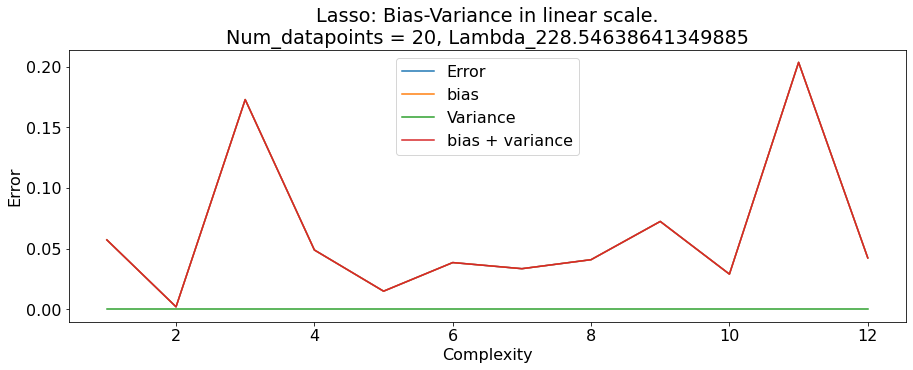

Best global: 0.02288523633859585 at complexity: 2 for number of datapoints: 20, num_bootstraps = 20, test_split = 0.2


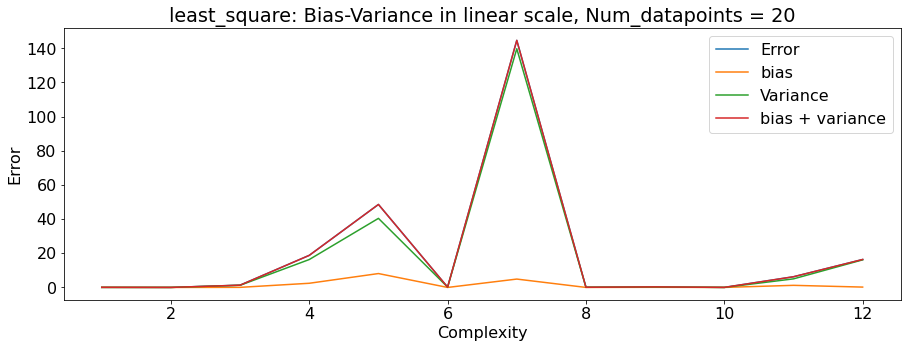

Best lambda: 0.00025719138090593444  for number of datapoints: 50
Best global: [0.01066053] at complexity: [5.] for number of datapoints: 50, num_bootstraps = 50, test_split = [0.2]


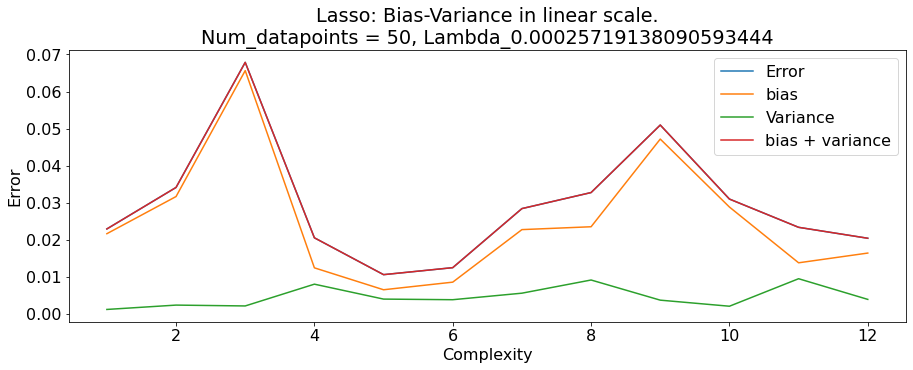

Best global: 0.029517881202547596 at complexity: 1 for number of datapoints: 50, num_bootstraps = 50, test_split = 0.2


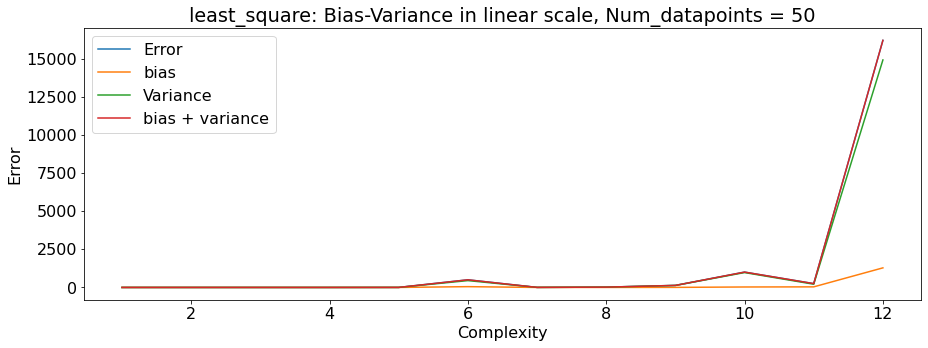

Best lambda: 0.0001  for number of datapoints: 100
Best global: [0.00894647] at complexity: [6.] for number of datapoints: 100, num_bootstraps = 100, test_split = [0.2]


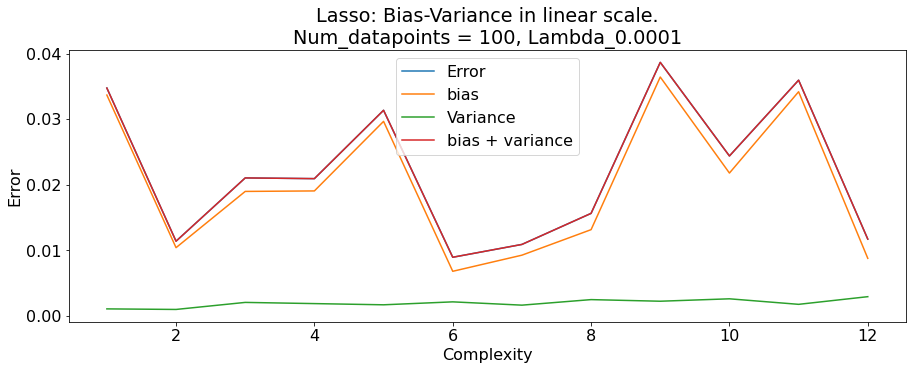

Best global: 0.015525194603762952 at complexity: 3 for number of datapoints: 100, num_bootstraps = 100, test_split = 0.2


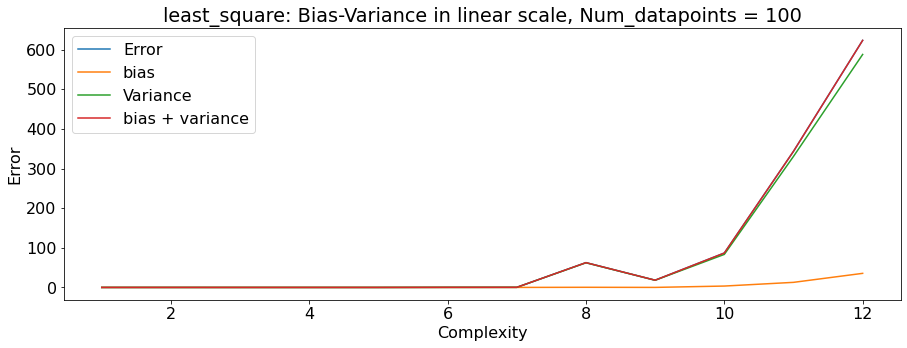

In [24]:
def run_bootstrap_comparison_ols_lasso():
    for num_points in [20, 50, 100]:
        run_bias_variance_bootstrap_ridge_or_lasso(Lasso, data_point_list = [num_points], nlambdas = 40, save_fig = True)
        run_bias_variance_bootstrap(least_square, points = [num_points], save_fig = True)
        
run_bootstrap_comparison_ols_lasso()

# Cross validation 

Number of datapoints 20
Best params: Folds = 9 and complexity = 3 with lambda = 1.623776739188721. Best MSE: 0.007536058037403003


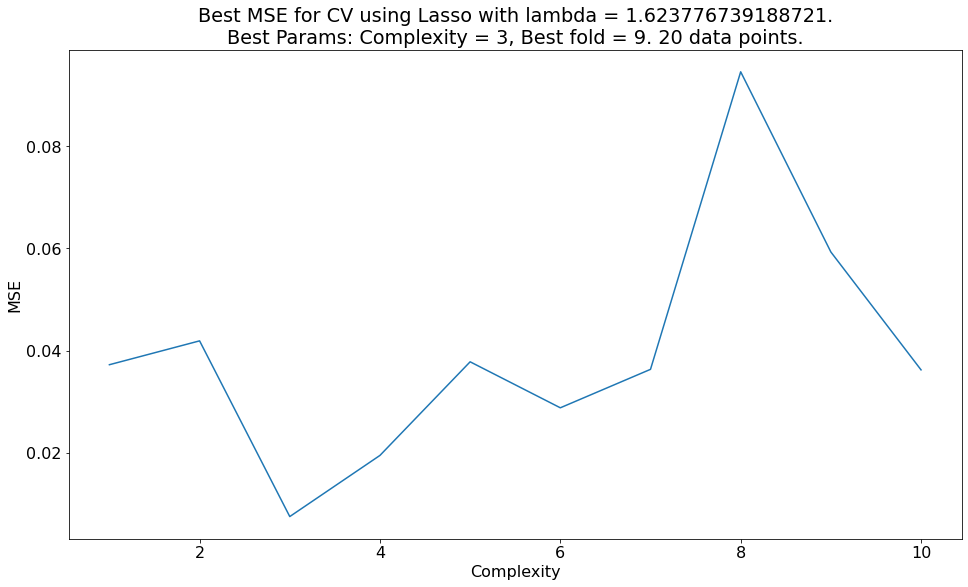

Number of datapoints 50
Best params: Folds = 7 and complexity = 5 with lambda = 0.00026366508987303583. Best MSE: 0.01606803047795357


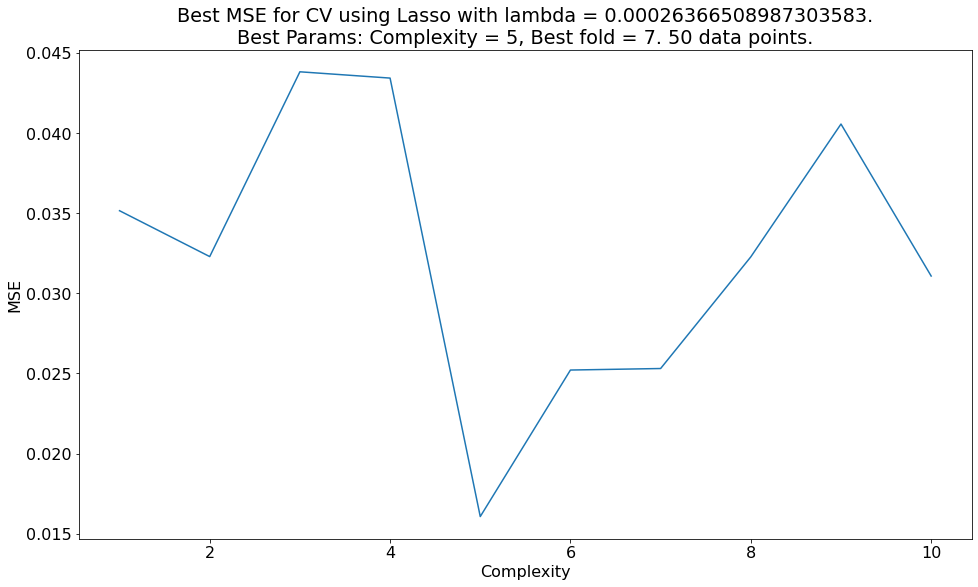

Number of datapoints 100
Best params: Folds = 6 and complexity = 5 with lambda = 0.0001. Best MSE: 0.015418925467729138


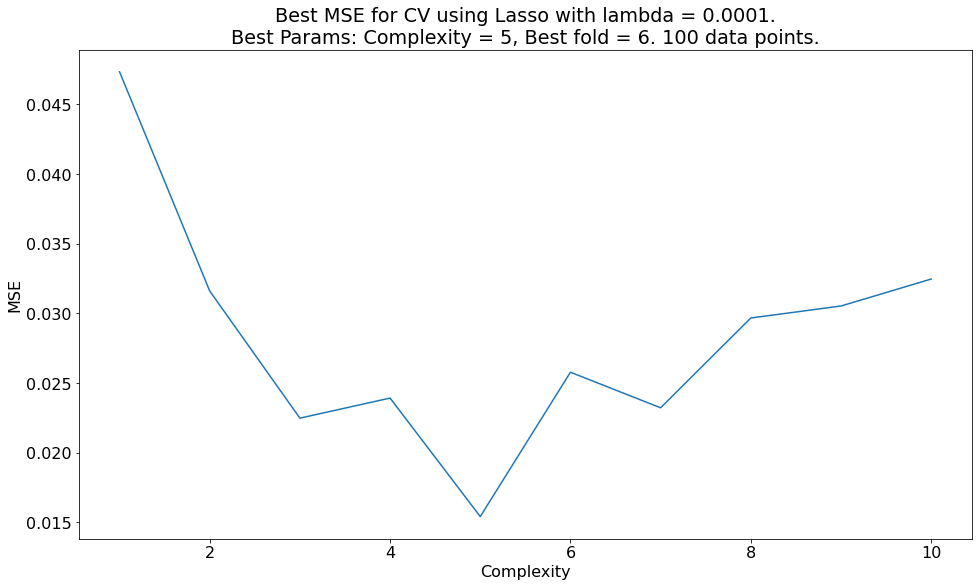

In [25]:
mse_aggregate, lambdas = cv_analysis_ridge_lasso(Lasso, nlambdas = 20, max_complexity = 10, min_fold = 5, max_fold = 10)

# Again, let's see how lambda affect MSE with Lasso

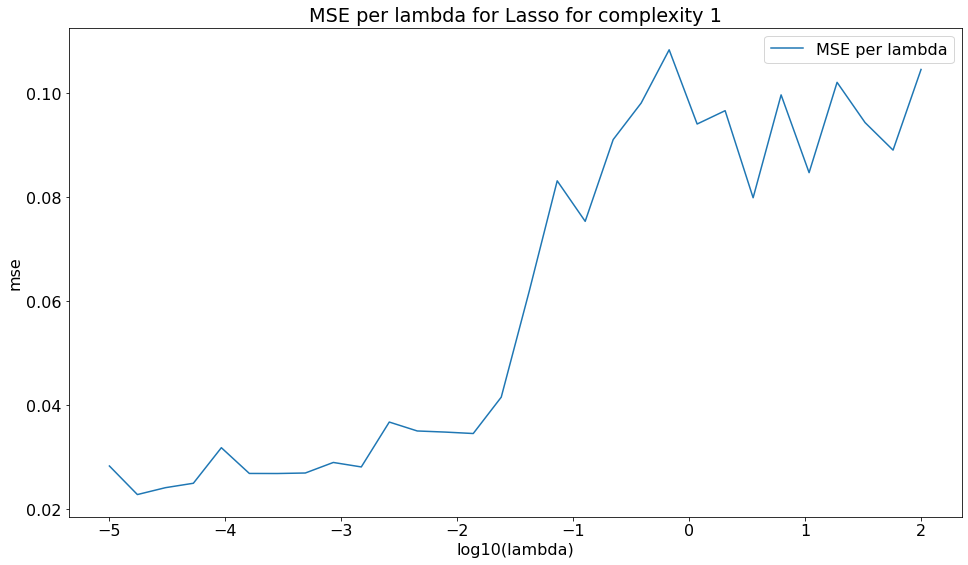

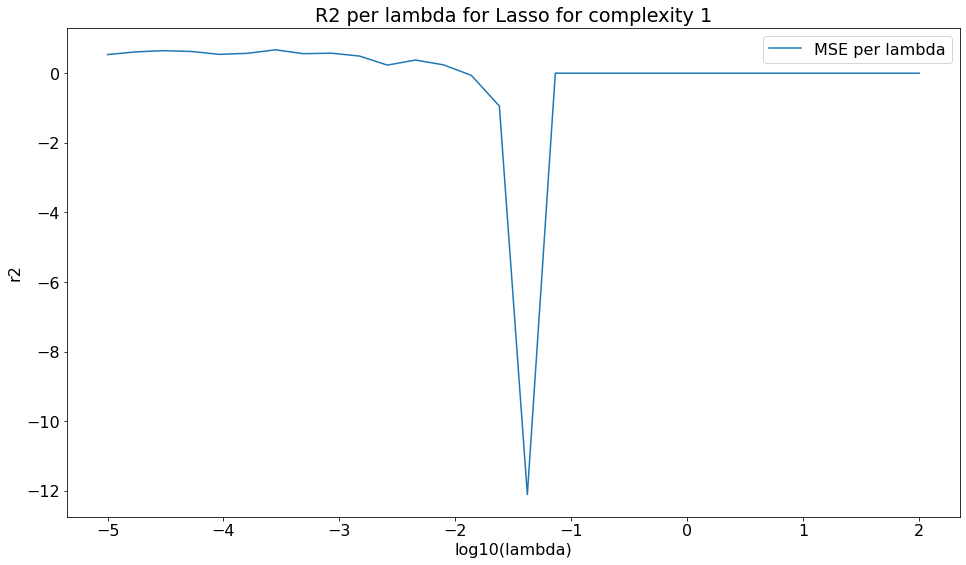

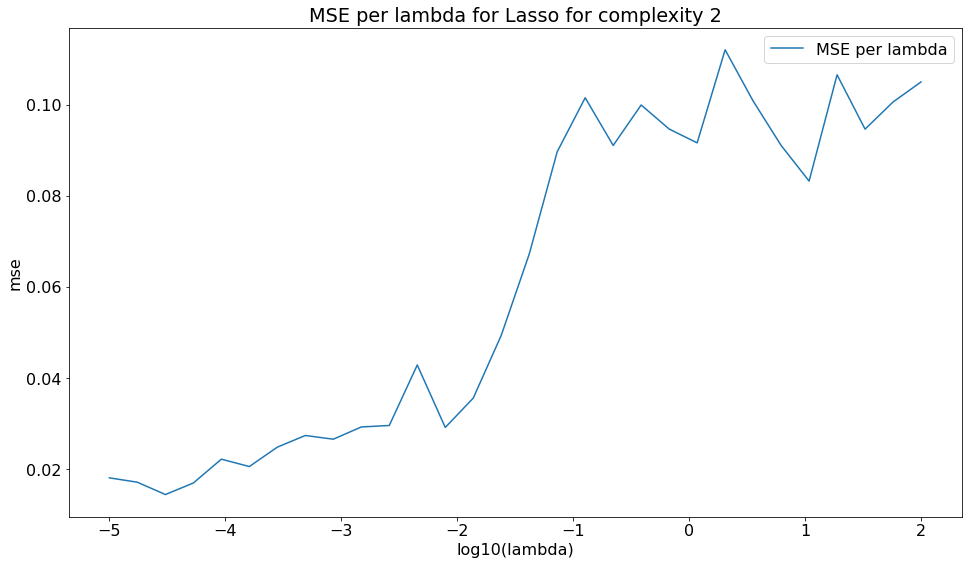

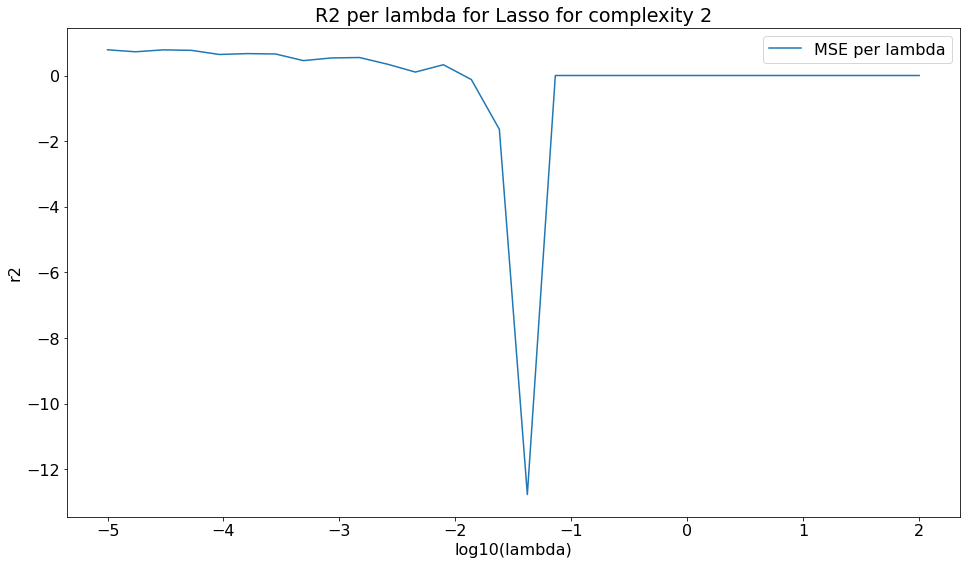

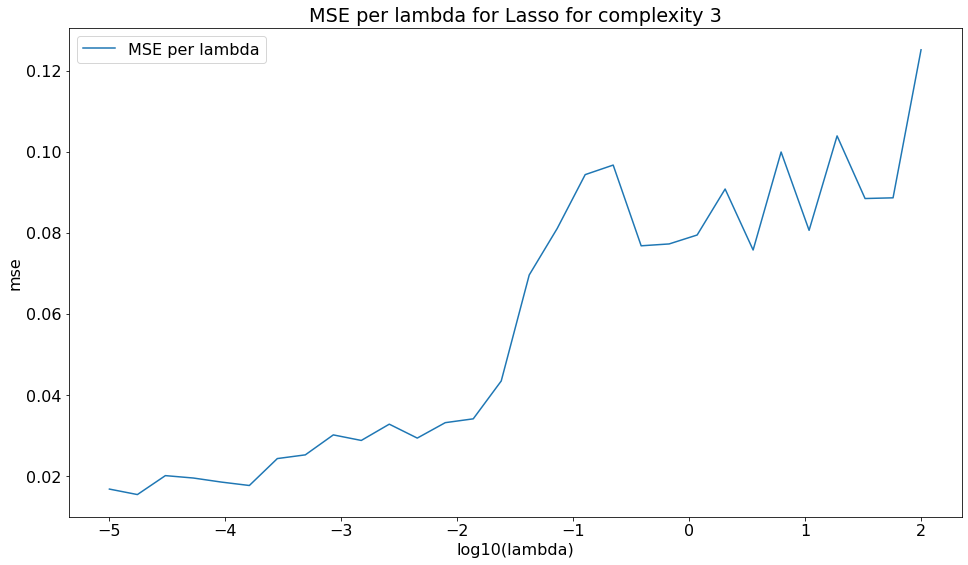

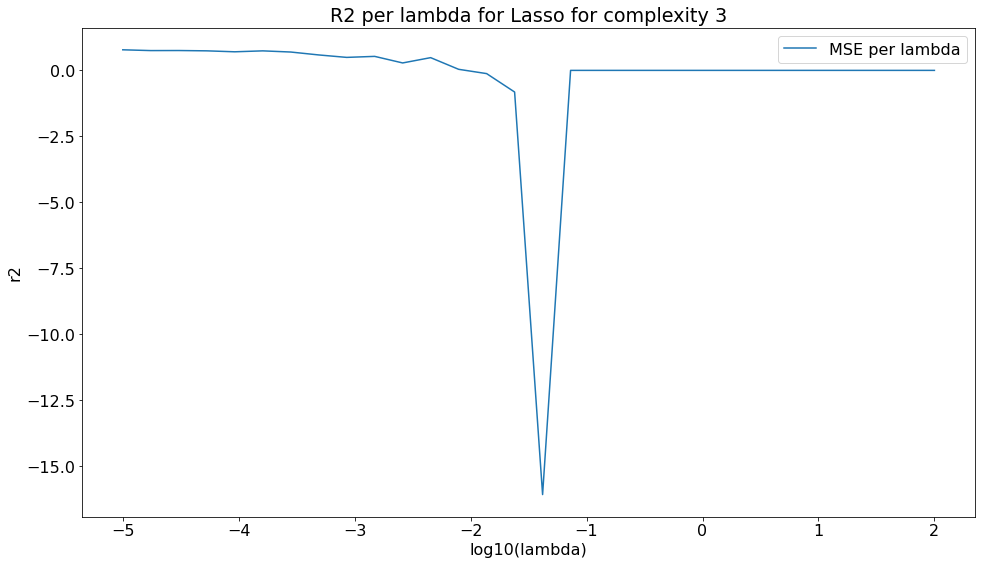

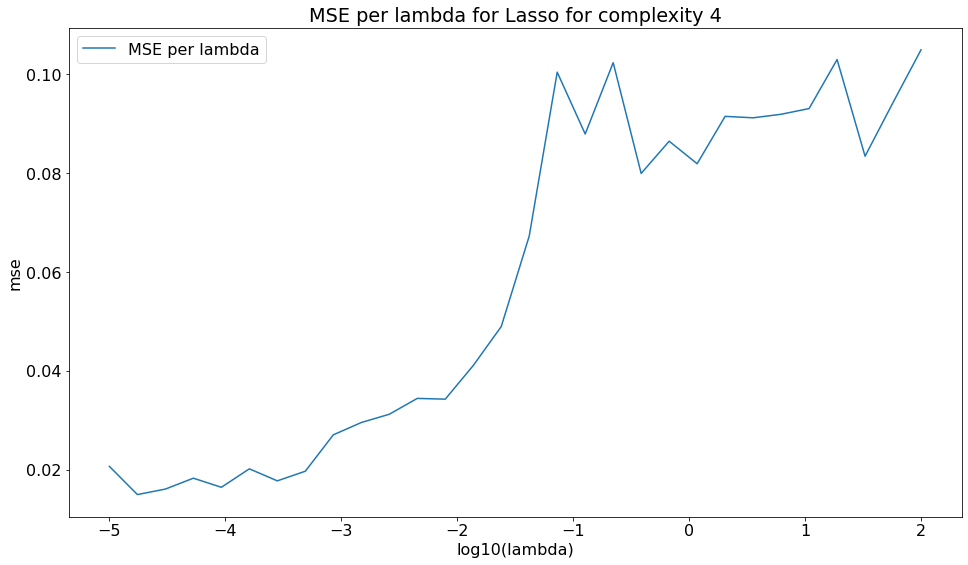

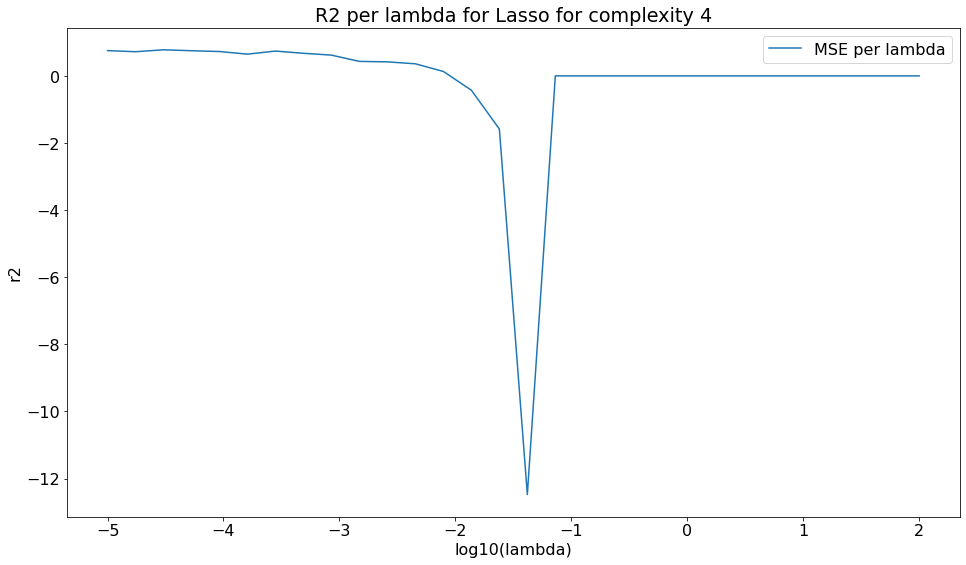

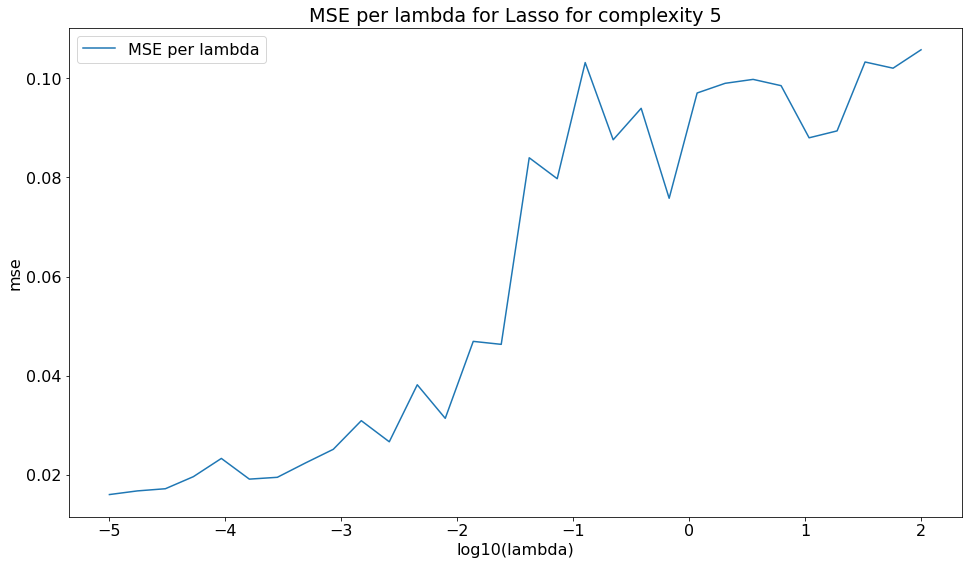

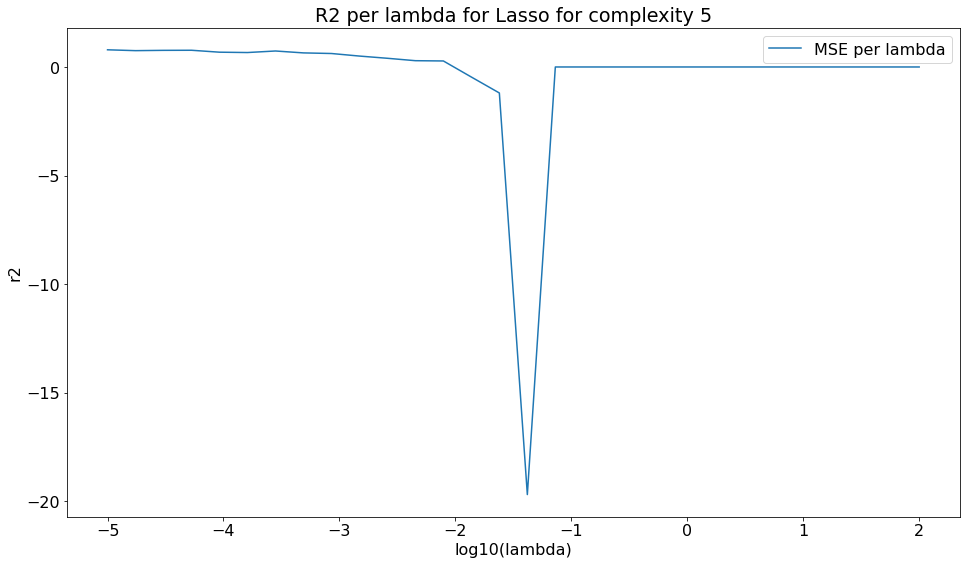

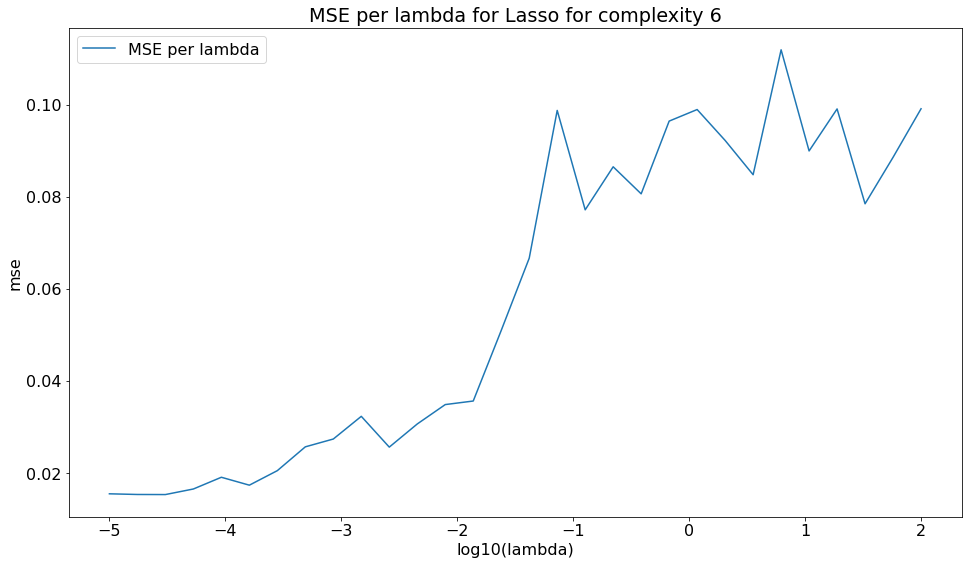

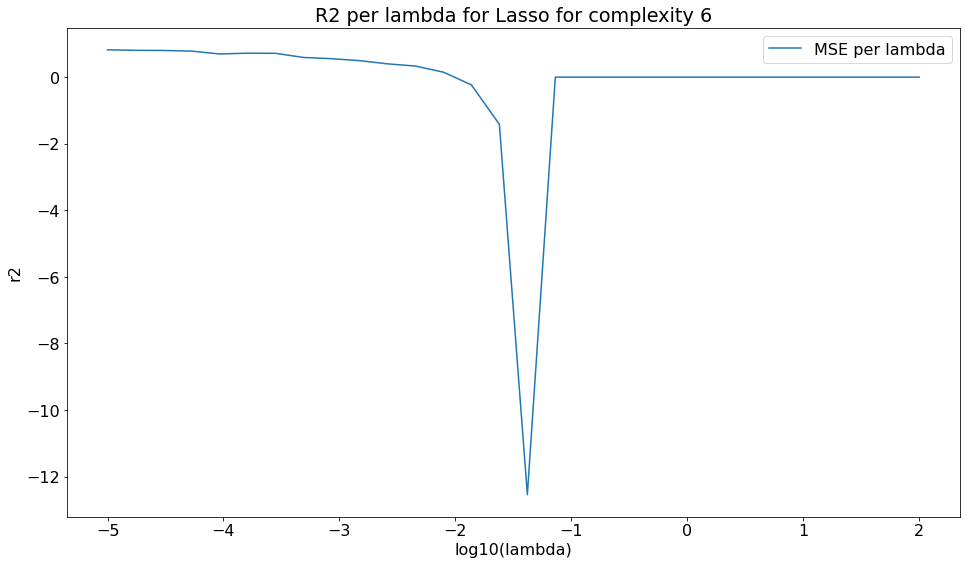

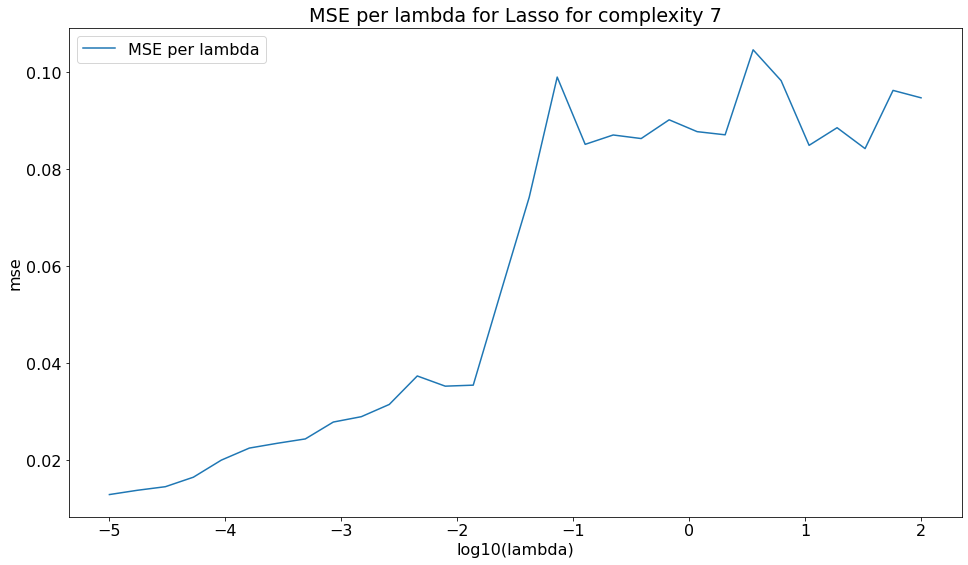

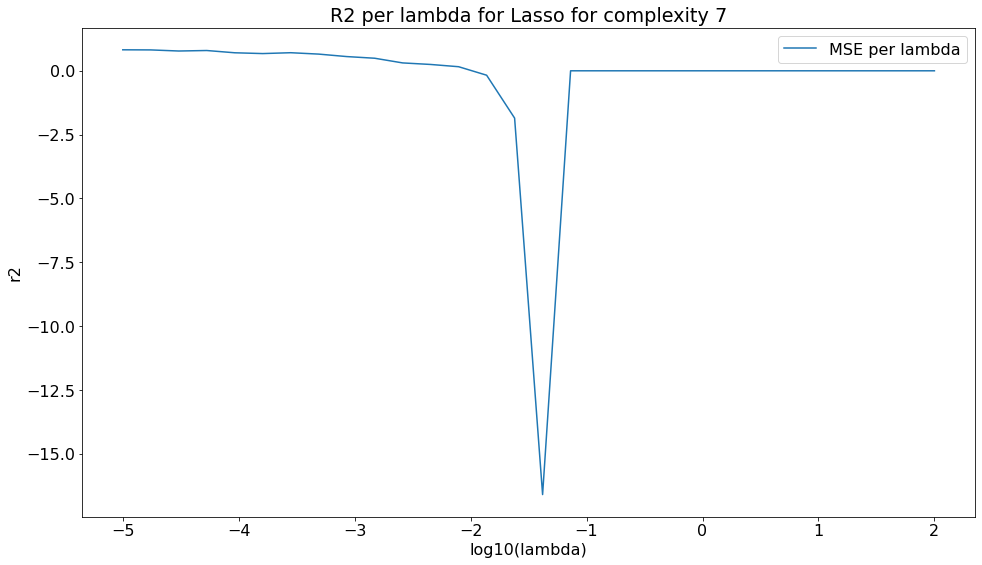

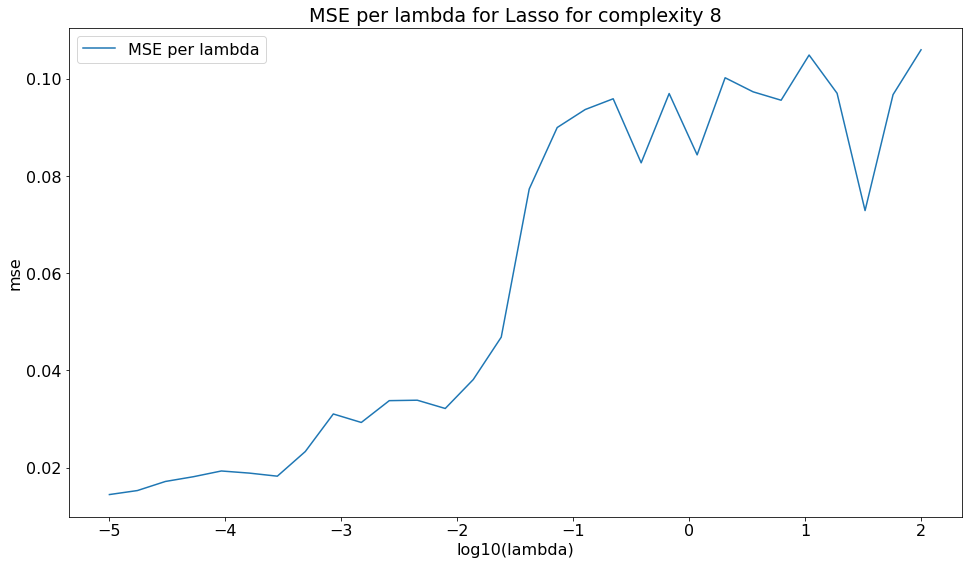

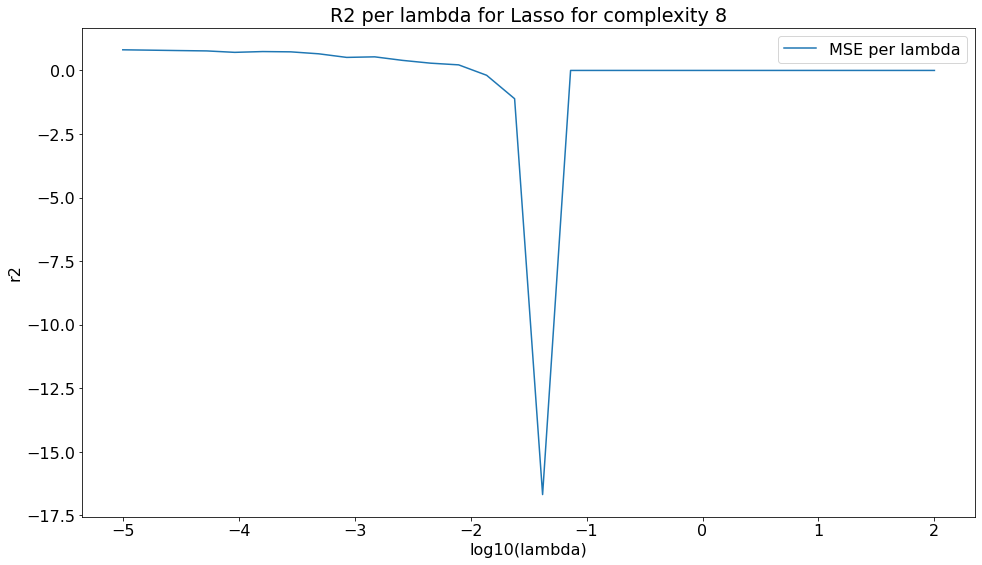

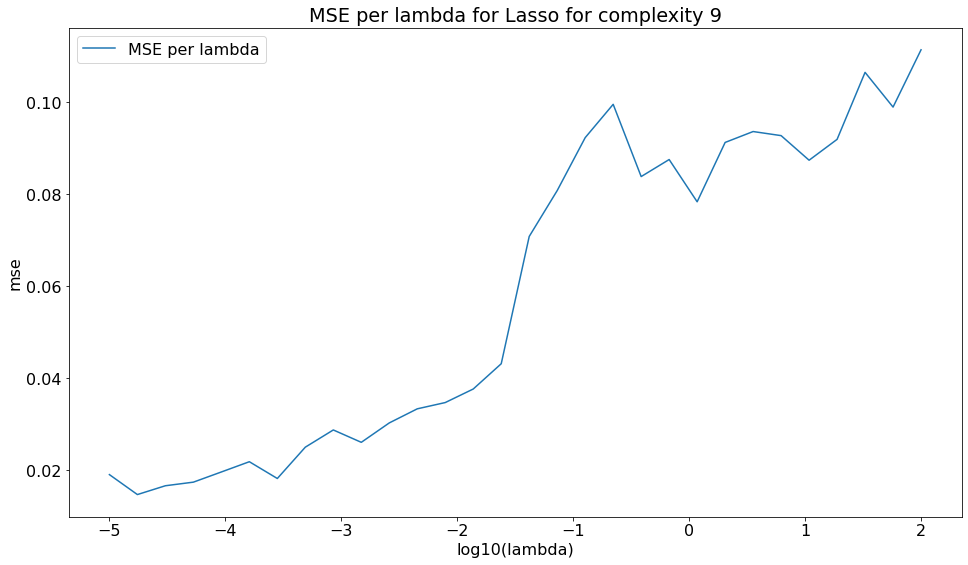

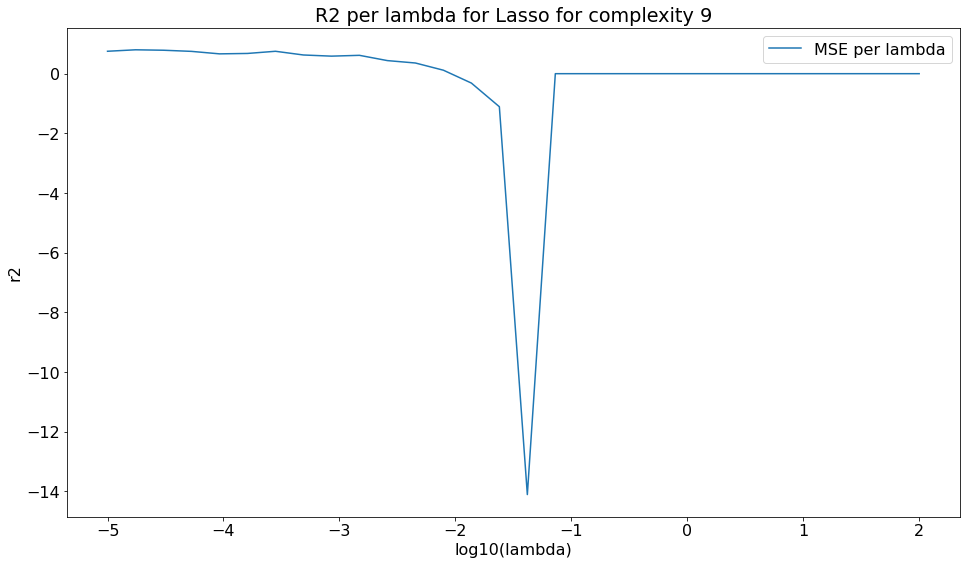

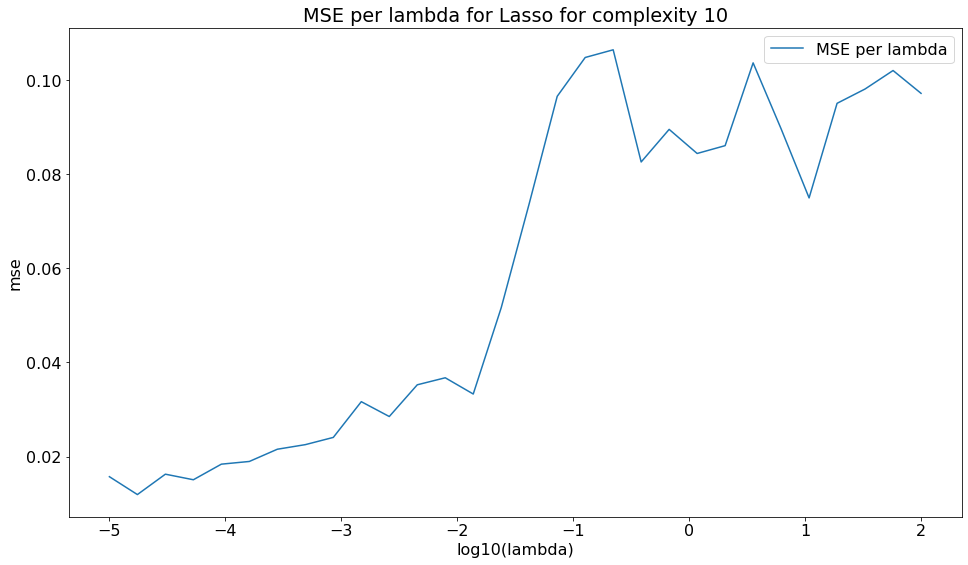

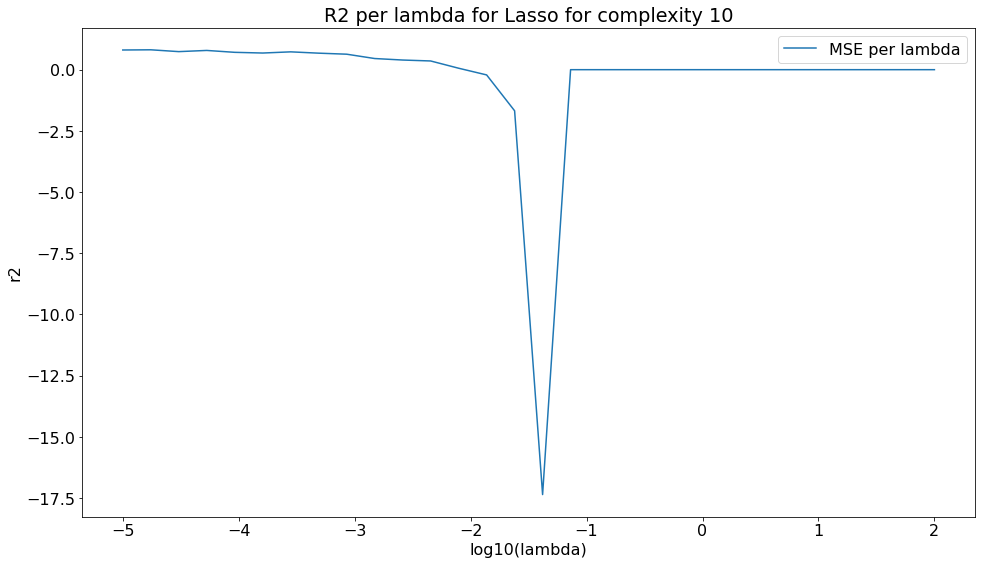

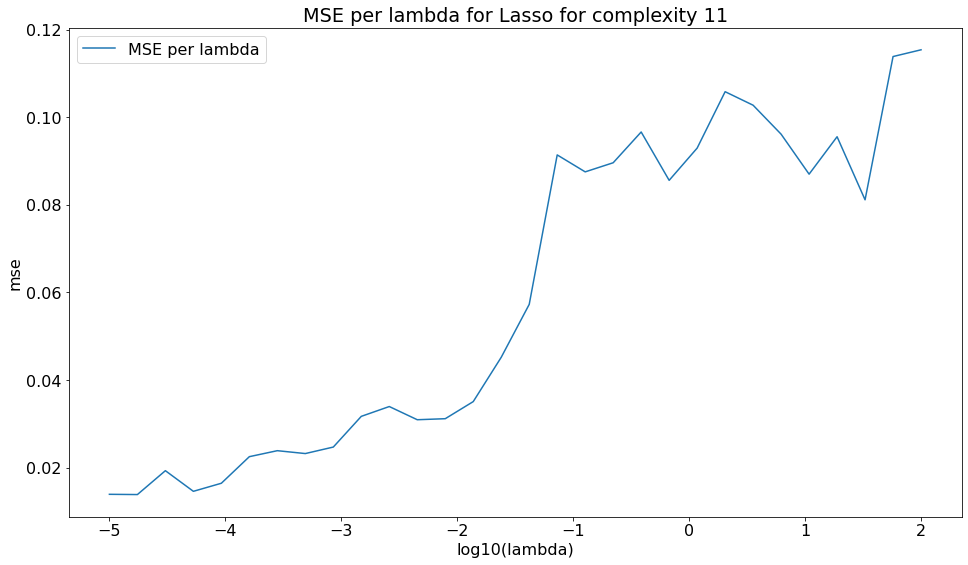

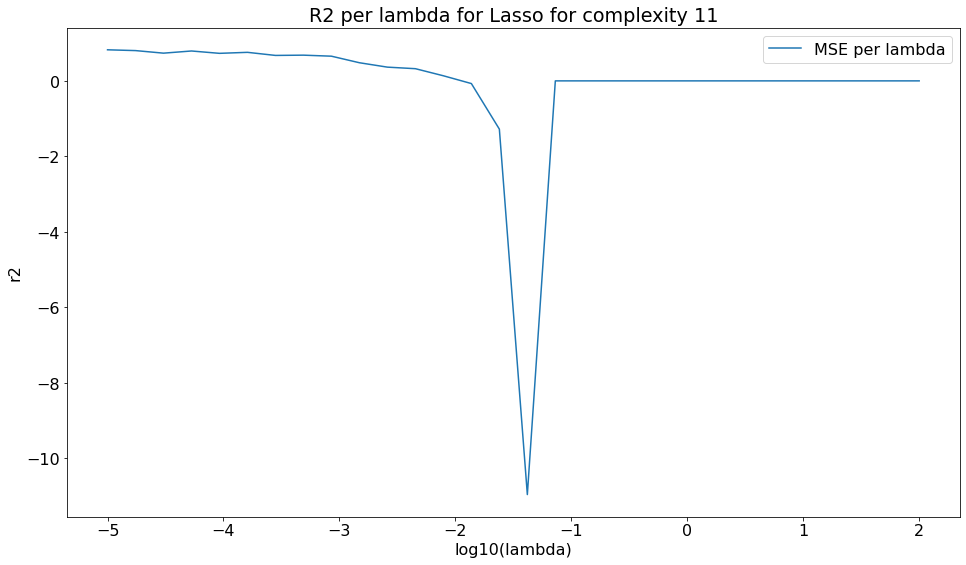

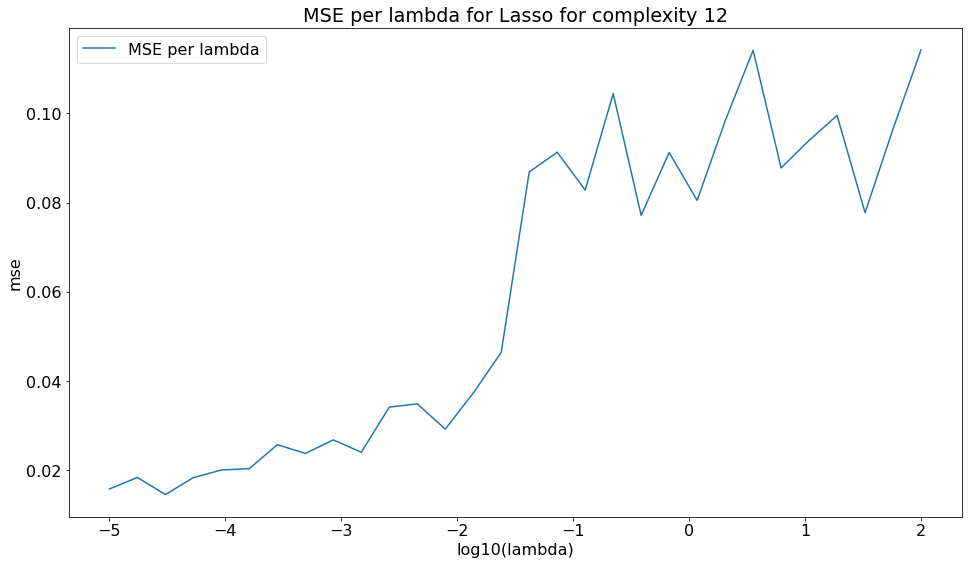

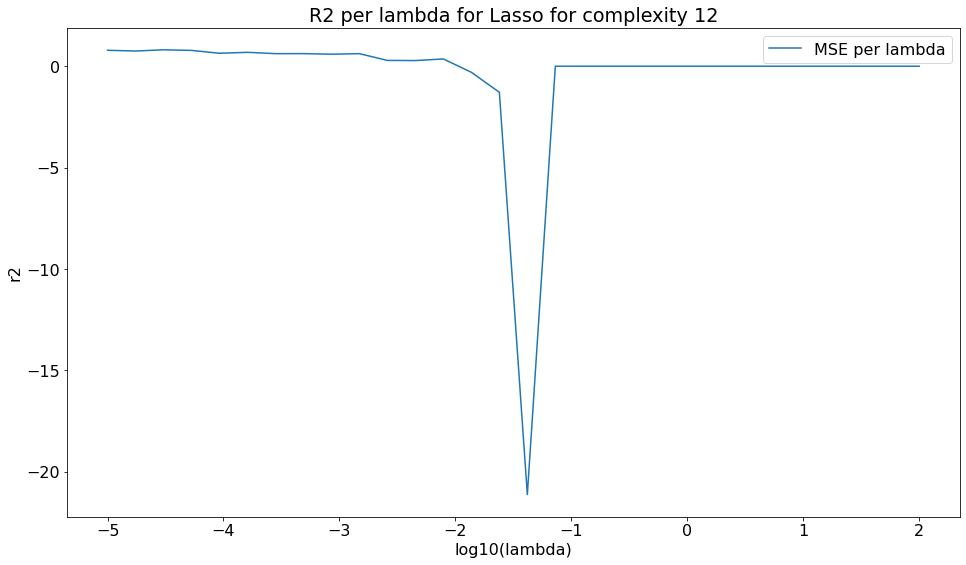

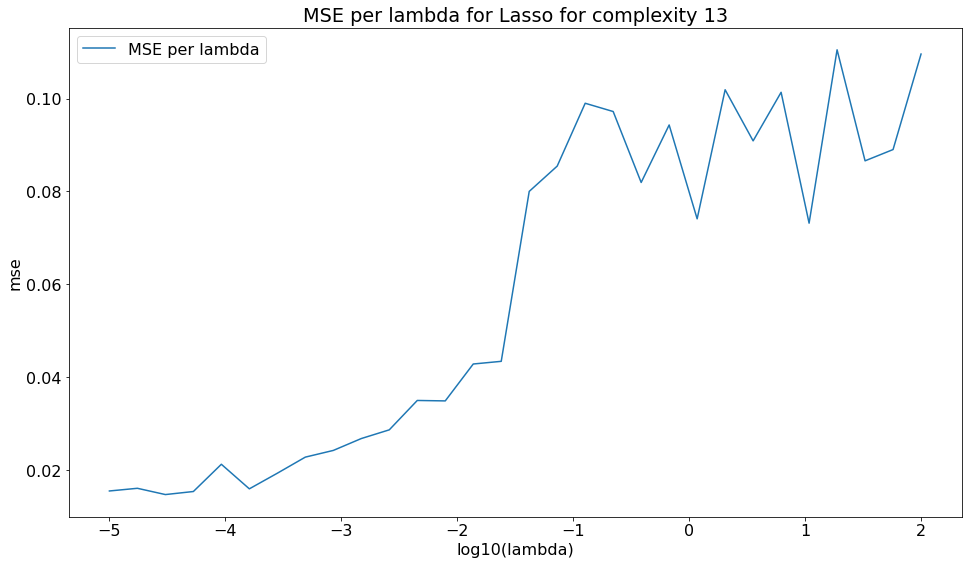

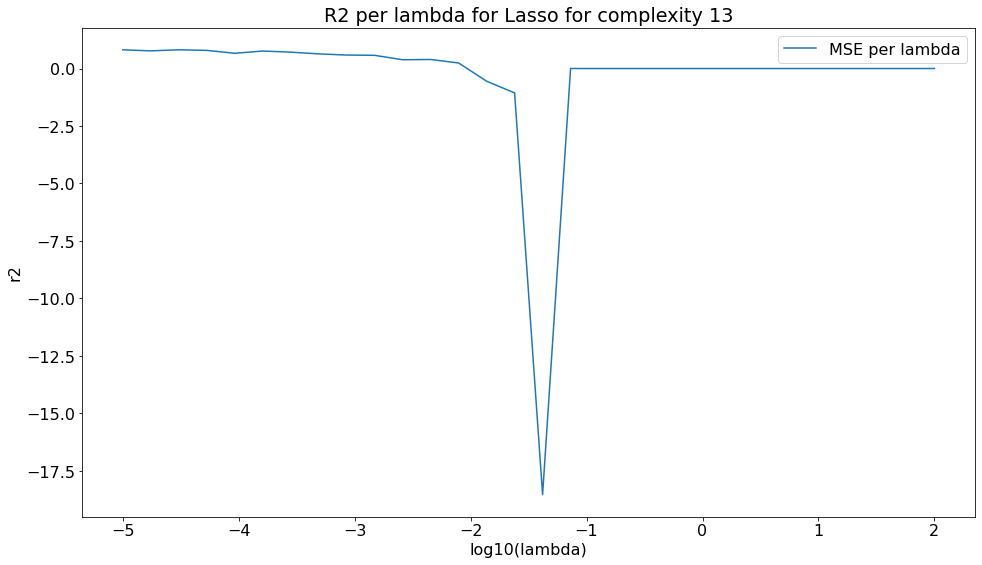

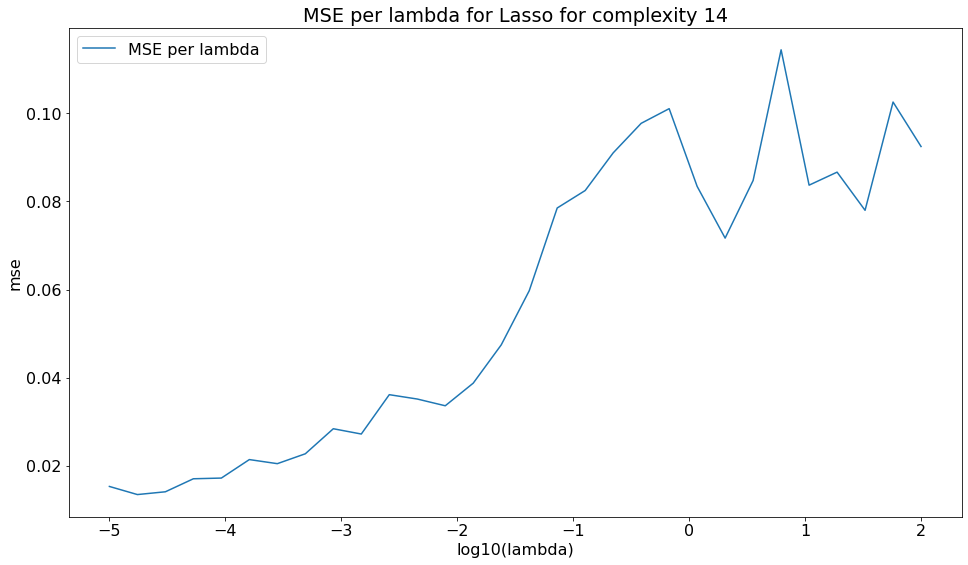

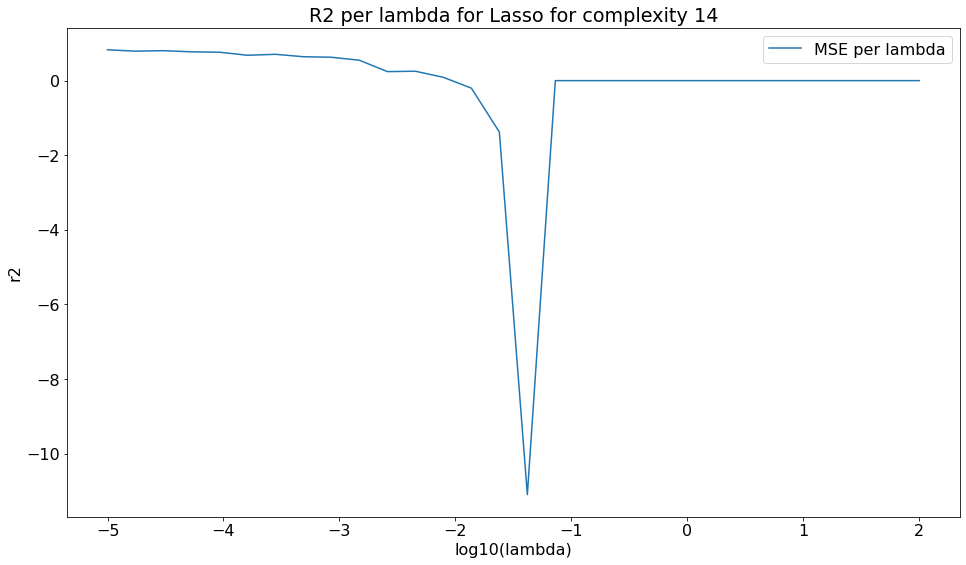

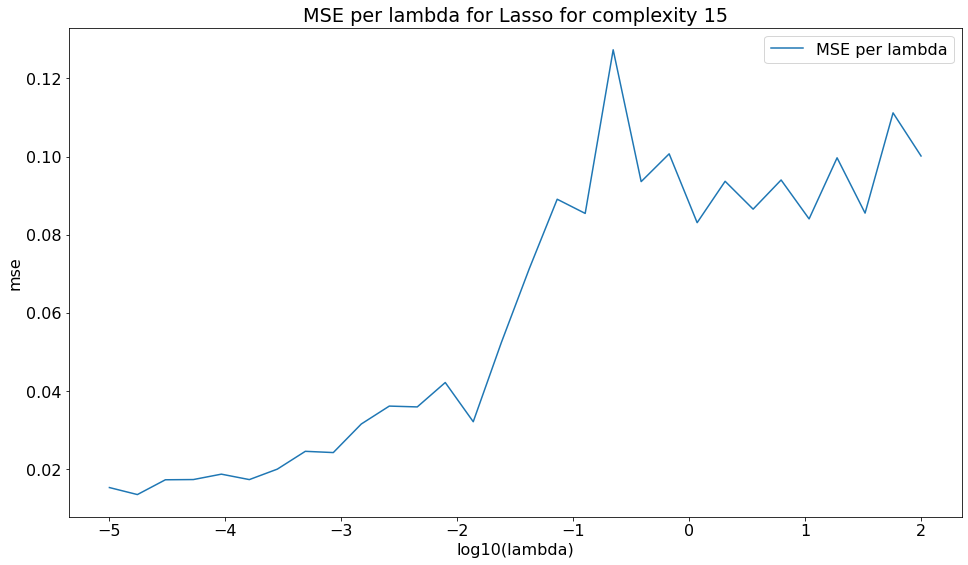

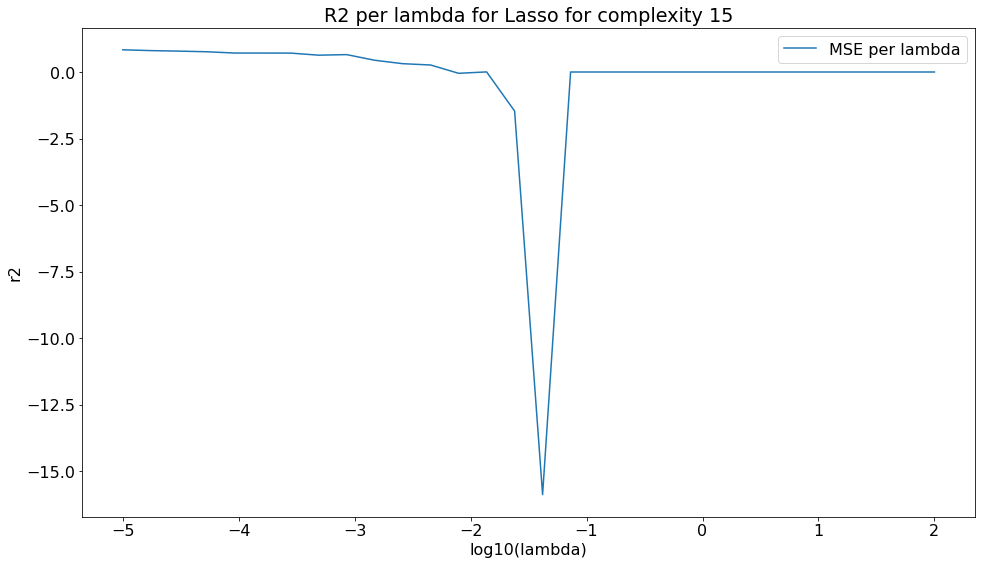

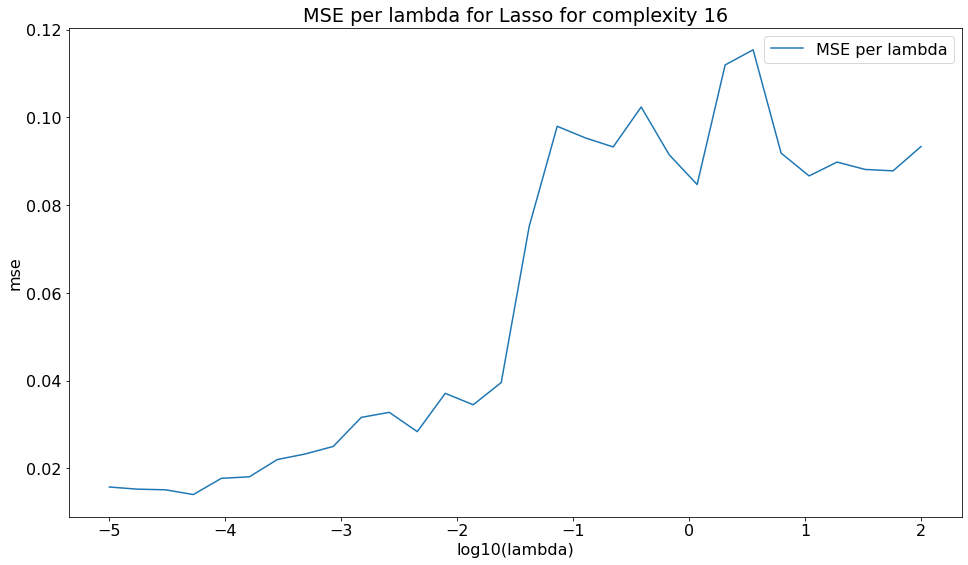

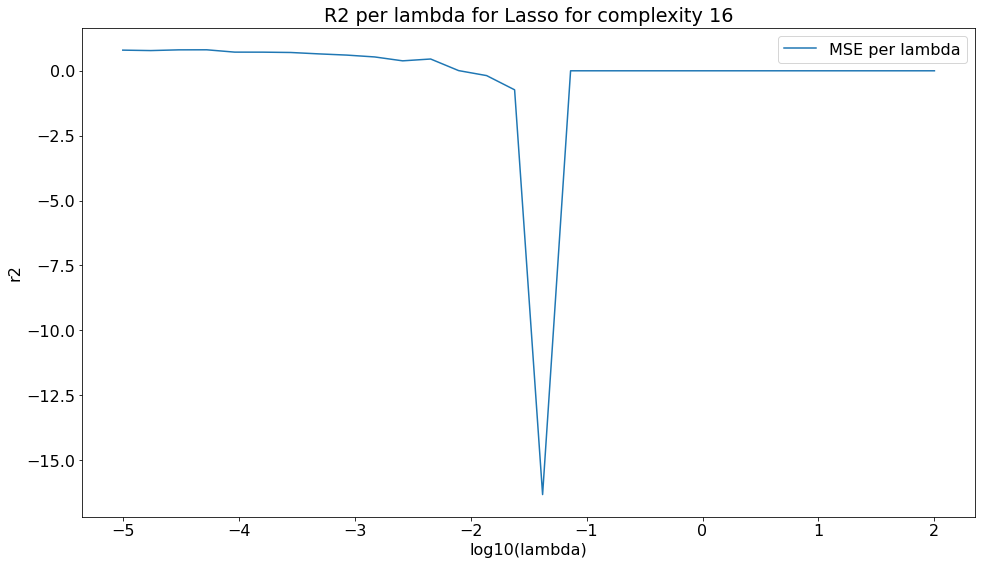

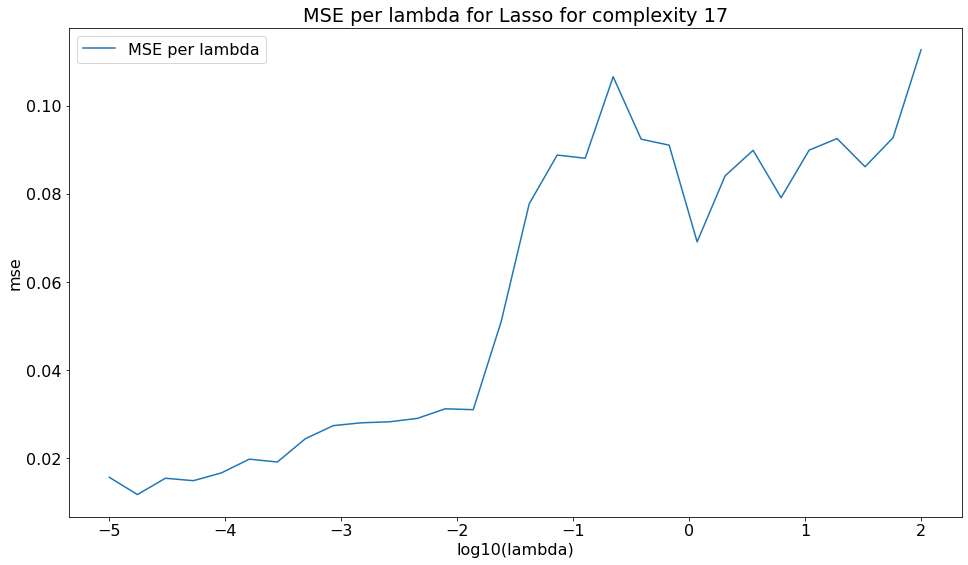

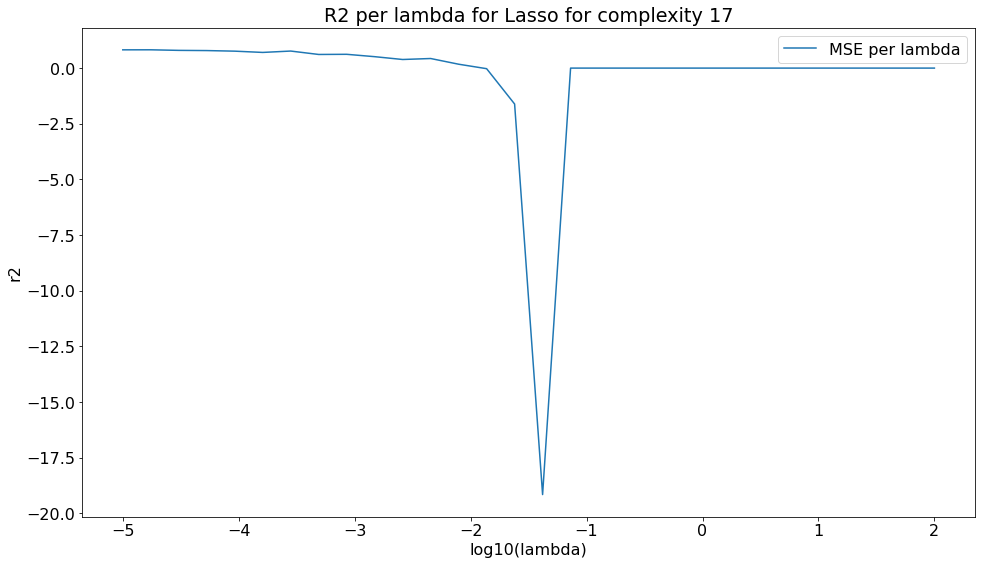

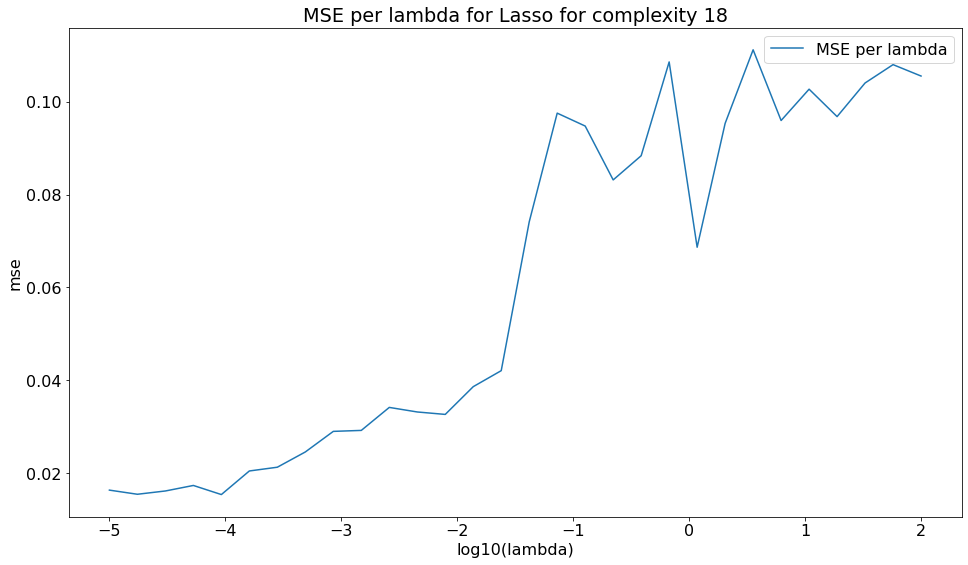

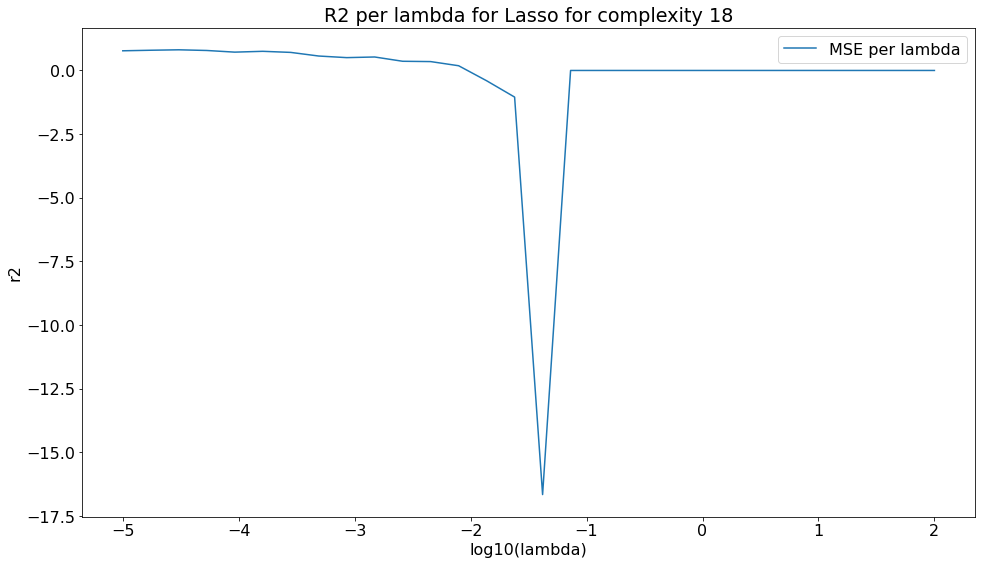

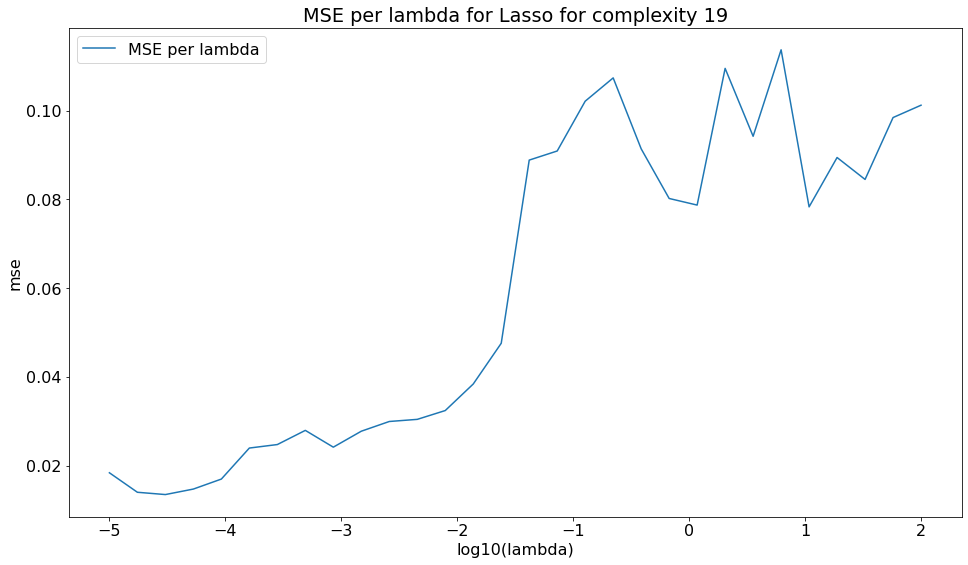

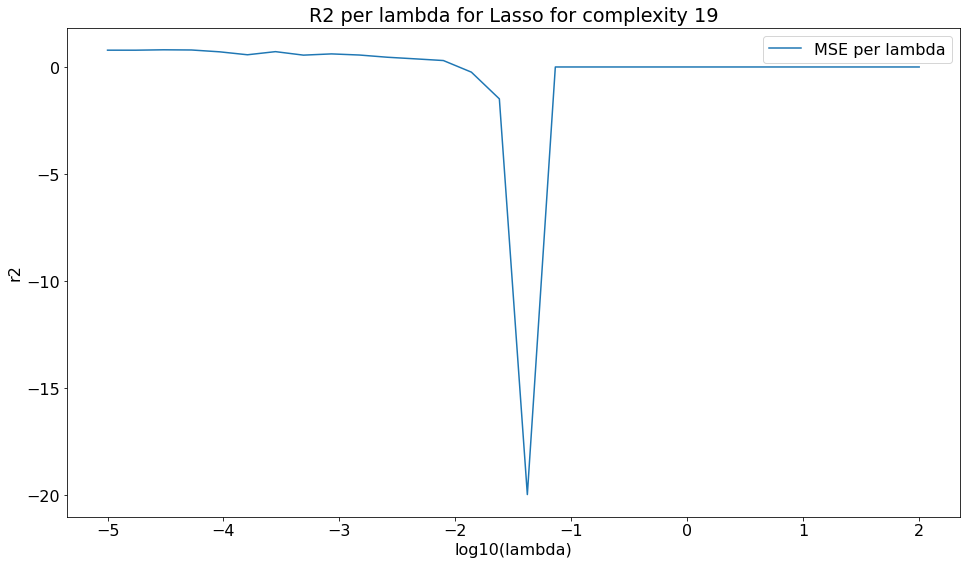

In [26]:
check_error_by_lambda(Lasso)

# Exercise 6 - Terrain data

### Exploring the data

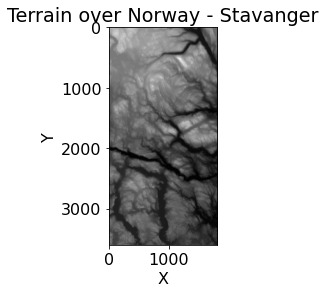

In [27]:
# Load the terrain
terrain1 = imread("./data/SRTM_data_Norway_1.tif")
# Show the terrain
plt.figure()
plt.title("Terrain over Norway - Stavanger")
plt.imshow(terrain1, cmap="gray")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Setting up the data

In [28]:
def load_data(file_name: str = "./data/SRTM_data_Norway_1.tif", re_size = 10, display: bool = False):
    """
    Load terrain dataset from image and create x and y coordinates.
    
    Returns:
        x: x components of the input data
        y: y components of the input data
        z: targets 
    """

    data = imread(file_name)

    if display:
        plt.imshow(data, plt.cm.gray)
        plt.axis("off")
        plt.show()
        
    np_terrain = np.array(data)
    # Want the x and y values to be the axis.
    x = np.linspace(0, 1, np_terrain.shape[0])
    y = np.linspace(0, 1, np_terrain.shape[1])
    x, y = np.meshgrid(x, y)
    
    # Since x has double the length than y, we jump double the length to more effectively reduce the size of the dataset (for faster runs)
    x = x[0::2*re_size, 0::re_size].reshape(-1,1)
    y = y[0::2*re_size, 0::re_size].reshape(-1,1)
    data = data.T[0::2*re_size, 0::re_size].reshape(-1,1) #Transpose to match the size of x and y.

    return x, y, data


## Data

In [41]:
x,y,z = load_data(re_size=20)

# Let's do some simple visualization of the MSE and R2 scores

## Ordinary least square:

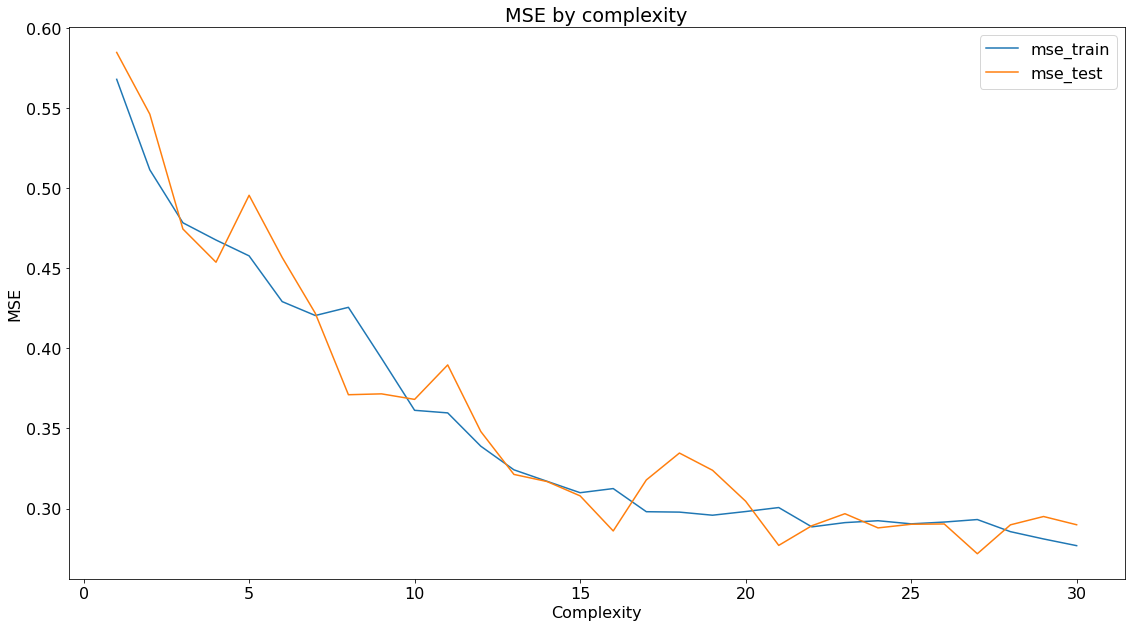

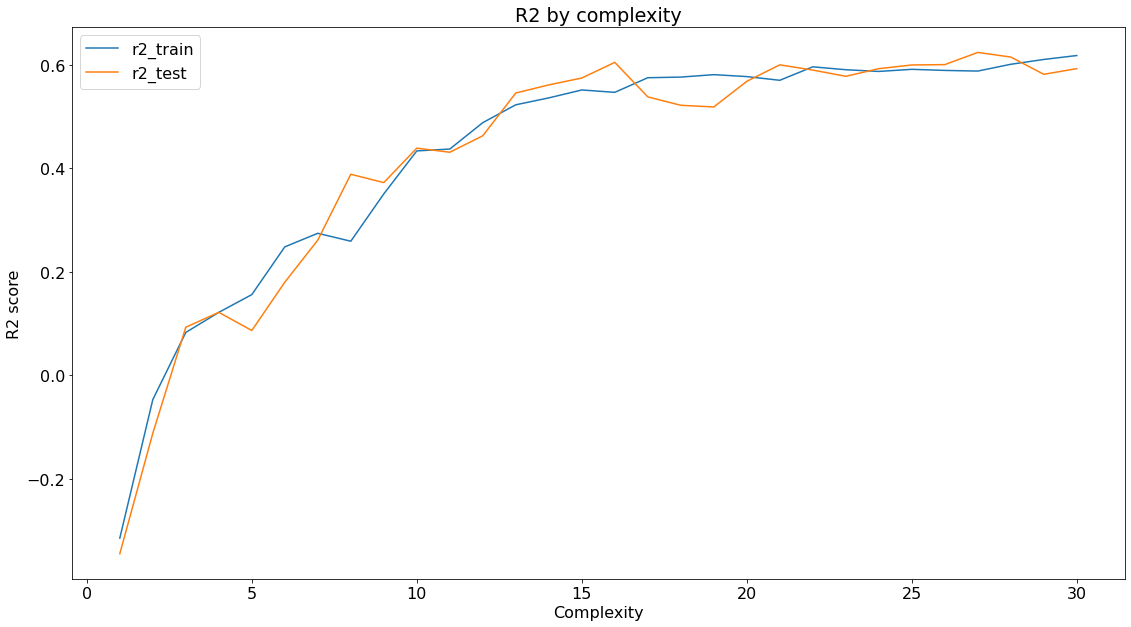

In [42]:
betas, xtx = simple_mse_and_r2_by_complexity(least_square, x = x, y=y, z=z, complexity = 30, noise = 0.1, plot_mse = True, plot_r2 = True, scale_with_std =  True )

## Ridge

0.0001


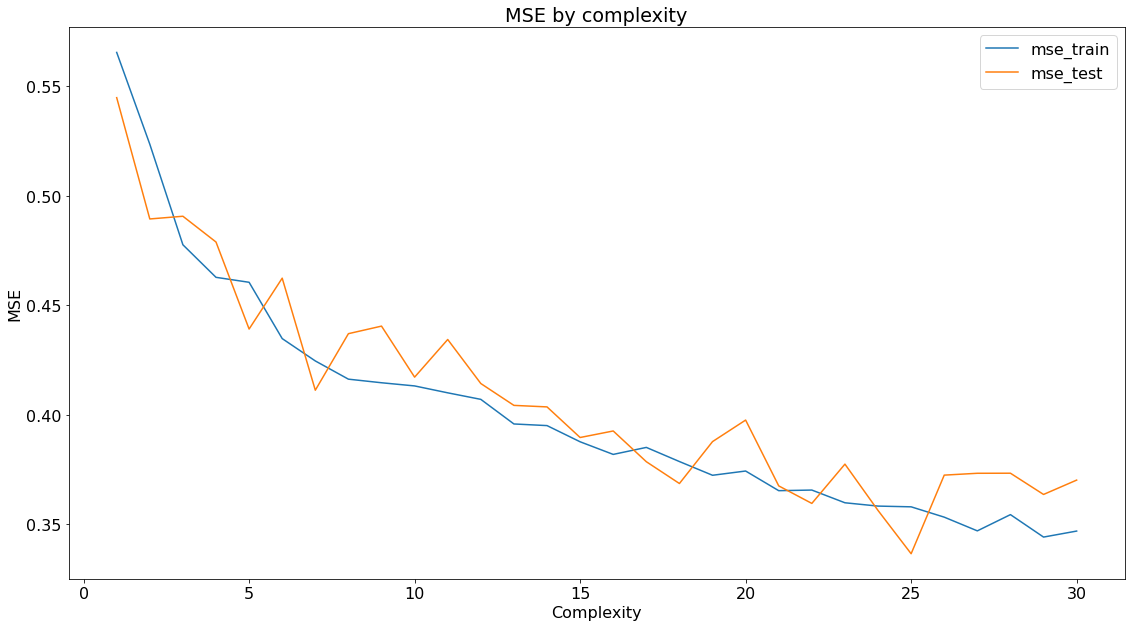

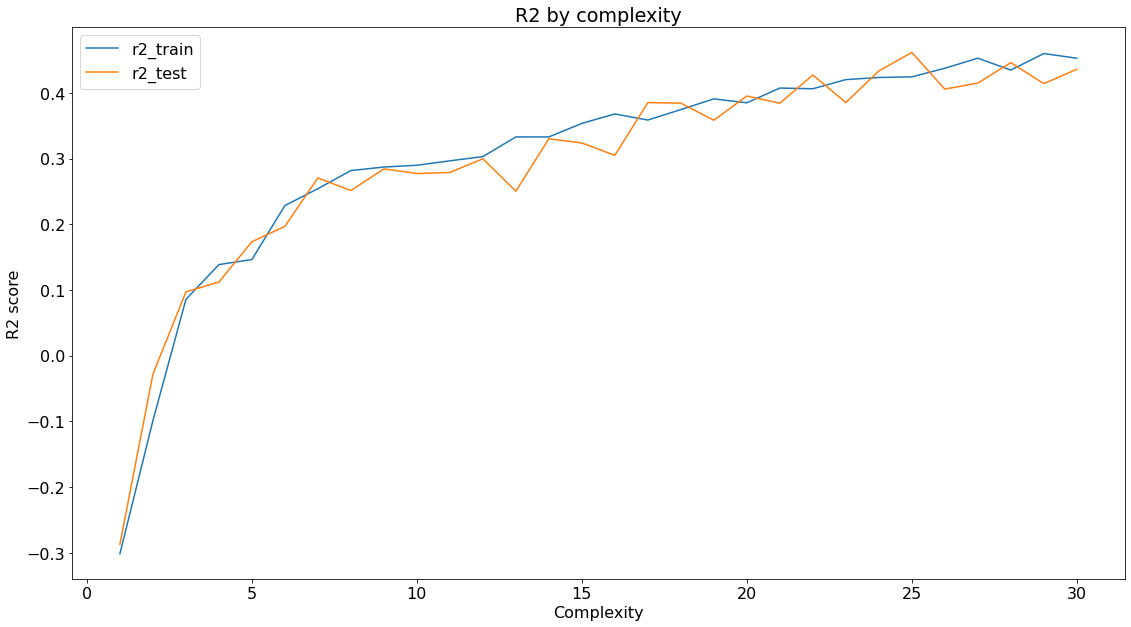

0.01


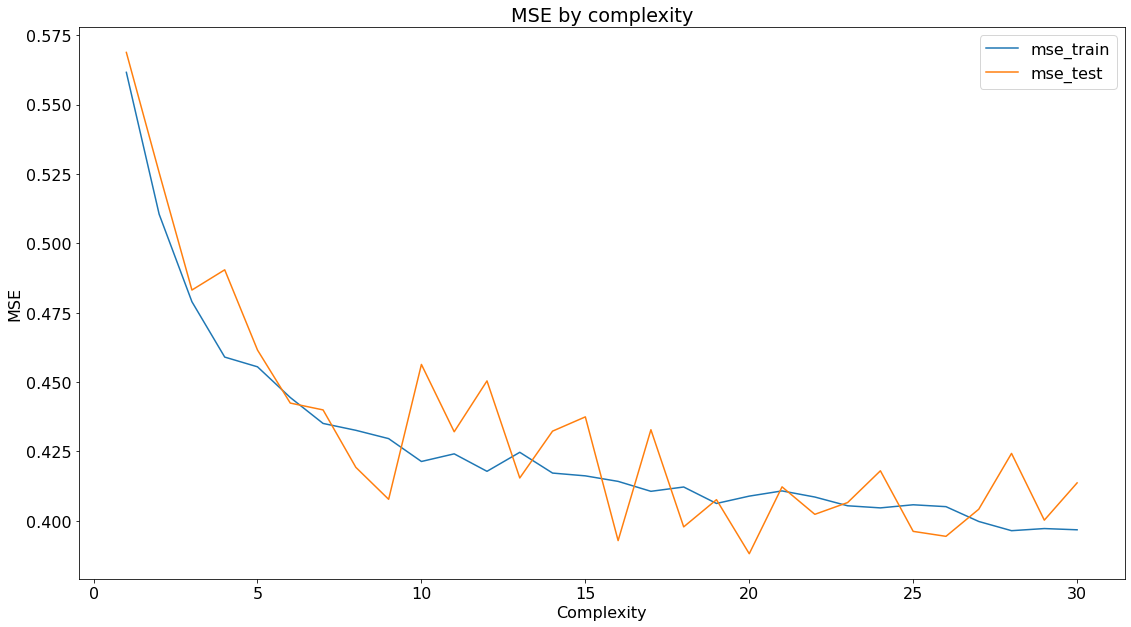

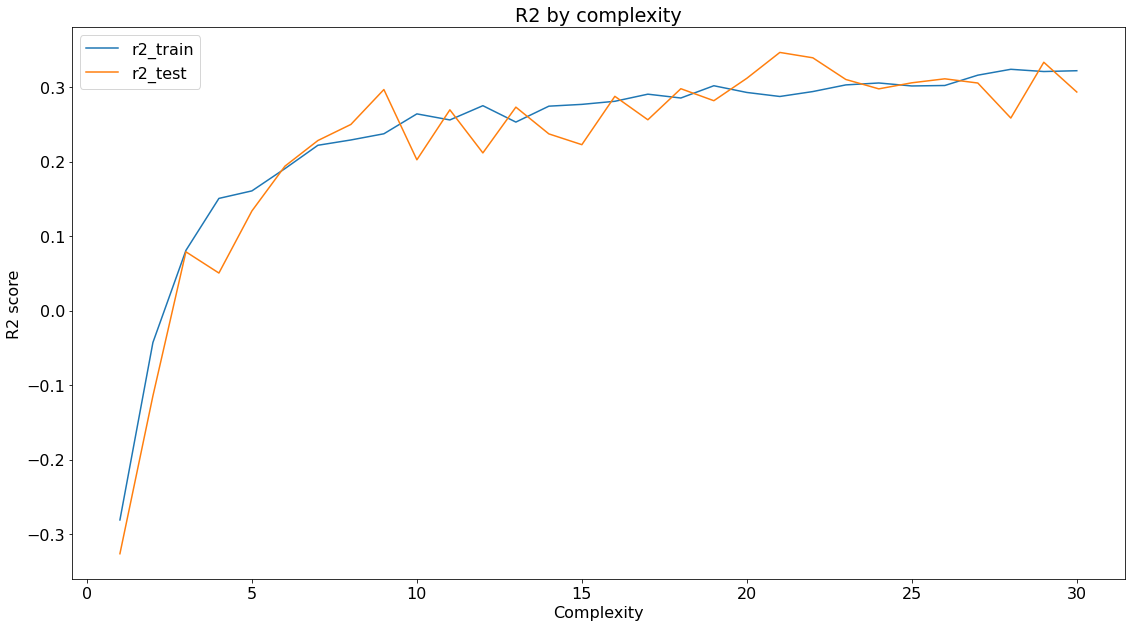

1.0


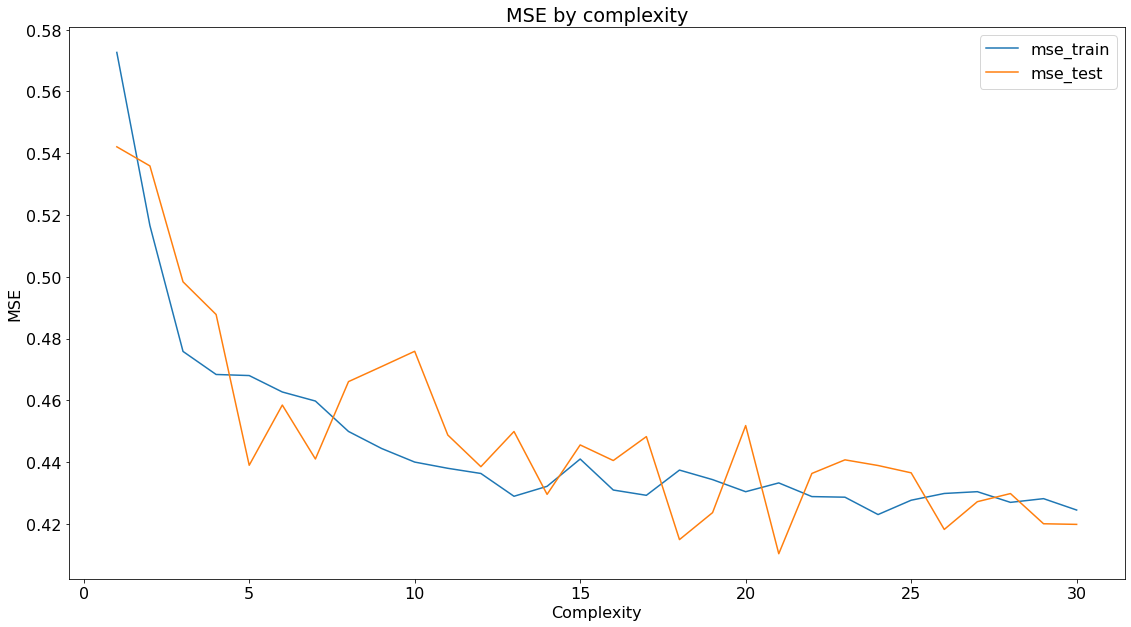

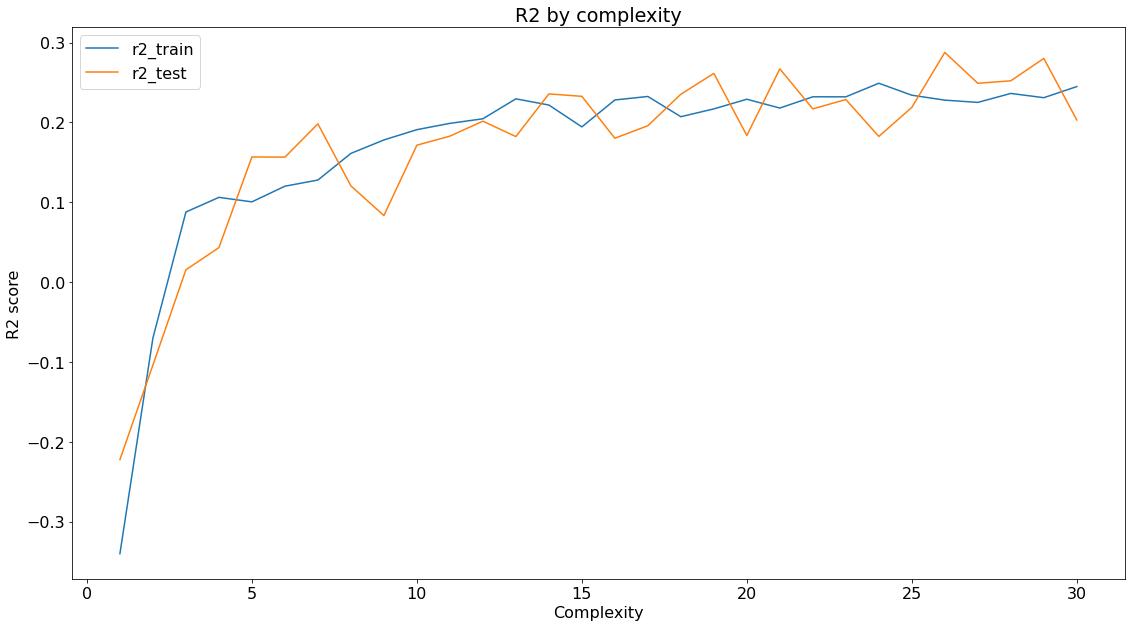

100.0


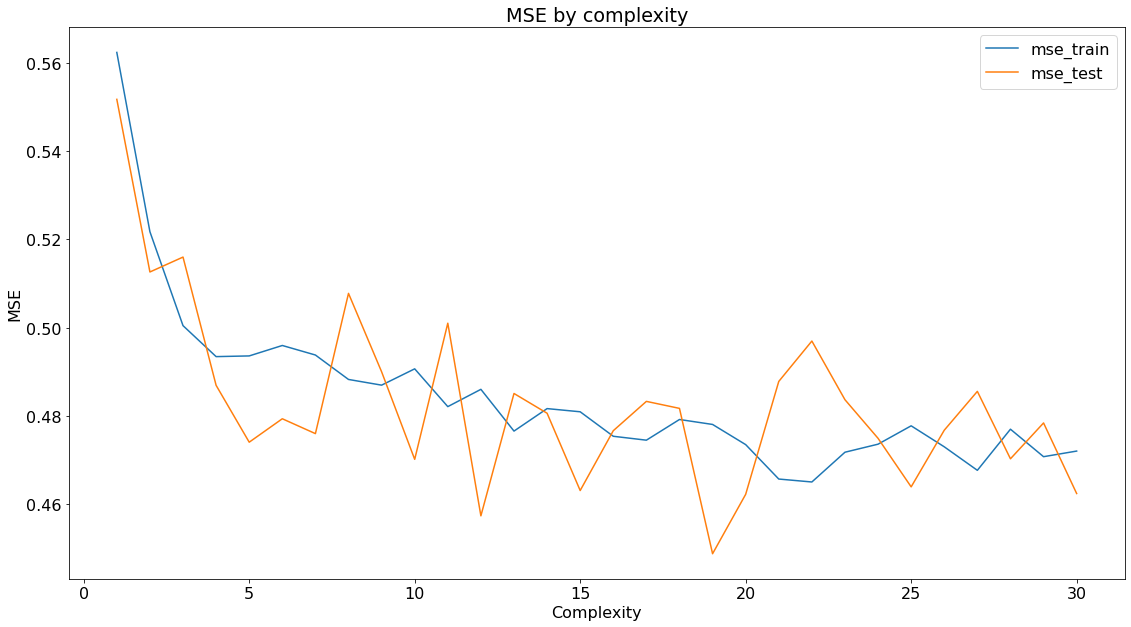

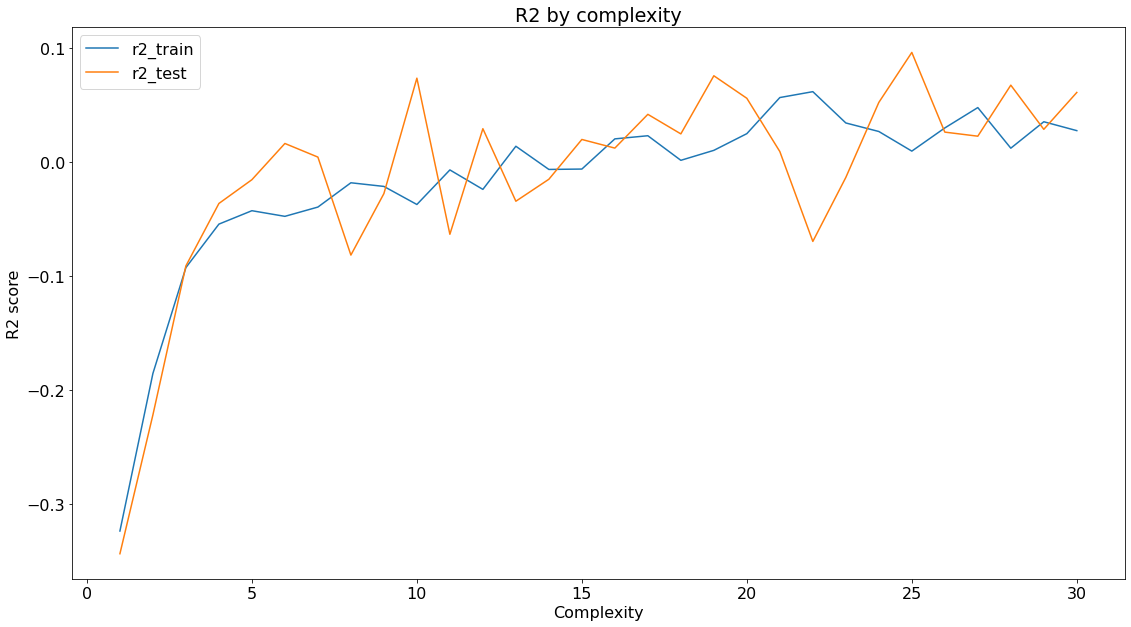

In [43]:
for lamb in np.logspace(-4,2, 4):
    print(lamb)
    betas, xtx = simple_mse_and_r2_by_complexity(Ridge, x = x, y=y, z=z, lamb = lamb, complexity = 30, noise = 0.1, plot_mse = True, plot_r2 = True, scale_with_std =  True )

## Lasso

0.0001


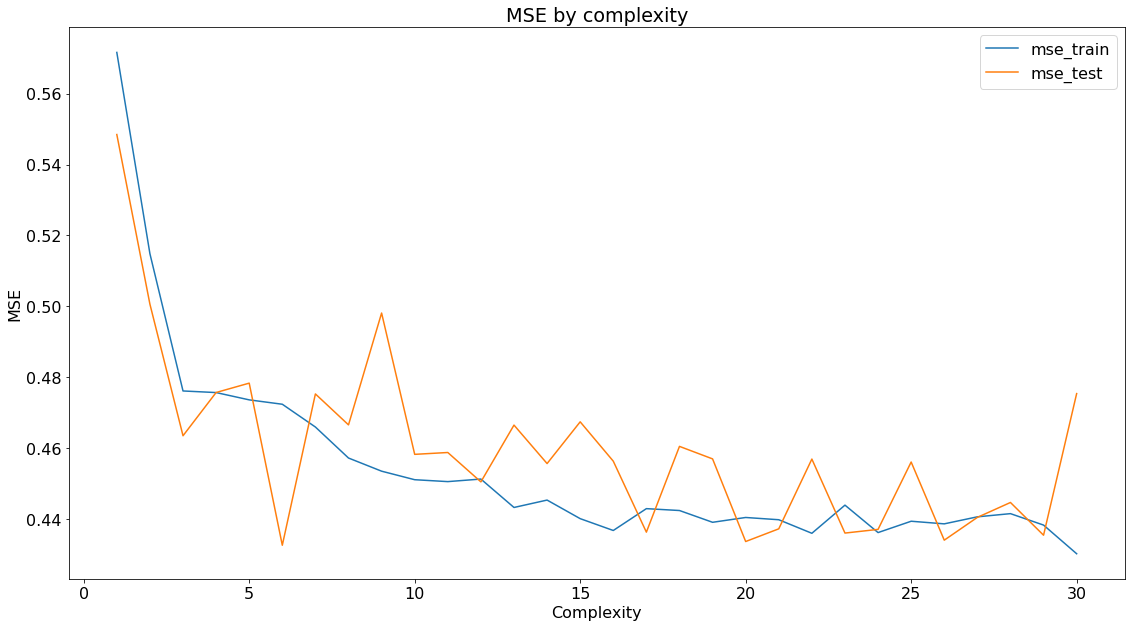

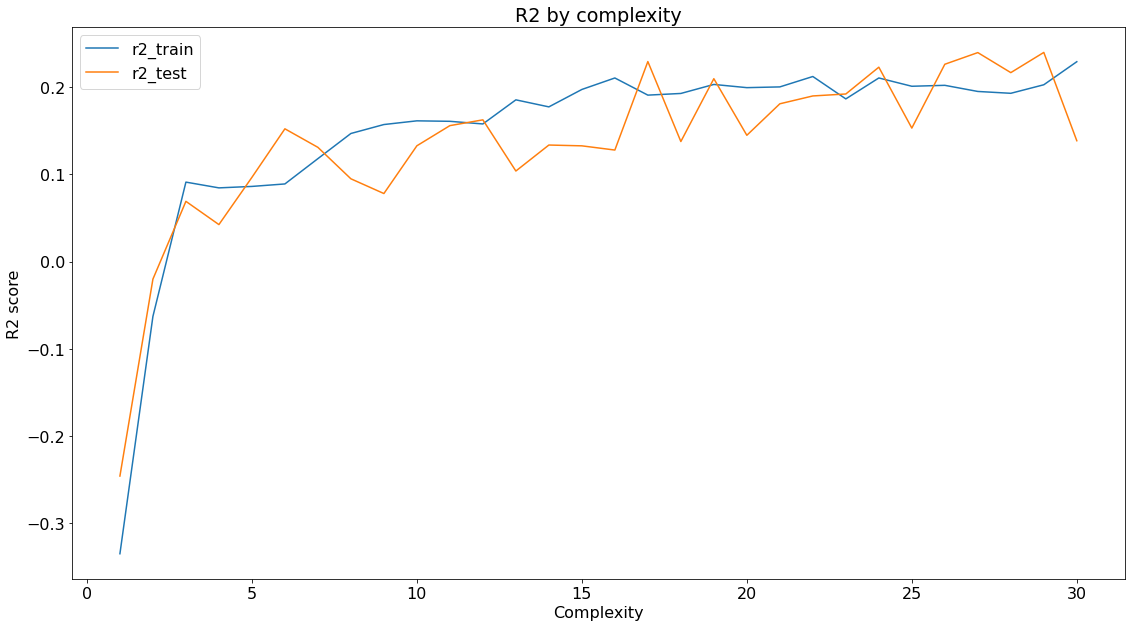

0.01


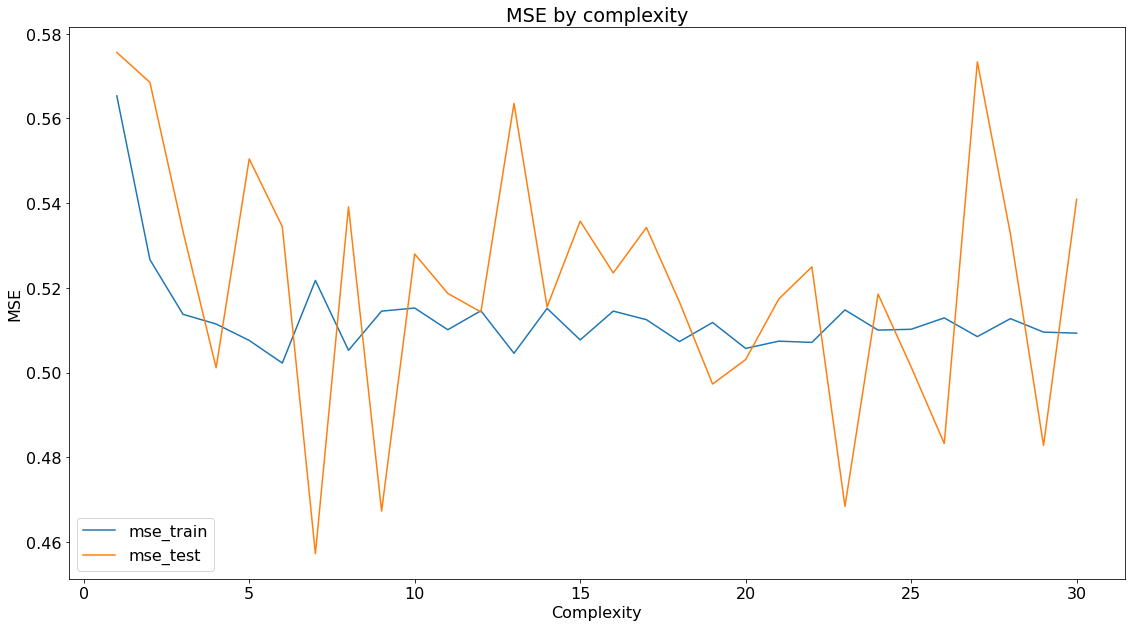

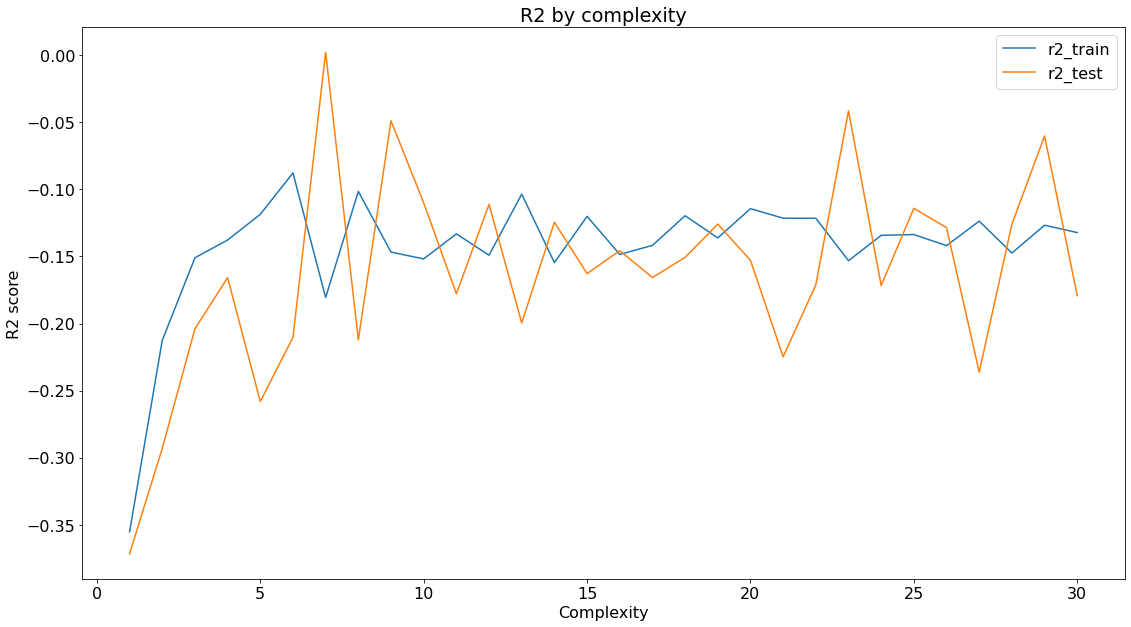

1.0


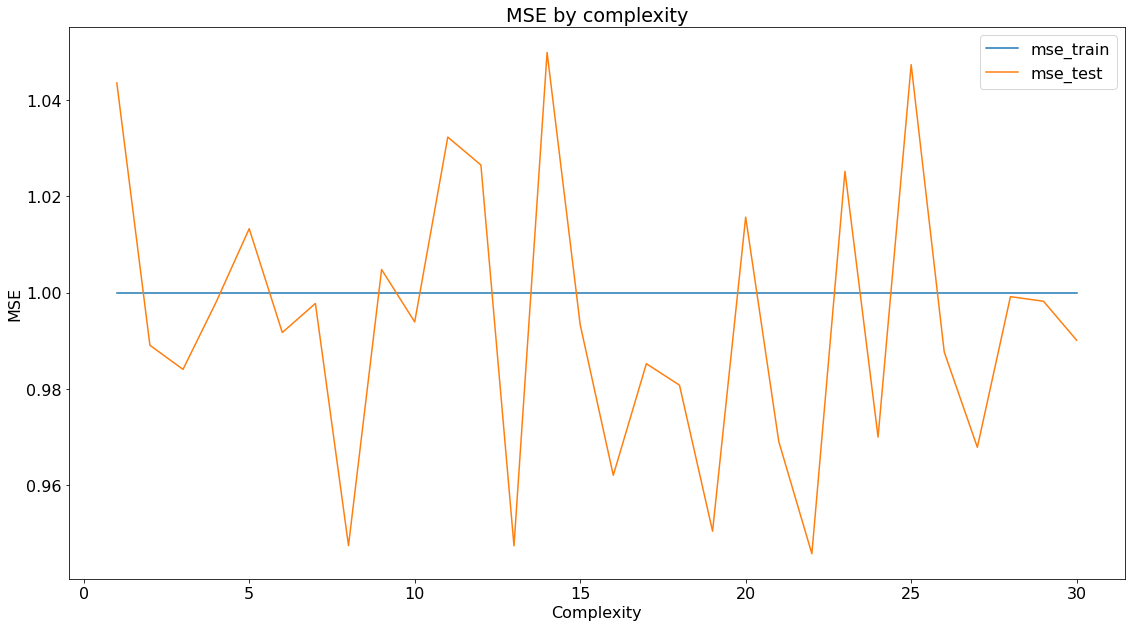

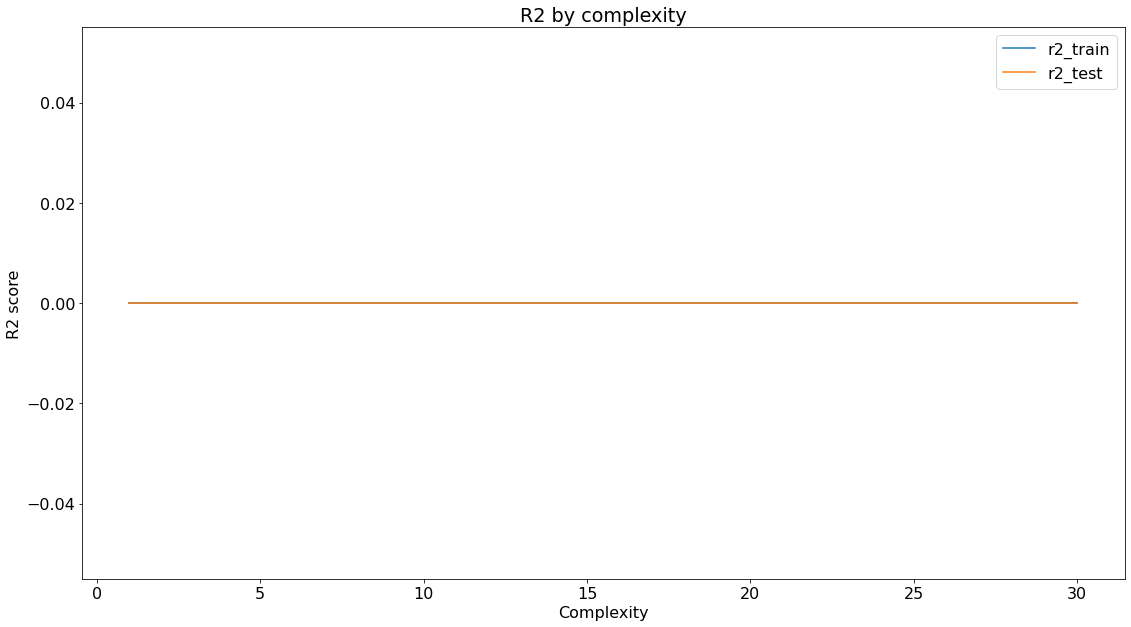

100.0


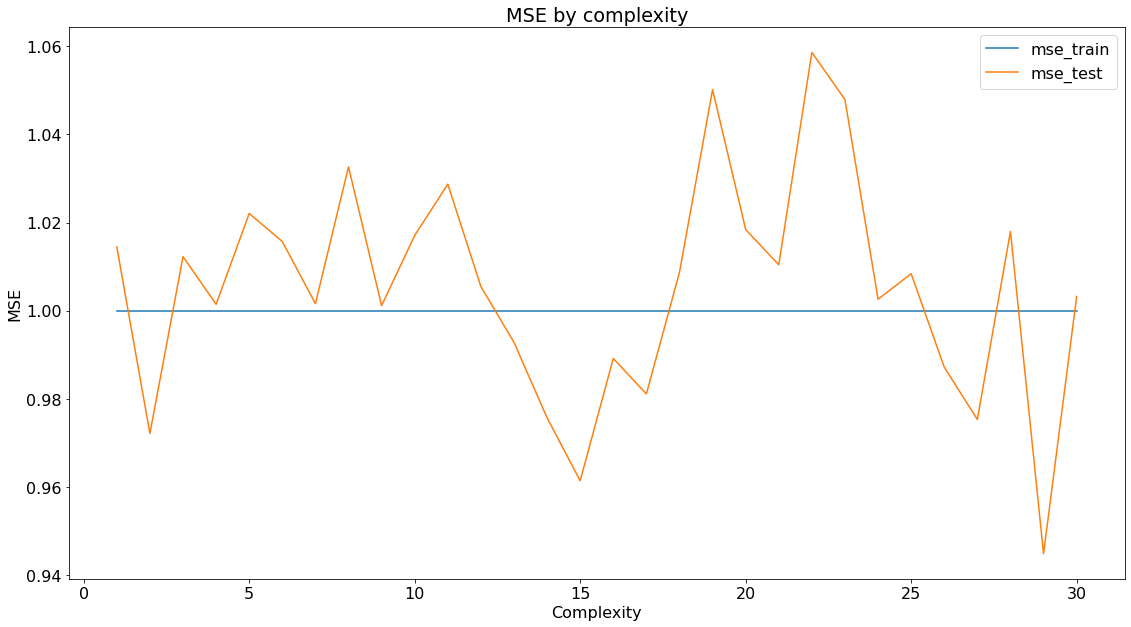

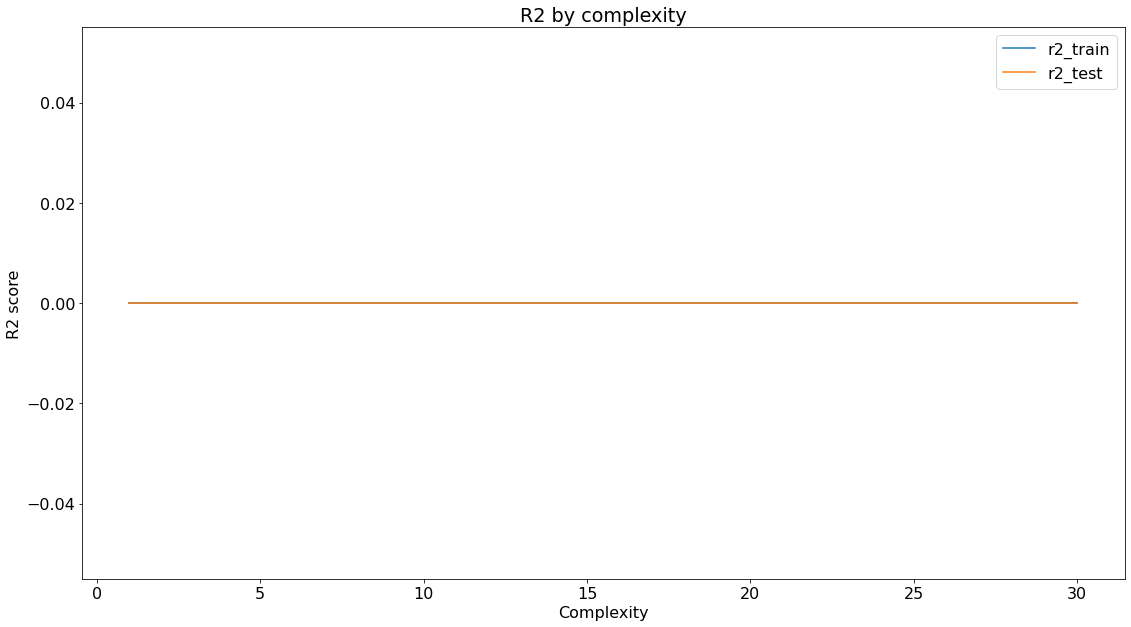

In [44]:
for lamb in np.logspace(-4,2, 4):
    print(lamb)
    betas, xtx = simple_mse_and_r2_by_complexity(Lasso, x = x, y=y, z=z, lamb = lamb, complexity = 30, noise = 0.1, plot_mse = True, plot_r2 = True, scale_with_std =  True )

# Cross validation for Ridge

Number of datapoints 8326
Best params: Folds = 15 and complexity = 6 with lambda = 0.005179474679231213. Best MSE: 0.5693872940770499


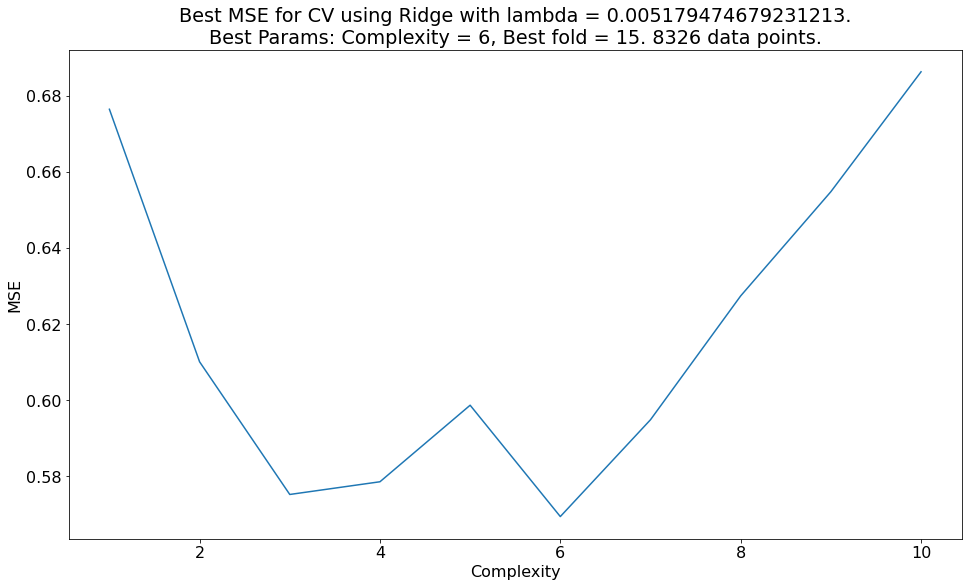

In [45]:
mse_aggregate, lambdas = cv_analysis_ridge_lasso(Ridge, x = x, y=y, z=z, nlambdas = 15, max_complexity = 10, min_fold = 5, max_fold = 15, scale_with_std = True)

# Cross validation for Lasso

Number of datapoints 8326
Best params: Folds = 15 and complexity = 3 with lambda = 0.0003727593720314938. Best MSE: 0.5709713724029288


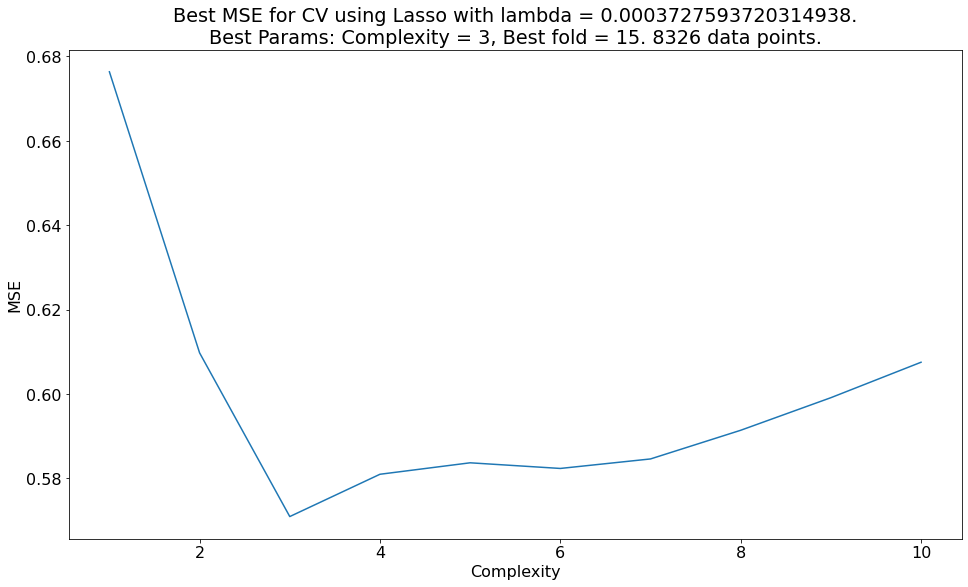

In [46]:
mse_aggregate, lambdas = cv_analysis_ridge_lasso(Lasso, x = x, y=y, z=z, nlambdas = 15, max_complexity = 10, min_fold = 5, max_fold = 15, scale_with_std = True)